In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline



from sklearn import preprocessing # to use MinMaxScaler
from keras.models import Sequential,Model,Input
from keras.layers.core import Dense ,Activation
from keras.layers import concatenate,Bidirectional,Dropout
from keras.layers.recurrent import LSTM
from keras.regularizers import L1L2
#from keras.optimizers import SGD
#from keras.layers.recurrent import SimpleRNN

In [7]:
#Reader of DB companies
import ReaderDataCompaniesDB as rd

#Reading Companies of interest
companies='AVGO,MXIM,MCHP'.split(',')
#Creating object
reader=rd.Reader()

#Reading DataCompanies

df=pd.concat([reader.read(company=company,start_date='2019-10-01',end_date='2019-12-31',df=True).add_prefix(f'{company}_') for company in companies],axis=1)

In [3]:
#division of dataframe in continuous time ranges and companies
def Split_by_companiesANDcontinuosTime(df,time_min=350,delays=5,limit_disc=5,name_companies='AVGO,MXIM,MCHP'.split(',')):
    
    df_all=df[df.notna().all(axis=1)]
    
    
    groups=df_all.index.to_series().diff().gt(pd.Timedelta(minutes=limit_disc)).cumsum()

    return { group.index[0].strftime(format='%Y-%m-%d %H:%M:%S'):{ company: 
                       group.loc[:,group.columns.str.contains(company)].iloc[:(len(group)//time_min)*time_min+delays] 
                      for company in name_companies }
             for i,group in df_all.groupby(groups) if ( len(group)>=(time_min+delays) ) }

####################

In [4]:
def Create_NormIO_FromSerie(serie,delay,feature_data_range=(-1,1),scaler_target=True):
    #creating dataframe
    data=pd.concat( [serie.shift(i).rename(f'Serie_delay_{i}') for i in range(0,delay+1)],axis=1).dropna()

    
    #creating scaler
    #scaler_x=preprocessing.StandardScaler()
    #scaler_y=preprocessing.StandardScaler()
    
    #creating scaler
    scaler_x=preprocessing.MinMaxScaler(feature_range=feature_data_range)
    scaler_y=preprocessing.MinMaxScaler(feature_range=feature_data_range)
    
    
    #creating normalize x and y
    y=data.iloc[:,0].values.reshape(len(data),1)
    yy=scaler_y.fit_transform(y)
    print(scaler_target)
    if scaler_target:
        print('Normalizando')
        y=yy.copy()    
        
    x=scaler_x.fit_transform(data[data.columns[1:]].values.reshape(len(data),len(data.columns)-1))
    
    return x,y,scaler_x,scaler_y

#######################

In [5]:
def Create_NormIO_FromDataCompany(dataframe_company,delay,feature_data_range=(-1,1),scaler_target=True):
    #print(scaler_y)
    if not isinstance(dataframe_company,pd.DataFrame):
        raise TypeError ('You must pass a DataFrame')
        
    X=[]
    Y=[]
    Scalers_X={}
    Scalers_Y={}
    
    for i,col in dataframe_company.items():
        x,y,scaler_x,scaler_y=Create_NormIO_FromSerie(serie=col,
                                                      delay=delay,
                                                      feature_data_range=feature_data_range,
                                                      scaler_target=scaler_target)
        X.append(x)
        Y.append(y)
        Scalers_X.update({i:scaler_x})
        Scalers_Y.update({i:scaler_y})
    X=np.stack([x for x in X],axis=1) 
    Y=np.stack([y for y in Y],axis=1) 
    return {'X':X,'Y':Y.squeeze(),'Scalers_X':Scalers_X,'Scalers_Y':Scalers_Y}  



####################

In [6]:
def Create_NormIO_FromDictDataCompany(dictionary_company,delay,feature_data_range=(-1,1),scaler_target=True):

    if not isinstance(dictionary_company,dict):
        raise TypError('You must pass a dictionary')
        
    
    return {company:Create_NormIO_FromDataCompany(dataframe_company=dataframe,
                                                     delay=delay,
                                                     feature_data_range=feature_data_range,
                                                     scaler_target=scaler_target)
            for company,dataframe in dictionary_company.items()
           }
    

###############    
    
    
#list_data_prueba=[ Create_NormIO_FromDictDataCompany(dictionary_company=dictionary,delay=5,feature_data_range=(-1,1)) 
                  #for dictionary in list_data
    
#]

In [9]:
def Create_TrainTest_FromListOfSample(list_sample,delay,feature_data_range=(-1,1),percentage_train=0.75,scaler_y_test=False):
    
    
    if not isinstance(list_sample,list):
        raise TypError('You must pass a dictionary')
        
    size_list=len(list_sample)
    
    #Seleccion aleatoria
    np.random.seed(2)
    np.random.shuffle(list_sample)
    train_end=int(size_list*percentage_train)
    
    train_dataset=[ Create_NormIO_FromDictDataCompany(dictionary_company=dictionary,
                                                         delay=delay,
                                                         feature_data_range=feature_data_range) 
                   
                  for dictionary in list_sample[:train_end]
    
    ]
    print('Target')
    print('*'*50)
    test_dataset=[ Create_NormIO_FromDictDataCompany(dictionary_company=dictionary,
                                                         delay=delay,
                                                         feature_data_range=feature_data_range,
                                                         scaler_target=scaler_y_test) 
                   
                  for dictionary in list_sample[train_end:]
    
    ]
    
    

    
    return train_dataset,test_dataset

In [10]:

n=10
dim=5
batch_size=350

company1_input=Input(batch_shape=(batch_size,dim,n))
company2_input=Input(batch_shape=(batch_size,dim,n))
company3_input=Input(batch_shape=(batch_size,dim,n))
#company4_input=Input(batch_shape=(100,4,n))





# LSTM 0 definition  functional#
rd0=0
bias_regularizer_0=L1L2(l1=0.01, l2=0.01)
recurrent_regularizer_0=L1L2(l1=0.00, l2=0.00)

LSTM_company1_0=LSTM(units=100,activation='tanh',stateful=True,recurrent_activation='sigmoid',
                     recurrent_dropout=rd0,return_sequences=True,
                     bias_regularizer=bias_regularizer_0,
                     recurrent_regularizer=recurrent_regularizer_0)(company1_input)

LSTM_company2_0=LSTM(units=100,activation='tanh',stateful=True,recurrent_activation='sigmoid',
                     recurrent_dropout=rd0,return_sequences=True,
                     bias_regularizer=bias_regularizer_0,
                     recurrent_regularizer=recurrent_regularizer_0)(company2_input)

LSTM_company3_0=LSTM(units=100,activation='tanh',stateful=True,recurrent_activation='sigmoid',
                     recurrent_dropout=rd0,return_sequences=True,
                     bias_regularizer=bias_regularizer_0,
                     recurrent_regularizer=recurrent_regularizer_0)(company3_input)

#LSTM_company4=LSTM(units=25,activation='tanh',stateful=True,recurrent_activation='sigmoid')(company4_input)



#concatenate
concatenate1=concatenate([LSTM_company1_0,LSTM_company2_0,LSTM_company3_0])

rd1=0
bias_regularizer_1=L1L2(l1=0.01, l2=0.01)
recurrent_regularizer_1=L1L2(l1=0.00, l2=0.00)

LSTM_company1=LSTM(units=50,activation='tanh',stateful=True,recurrent_activation='sigmoid',
                   recurrent_dropout=rd1,
                   bias_regularizer=bias_regularizer_1,
                   recurrent_regularizer=recurrent_regularizer_1)(concatenate1)

LSTM_company2=LSTM(units=50,activation='tanh',stateful=True,recurrent_activation='sigmoid',
                   recurrent_dropout=rd1,
                   bias_regularizer=bias_regularizer_1,
                   recurrent_regularizer=recurrent_regularizer_1)(concatenate1)

LSTM_company3=LSTM(units=50,activation='tanh',stateful=True,recurrent_activation='sigmoid',
                   recurrent_dropout=rd1,
                   bias_regularizer=bias_regularizer_1,
                   recurrent_regularizer=recurrent_regularizer_1)(concatenate1)



#concatenate
#concatenate1=concatenate([,Dropout(0.25)(LSTM_company2),Dropout(0.25)(LSTM_company3)])
#Outputs
dropoutB=0
company1_output=Dense(dim, activation='linear')(Dropout(dropoutB)(LSTM_company1))
company2_output=Dense(dim, activation='linear')(Dropout(dropoutB)(LSTM_company2))
company3_output=Dense(dim, activation='linear')(Dropout(dropoutB)(LSTM_company3))
#company4_output=Dense(1, activation='linear')(LSTM_company4)

model = Model(inputs=[company1_input,
                      company2_input,
                      company3_input,
                      ],
              outputs=[company1_output, company2_output,company3_output])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
dict_data=Split_by_companiesANDcontinuosTime(df,time_min=batch_size,delays=n,limit_disc=5)
list_data=list(dict_data.values())
train_dataSet,test_dataSet= Create_TrainTest_FromListOfSample(list_sample=list_data,delay=n)
loss=[]
val_loss=[]

len_data_set=[]
for i in range(2):
    
    for data_set in train_dataSet:


        
        X_train=[dictionary['X'] for dictionary in data_set.values()]
        
        len_data_set.append(len(X_train[0]))

        Y_train=[dictionary['Y'] for dictionary in data_set.values()]

        model.compile ( loss = "mean_squared_error" ,optimizer = "adam" )

        for j in range(100):
            #set validation data to prevent overfiftting
            print('Genral: ',i,', Fitting example', j)
            s=model.fit( X_train ,
                     Y_train , batch_size =batch_size ,epochs =1 , shuffle = 'batch',verbose=1,
                      validation_data=([dictionary['X'] for dictionary in test_dataSet[i].values()],
                                      [dictionary['Y'] for dictionary in test_dataSet[i].values()]) ) 
            #print(s.history['loss'])
            loss=loss + (s.history['loss'])
            val_loss=val_loss +(s.history['val_loss'])
            model.reset_states()


True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Norma

350/350 [==============================] - 0s 474us/step - loss: 9.1878 - dense_10_loss: 0.0976 - dense_11_loss: 0.1123 - dense_12_loss: 0.0815 - val_loss: 47272716.0000 - val_dense_10_loss: 4542140.5000 - val_dense_11_loss: 16906902.0000 - val_dense_12_loss: 25823674.0000
Genral:  0 , Fitting example 11
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 452us/step - loss: 9.1522 - dense_10_loss: 0.0947 - dense_11_loss: 0.1005 - dense_12_loss: 0.0734 - val_loss: 47272912.0000 - val_dense_10_loss: 4542170.5000 - val_dense_11_loss: 16907050.0000 - val_dense_12_loss: 25823692.0000
Genral:  0 , Fitting example 12
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 458us/step - loss: 9.1148 - dense_10_loss: 0.0872 - dense_11_loss: 0.0923 - dense_12_loss: 0.0643 - val_loss: 47272916.0000 - val_dense_10_loss: 4542140.0000 - val_dense_11_loss: 16907120.0000 - val_dense_12_loss: 25823656.0000
Ge

Genral:  0 , Fitting example 33
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 456us/step - loss: 8.6706 - dense_10_loss: 0.0277 - dense_11_loss: 0.0371 - dense_12_loss: 0.0275 - val_loss: 47271972.0000 - val_dense_10_loss: 4541911.0000 - val_dense_11_loss: 16906534.0000 - val_dense_12_loss: 25823528.0000
Genral:  0 , Fitting example 34
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 448us/step - loss: 8.6550 - dense_10_loss: 0.0271 - dense_11_loss: 0.0361 - dense_12_loss: 0.0271 - val_loss: 47272000.0000 - val_dense_10_loss: 4541898.0000 - val_dense_11_loss: 16906574.0000 - val_dense_12_loss: 25823528.0000
Genral:  0 , Fitting example 35
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 431us/step - loss: 8.6395 - dense_10_loss: 0.0266 - dense_11_loss: 0.0354 - dense_12_loss: 0.0267 - val_loss: 47272004.0000 - val_dense_10_los

Genral:  0 , Fitting example 56
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 409us/step - loss: 8.3285 - dense_10_loss: 0.0169 - dense_11_loss: 0.0242 - dense_12_loss: 0.0202 - val_loss: 47271960.0000 - val_dense_10_loss: 4541830.0000 - val_dense_11_loss: 16906674.0000 - val_dense_12_loss: 25823458.0000
Genral:  0 , Fitting example 57
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 439us/step - loss: 8.3144 - dense_10_loss: 0.0167 - dense_11_loss: 0.0238 - dense_12_loss: 0.0200 - val_loss: 47271952.0000 - val_dense_10_loss: 4541827.5000 - val_dense_11_loss: 16906668.0000 - val_dense_12_loss: 25823458.0000
Genral:  0 , Fitting example 58
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 468us/step - loss: 8.3004 - dense_10_loss: 0.0164 - dense_11_loss: 0.0235 - dense_12_loss: 0.0197 - val_loss: 47271944.0000 - val_dense_10_los

Genral:  0 , Fitting example 79
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 451us/step - loss: 8.0169 - dense_10_loss: 0.0126 - dense_11_loss: 0.0187 - dense_12_loss: 0.0154 - val_loss: 47272200.0000 - val_dense_10_loss: 4541879.0000 - val_dense_11_loss: 16906782.0000 - val_dense_12_loss: 25823540.0000
Genral:  0 , Fitting example 80
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 455us/step - loss: 8.0039 - dense_10_loss: 0.0125 - dense_11_loss: 0.0185 - dense_12_loss: 0.0152 - val_loss: 47272216.0000 - val_dense_10_loss: 4541883.0000 - val_dense_11_loss: 16906786.0000 - val_dense_12_loss: 25823548.0000
Genral:  0 , Fitting example 81
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 912us/step - loss: 7.9909 - dense_10_loss: 0.0123 - dense_11_loss: 0.0184 - dense_12_loss: 0.0151 - val_loss: 47272232.0000 - val_dense_10_los

Genral:  0 , Fitting example 2
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 539us/step - loss: 8.0406 - dense_10_loss: 0.0937 - dense_11_loss: 0.1103 - dense_12_loss: 0.1376 - val_loss: 47271800.0000 - val_dense_10_loss: 4541603.5000 - val_dense_11_loss: 16906610.0000 - val_dense_12_loss: 25823586.0000
Genral:  0 , Fitting example 3
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 412us/step - loss: 7.8844 - dense_10_loss: 0.0446 - dense_11_loss: 0.0668 - dense_12_loss: 0.0843 - val_loss: 47272516.0000 - val_dense_10_loss: 4541784.5000 - val_dense_11_loss: 16906942.0000 - val_dense_12_loss: 25823790.0000
Genral:  0 , Fitting example 4
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 462us/step - loss: 7.8227 - dense_10_loss: 0.0364 - dense_11_loss: 0.0499 - dense_12_loss: 0.0564 - val_loss: 47273096.0000 - val_dense_10_loss: 

Genral:  0 , Fitting example 25
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 454us/step - loss: 7.4670 - dense_10_loss: 0.0190 - dense_11_loss: 0.0180 - dense_12_loss: 0.0137 - val_loss: 47272736.0000 - val_dense_10_loss: 4541536.0000 - val_dense_11_loss: 16907026.0000 - val_dense_12_loss: 25824174.0000
Genral:  0 , Fitting example 26
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 448us/step - loss: 7.4542 - dense_10_loss: 0.0196 - dense_11_loss: 0.0177 - dense_12_loss: 0.0135 - val_loss: 47272716.0000 - val_dense_10_loss: 4541525.0000 - val_dense_11_loss: 16907024.0000 - val_dense_12_loss: 25824168.0000
Genral:  0 , Fitting example 27
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 450us/step - loss: 7.4412 - dense_10_loss: 0.0200 - dense_11_loss: 0.0173 - dense_12_loss: 0.0133 - val_loss: 47272696.0000 - val_dense_10_los

Genral:  0 , Fitting example 48
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 460us/step - loss: 7.1632 - dense_10_loss: 0.0146 - dense_11_loss: 0.0129 - dense_12_loss: 0.0105 - val_loss: 47272672.0000 - val_dense_10_loss: 4541609.5000 - val_dense_11_loss: 16906954.0000 - val_dense_12_loss: 25824110.0000
Genral:  0 , Fitting example 49
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 446us/step - loss: 7.1505 - dense_10_loss: 0.0146 - dense_11_loss: 0.0128 - dense_12_loss: 0.0104 - val_loss: 47272664.0000 - val_dense_10_loss: 4541607.0000 - val_dense_11_loss: 16906948.0000 - val_dense_12_loss: 25824106.0000
Genral:  0 , Fitting example 50
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 429us/step - loss: 7.1378 - dense_10_loss: 0.0145 - dense_11_loss: 0.0127 - dense_12_loss: 0.0103 - val_loss: 47272644.0000 - val_dense_10_los

Genral:  0 , Fitting example 71
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 476us/step - loss: 6.8813 - dense_10_loss: 0.0133 - dense_11_loss: 0.0112 - dense_12_loss: 0.0093 - val_loss: 47272504.0000 - val_dense_10_loss: 4541554.0000 - val_dense_11_loss: 16906880.0000 - val_dense_12_loss: 25824068.0000
Genral:  0 , Fitting example 72
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 835us/step - loss: 6.8694 - dense_10_loss: 0.0133 - dense_11_loss: 0.0111 - dense_12_loss: 0.0093 - val_loss: 47272488.0000 - val_dense_10_loss: 4541555.0000 - val_dense_11_loss: 16906874.0000 - val_dense_12_loss: 25824062.0000
Genral:  0 , Fitting example 73
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 435us/step - loss: 6.8575 - dense_10_loss: 0.0132 - dense_11_loss: 0.0111 - dense_12_loss: 0.0092 - val_loss: 47272488.0000 - val_dense_10_los

Genral:  0 , Fitting example 94
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 488us/step - loss: 6.6107 - dense_10_loss: 0.0126 - dense_11_loss: 0.0101 - dense_12_loss: 0.0085 - val_loss: 47272392.0000 - val_dense_10_loss: 4541536.0000 - val_dense_11_loss: 16906834.0000 - val_dense_12_loss: 25824020.0000
Genral:  0 , Fitting example 95
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 772us/step - loss: 6.5991 - dense_10_loss: 0.0126 - dense_11_loss: 0.0101 - dense_12_loss: 0.0085 - val_loss: 47272384.0000 - val_dense_10_loss: 4541534.5000 - val_dense_11_loss: 16906832.0000 - val_dense_12_loss: 25824016.0000
Genral:  0 , Fitting example 96
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 588us/step - loss: 6.5876 - dense_10_loss: 0.0126 - dense_11_loss: 0.0101 - dense_12_loss: 0.0085 - val_loss: 47272376.0000 - val_dense_10_los

Genral:  0 , Fitting example 17
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 457us/step - loss: 6.3561 - dense_10_loss: 0.0135 - dense_11_loss: 0.0126 - dense_12_loss: 0.0085 - val_loss: 47272616.0000 - val_dense_10_loss: 4541648.5000 - val_dense_11_loss: 16907038.0000 - val_dense_12_loss: 25823928.0000
Genral:  0 , Fitting example 18
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 529us/step - loss: 6.3440 - dense_10_loss: 0.0133 - dense_11_loss: 0.0126 - dense_12_loss: 0.0084 - val_loss: 47272592.0000 - val_dense_10_loss: 4541630.0000 - val_dense_11_loss: 16907044.0000 - val_dense_12_loss: 25823920.0000
Genral:  0 , Fitting example 19
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 543us/step - loss: 6.3313 - dense_10_loss: 0.0132 - dense_11_loss: 0.0125 - dense_12_loss: 0.0083 - val_loss: 47272576.0000 - val_dense_10_los

Genral:  0 , Fitting example 40
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 469us/step - loss: 6.0850 - dense_10_loss: 0.0115 - dense_11_loss: 0.0110 - dense_12_loss: 0.0068 - val_loss: 47272648.0000 - val_dense_10_loss: 4541637.5000 - val_dense_11_loss: 16907048.0000 - val_dense_12_loss: 25823960.0000
Genral:  0 , Fitting example 41
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 454us/step - loss: 6.0737 - dense_10_loss: 0.0115 - dense_11_loss: 0.0109 - dense_12_loss: 0.0067 - val_loss: 47272616.0000 - val_dense_10_loss: 4541629.0000 - val_dense_11_loss: 16907040.0000 - val_dense_12_loss: 25823948.0000
Genral:  0 , Fitting example 42
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 486us/step - loss: 6.0622 - dense_10_loss: 0.0114 - dense_11_loss: 0.0109 - dense_12_loss: 0.0067 - val_loss: 47272592.0000 - val_dense_10_los

Genral:  0 , Fitting example 63
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 465us/step - loss: 5.8254 - dense_10_loss: 0.0108 - dense_11_loss: 0.0104 - dense_12_loss: 0.0062 - val_loss: 47272512.0000 - val_dense_10_loss: 4541596.5000 - val_dense_11_loss: 16907000.0000 - val_dense_12_loss: 25823914.0000
Genral:  0 , Fitting example 64
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 521us/step - loss: 5.8147 - dense_10_loss: 0.0108 - dense_11_loss: 0.0104 - dense_12_loss: 0.0062 - val_loss: 47272512.0000 - val_dense_10_loss: 4541598.5000 - val_dense_11_loss: 16907000.0000 - val_dense_12_loss: 25823914.0000
Genral:  0 , Fitting example 65
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 460us/step - loss: 5.8039 - dense_10_loss: 0.0108 - dense_11_loss: 0.0104 - dense_12_loss: 0.0062 - val_loss: 47272512.0000 - val_dense_10_los

Genral:  0 , Fitting example 86
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 428us/step - loss: 5.5748 - dense_10_loss: 0.0104 - dense_11_loss: 0.0101 - dense_12_loss: 0.0059 - val_loss: 47272456.0000 - val_dense_10_loss: 4541590.0000 - val_dense_11_loss: 16906956.0000 - val_dense_12_loss: 25823910.0000
Genral:  0 , Fitting example 87
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 444us/step - loss: 5.5637 - dense_10_loss: 0.0104 - dense_11_loss: 0.0101 - dense_12_loss: 0.0059 - val_loss: 47272456.0000 - val_dense_10_loss: 4541590.5000 - val_dense_11_loss: 16906956.0000 - val_dense_12_loss: 25823910.0000
Genral:  0 , Fitting example 88
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 459us/step - loss: 5.5532 - dense_10_loss: 0.0104 - dense_11_loss: 0.0101 - dense_12_loss: 0.0059 - val_loss: 47272456.0000 - val_dense_10_los

Genral:  0 , Fitting example 9
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 489us/step - loss: 5.3386 - dense_10_loss: 0.0122 - dense_11_loss: 0.0096 - dense_12_loss: 0.0101 - val_loss: 47271416.0000 - val_dense_10_loss: 4541540.0000 - val_dense_11_loss: 16906516.0000 - val_dense_12_loss: 25823360.0000
Genral:  0 , Fitting example 10
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 507us/step - loss: 5.3249 - dense_10_loss: 0.0113 - dense_11_loss: 0.0090 - dense_12_loss: 0.0095 - val_loss: 47271392.0000 - val_dense_10_loss: 4541527.5000 - val_dense_11_loss: 16906494.0000 - val_dense_12_loss: 25823370.0000
Genral:  0 , Fitting example 11
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 509us/step - loss: 5.3139 - dense_10_loss: 0.0112 - dense_11_loss: 0.0094 - dense_12_loss: 0.0096 - val_loss: 47271368.0000 - val_dense_10_loss

Genral:  0 , Fitting example 32
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 828us/step - loss: 5.0826 - dense_10_loss: 0.0086 - dense_11_loss: 0.0074 - dense_12_loss: 0.0079 - val_loss: 47271264.0000 - val_dense_10_loss: 4541423.0000 - val_dense_11_loss: 16906468.0000 - val_dense_12_loss: 25823372.0000
Genral:  0 , Fitting example 33
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 784us/step - loss: 5.0718 - dense_10_loss: 0.0085 - dense_11_loss: 0.0073 - dense_12_loss: 0.0079 - val_loss: 47271268.0000 - val_dense_10_loss: 4541424.5000 - val_dense_11_loss: 16906472.0000 - val_dense_12_loss: 25823372.0000
Genral:  0 , Fitting example 34
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 796us/step - loss: 5.0610 - dense_10_loss: 0.0085 - dense_11_loss: 0.0072 - dense_12_loss: 0.0079 - val_loss: 47271272.0000 - val_dense_10_los

Genral:  0 , Fitting example 55
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 655us/step - loss: 4.8418 - dense_10_loss: 0.0080 - dense_11_loss: 0.0066 - dense_12_loss: 0.0073 - val_loss: 47271256.0000 - val_dense_10_loss: 4541425.5000 - val_dense_11_loss: 16906456.0000 - val_dense_12_loss: 25823376.0000
Genral:  0 , Fitting example 56
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 672us/step - loss: 4.8317 - dense_10_loss: 0.0079 - dense_11_loss: 0.0066 - dense_12_loss: 0.0073 - val_loss: 47271256.0000 - val_dense_10_loss: 4541425.5000 - val_dense_11_loss: 16906454.0000 - val_dense_12_loss: 25823376.0000
Genral:  0 , Fitting example 57
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 681us/step - loss: 4.8214 - dense_10_loss: 0.0079 - dense_11_loss: 0.0066 - dense_12_loss: 0.0073 - val_loss: 47271256.0000 - val_dense_10_los

Genral:  0 , Fitting example 78
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 863us/step - loss: 4.6099 - dense_10_loss: 0.0076 - dense_11_loss: 0.0063 - dense_12_loss: 0.0070 - val_loss: 47271248.0000 - val_dense_10_loss: 4541449.0000 - val_dense_11_loss: 16906418.0000 - val_dense_12_loss: 25823378.0000
Genral:  0 , Fitting example 79
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 952us/step - loss: 4.5999 - dense_10_loss: 0.0076 - dense_11_loss: 0.0063 - dense_12_loss: 0.0070 - val_loss: 47271244.0000 - val_dense_10_loss: 4541451.0000 - val_dense_11_loss: 16906418.0000 - val_dense_12_loss: 25823376.0000
Genral:  0 , Fitting example 80
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 844us/step - loss: 4.5900 - dense_10_loss: 0.0076 - dense_11_loss: 0.0063 - dense_12_loss: 0.0070 - val_loss: 47271240.0000 - val_dense_10_los

Genral:  0 , Fitting example 1
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 419us/step - loss: 4.4313 - dense_10_loss: 0.0204 - dense_11_loss: 0.0159 - dense_12_loss: 0.0197 - val_loss: 47271540.0000 - val_dense_10_loss: 4541435.0000 - val_dense_11_loss: 16906568.0000 - val_dense_12_loss: 25823536.0000
Genral:  0 , Fitting example 2
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 446us/step - loss: 4.4244 - dense_10_loss: 0.0224 - dense_11_loss: 0.0196 - dense_12_loss: 0.0177 - val_loss: 47271504.0000 - val_dense_10_loss: 4541400.0000 - val_dense_11_loss: 16906526.0000 - val_dense_12_loss: 25823580.0000
Genral:  0 , Fitting example 3
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 431us/step - loss: 4.4063 - dense_10_loss: 0.0205 - dense_11_loss: 0.0195 - dense_12_loss: 0.0163 - val_loss: 47271544.0000 - val_dense_10_loss: 

Genral:  0 , Fitting example 24
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 444us/step - loss: 4.1830 - dense_10_loss: 0.0154 - dense_11_loss: 0.0134 - dense_12_loss: 0.0142 - val_loss: 47271504.0000 - val_dense_10_loss: 4541332.5000 - val_dense_11_loss: 16906518.0000 - val_dense_12_loss: 25823654.0000
Genral:  0 , Fitting example 25
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 442us/step - loss: 4.1731 - dense_10_loss: 0.0154 - dense_11_loss: 0.0135 - dense_12_loss: 0.0141 - val_loss: 47271520.0000 - val_dense_10_loss: 4541337.0000 - val_dense_11_loss: 16906520.0000 - val_dense_12_loss: 25823662.0000
Genral:  0 , Fitting example 26
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 476us/step - loss: 4.1635 - dense_10_loss: 0.0153 - dense_11_loss: 0.0134 - dense_12_loss: 0.0141 - val_loss: 47271540.0000 - val_dense_10_los

Genral:  0 , Fitting example 47
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 438us/step - loss: 3.9596 - dense_10_loss: 0.0145 - dense_11_loss: 0.0125 - dense_12_loss: 0.0133 - val_loss: 47271604.0000 - val_dense_10_loss: 4541348.0000 - val_dense_11_loss: 16906550.0000 - val_dense_12_loss: 25823706.0000
Genral:  0 , Fitting example 48
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 445us/step - loss: 3.9502 - dense_10_loss: 0.0145 - dense_11_loss: 0.0125 - dense_12_loss: 0.0132 - val_loss: 47271608.0000 - val_dense_10_loss: 4541346.0000 - val_dense_11_loss: 16906554.0000 - val_dense_12_loss: 25823706.0000
Genral:  0 , Fitting example 49
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 435us/step - loss: 3.9408 - dense_10_loss: 0.0145 - dense_11_loss: 0.0125 - dense_12_loss: 0.0132 - val_loss: 47271608.0000 - val_dense_10_los

Genral:  0 , Fitting example 70
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 501us/step - loss: 3.7447 - dense_10_loss: 0.0139 - dense_11_loss: 0.0120 - dense_12_loss: 0.0126 - val_loss: 47271632.0000 - val_dense_10_loss: 4541324.0000 - val_dense_11_loss: 16906580.0000 - val_dense_12_loss: 25823726.0000
Genral:  0 , Fitting example 71
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 886us/step - loss: 3.7354 - dense_10_loss: 0.0139 - dense_11_loss: 0.0120 - dense_12_loss: 0.0125 - val_loss: 47271628.0000 - val_dense_10_loss: 4541322.5000 - val_dense_11_loss: 16906580.0000 - val_dense_12_loss: 25823726.0000
Genral:  0 , Fitting example 72
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 485us/step - loss: 3.7264 - dense_10_loss: 0.0138 - dense_11_loss: 0.0119 - dense_12_loss: 0.0125 - val_loss: 47271628.0000 - val_dense_10_los

Genral:  0 , Fitting example 93
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 633us/step - loss: 3.5366 - dense_10_loss: 0.0133 - dense_11_loss: 0.0114 - dense_12_loss: 0.0119 - val_loss: 47271640.0000 - val_dense_10_loss: 4541299.0000 - val_dense_11_loss: 16906590.0000 - val_dense_12_loss: 25823752.0000
Genral:  0 , Fitting example 94
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 913us/step - loss: 3.5276 - dense_10_loss: 0.0133 - dense_11_loss: 0.0113 - dense_12_loss: 0.0118 - val_loss: 47271644.0000 - val_dense_10_loss: 4541299.0000 - val_dense_11_loss: 16906590.0000 - val_dense_12_loss: 25823756.0000
Genral:  0 , Fitting example 95
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 473us/step - loss: 3.5187 - dense_10_loss: 0.0133 - dense_11_loss: 0.0113 - dense_12_loss: 0.0118 - val_loss: 47271644.0000 - val_dense_10_los

Genral:  0 , Fitting example 16
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 438us/step - loss: 3.3360 - dense_10_loss: 0.0083 - dense_11_loss: 0.0194 - dense_12_loss: 0.0118 - val_loss: 47271280.0000 - val_dense_10_loss: 4541242.5000 - val_dense_11_loss: 16906454.0000 - val_dense_12_loss: 25823584.0000
Genral:  0 , Fitting example 17
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 454us/step - loss: 3.3261 - dense_10_loss: 0.0079 - dense_11_loss: 0.0192 - dense_12_loss: 0.0118 - val_loss: 47271272.0000 - val_dense_10_loss: 4541243.5000 - val_dense_11_loss: 16906456.0000 - val_dense_12_loss: 25823574.0000
Genral:  0 , Fitting example 18
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 450us/step - loss: 3.3165 - dense_10_loss: 0.0076 - dense_11_loss: 0.0191 - dense_12_loss: 0.0118 - val_loss: 47271280.0000 - val_dense_10_los

Genral:  0 , Fitting example 39
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 553us/step - loss: 3.1283 - dense_10_loss: 0.0065 - dense_11_loss: 0.0175 - dense_12_loss: 0.0108 - val_loss: 47271388.0000 - val_dense_10_loss: 4541300.5000 - val_dense_11_loss: 16906494.0000 - val_dense_12_loss: 25823594.0000
Genral:  0 , Fitting example 40
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 425us/step - loss: 3.1196 - dense_10_loss: 0.0065 - dense_11_loss: 0.0174 - dense_12_loss: 0.0108 - val_loss: 47271376.0000 - val_dense_10_loss: 4541296.5000 - val_dense_11_loss: 16906494.0000 - val_dense_12_loss: 25823588.0000
Genral:  0 , Fitting example 41
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 433us/step - loss: 3.1107 - dense_10_loss: 0.0065 - dense_11_loss: 0.0174 - dense_12_loss: 0.0107 - val_loss: 47271368.0000 - val_dense_10_los

Genral:  0 , Fitting example 62
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 448us/step - loss: 2.9309 - dense_10_loss: 0.0060 - dense_11_loss: 0.0164 - dense_12_loss: 0.0103 - val_loss: 47271328.0000 - val_dense_10_loss: 4541270.5000 - val_dense_11_loss: 16906506.0000 - val_dense_12_loss: 25823550.0000
Genral:  0 , Fitting example 63
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 442us/step - loss: 2.9223 - dense_10_loss: 0.0059 - dense_11_loss: 0.0163 - dense_12_loss: 0.0103 - val_loss: 47271328.0000 - val_dense_10_loss: 4541272.0000 - val_dense_11_loss: 16906504.0000 - val_dense_12_loss: 25823550.0000
Genral:  0 , Fitting example 64
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 451us/step - loss: 2.9140 - dense_10_loss: 0.0059 - dense_11_loss: 0.0163 - dense_12_loss: 0.0102 - val_loss: 47271328.0000 - val_dense_10_los

Genral:  0 , Fitting example 85
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 886us/step - loss: 2.7408 - dense_10_loss: 0.0055 - dense_11_loss: 0.0153 - dense_12_loss: 0.0098 - val_loss: 47271328.0000 - val_dense_10_loss: 4541298.5000 - val_dense_11_loss: 16906496.0000 - val_dense_12_loss: 25823536.0000
Genral:  0 , Fitting example 86
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 655us/step - loss: 2.7328 - dense_10_loss: 0.0055 - dense_11_loss: 0.0152 - dense_12_loss: 0.0098 - val_loss: 47271328.0000 - val_dense_10_loss: 4541299.0000 - val_dense_11_loss: 16906498.0000 - val_dense_12_loss: 25823534.0000
Genral:  0 , Fitting example 87
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 631us/step - loss: 2.7245 - dense_10_loss: 0.0055 - dense_11_loss: 0.0152 - dense_12_loss: 0.0098 - val_loss: 47271340.0000 - val_dense_10_los

Genral:  0 , Fitting example 8
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 432us/step - loss: 2.5753 - dense_10_loss: 0.0199 - dense_11_loss: 0.0115 - dense_12_loss: 0.0120 - val_loss: 47271900.0000 - val_dense_10_loss: 4541664.5000 - val_dense_11_loss: 16906720.0000 - val_dense_12_loss: 25823516.0000
Genral:  0 , Fitting example 9
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 446us/step - loss: 2.5678 - dense_10_loss: 0.0196 - dense_11_loss: 0.0112 - dense_12_loss: 0.0119 - val_loss: 47271928.0000 - val_dense_10_loss: 4541673.0000 - val_dense_11_loss: 16906730.0000 - val_dense_12_loss: 25823524.0000
Genral:  0 , Fitting example 10
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 405us/step - loss: 2.5589 - dense_10_loss: 0.0192 - dense_11_loss: 0.0108 - dense_12_loss: 0.0118 - val_loss: 47271936.0000 - val_dense_10_loss:

Genral:  0 , Fitting example 31
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 534us/step - loss: 2.3810 - dense_10_loss: 0.0161 - dense_11_loss: 0.0083 - dense_12_loss: 0.0104 - val_loss: 47271656.0000 - val_dense_10_loss: 4541548.0000 - val_dense_11_loss: 16906694.0000 - val_dense_12_loss: 25823416.0000
Genral:  0 , Fitting example 32
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 459us/step - loss: 2.3730 - dense_10_loss: 0.0160 - dense_11_loss: 0.0083 - dense_12_loss: 0.0103 - val_loss: 47271660.0000 - val_dense_10_loss: 4541546.5000 - val_dense_11_loss: 16906694.0000 - val_dense_12_loss: 25823420.0000
Genral:  0 , Fitting example 33
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 409us/step - loss: 2.3653 - dense_10_loss: 0.0159 - dense_11_loss: 0.0082 - dense_12_loss: 0.0103 - val_loss: 47271660.0000 - val_dense_10_los

Genral:  0 , Fitting example 54
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 807us/step - loss: 2.1996 - dense_10_loss: 0.0147 - dense_11_loss: 0.0073 - dense_12_loss: 0.0094 - val_loss: 47271600.0000 - val_dense_10_loss: 4541522.5000 - val_dense_11_loss: 16906682.0000 - val_dense_12_loss: 25823398.0000
Genral:  0 , Fitting example 55
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 751us/step - loss: 2.1915 - dense_10_loss: 0.0146 - dense_11_loss: 0.0073 - dense_12_loss: 0.0093 - val_loss: 47271600.0000 - val_dense_10_loss: 4541523.5000 - val_dense_11_loss: 16906684.0000 - val_dense_12_loss: 25823392.0000
Genral:  0 , Fitting example 56
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 745us/step - loss: 2.1839 - dense_10_loss: 0.0146 - dense_11_loss: 0.0073 - dense_12_loss: 0.0093 - val_loss: 47271600.0000 - val_dense_10_los

Genral:  0 , Fitting example 77
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 633us/step - loss: 2.0259 - dense_10_loss: 0.0137 - dense_11_loss: 0.0065 - dense_12_loss: 0.0085 - val_loss: 47271600.0000 - val_dense_10_loss: 4541527.5000 - val_dense_11_loss: 16906700.0000 - val_dense_12_loss: 25823370.0000
Genral:  0 , Fitting example 78
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 766us/step - loss: 2.0185 - dense_10_loss: 0.0136 - dense_11_loss: 0.0065 - dense_12_loss: 0.0085 - val_loss: 47271600.0000 - val_dense_10_loss: 4541527.5000 - val_dense_11_loss: 16906700.0000 - val_dense_12_loss: 25823370.0000
Genral:  0 , Fitting example 79
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 706us/step - loss: 2.0107 - dense_10_loss: 0.0136 - dense_11_loss: 0.0065 - dense_12_loss: 0.0085 - val_loss: 47271600.0000 - val_dense_10_los

Genral:  0 , Fitting example 0
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 12s 34ms/step - loss: 1.8932 - dense_10_loss: 0.0233 - dense_11_loss: 0.0170 - dense_12_loss: 0.0200 - val_loss: 47271480.0000 - val_dense_10_loss: 4541546.0000 - val_dense_11_loss: 16906656.0000 - val_dense_12_loss: 25823278.0000
Genral:  0 , Fitting example 1
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 796us/step - loss: 1.8881 - dense_10_loss: 0.0226 - dense_11_loss: 0.0136 - dense_12_loss: 0.0174 - val_loss: 47271408.0000 - val_dense_10_loss: 4541563.5000 - val_dense_11_loss: 16906656.0000 - val_dense_12_loss: 25823188.0000
Genral:  0 , Fitting example 2
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 633us/step - loss: 1.8733 - dense_10_loss: 0.0170 - dense_11_loss: 0.0102 - dense_12_loss: 0.0191 - val_loss: 47271416.0000 - val_dense_10_loss: 

Genral:  0 , Fitting example 23
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 530us/step - loss: 1.7052 - dense_10_loss: 0.0131 - dense_11_loss: 0.0071 - dense_12_loss: 0.0143 - val_loss: 47271512.0000 - val_dense_10_loss: 4541570.0000 - val_dense_11_loss: 16906664.0000 - val_dense_12_loss: 25823278.0000
Genral:  0 , Fitting example 24
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 489us/step - loss: 1.6981 - dense_10_loss: 0.0130 - dense_11_loss: 0.0071 - dense_12_loss: 0.0142 - val_loss: 47271512.0000 - val_dense_10_loss: 4541573.0000 - val_dense_11_loss: 16906656.0000 - val_dense_12_loss: 25823282.0000
Genral:  0 , Fitting example 25
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 505us/step - loss: 1.6909 - dense_10_loss: 0.0129 - dense_11_loss: 0.0071 - dense_12_loss: 0.0141 - val_loss: 47271512.0000 - val_dense_10_los

Genral:  0 , Fitting example 46
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 475us/step - loss: 1.5422 - dense_10_loss: 0.0118 - dense_11_loss: 0.0064 - dense_12_loss: 0.0133 - val_loss: 47271456.0000 - val_dense_10_loss: 4541553.0000 - val_dense_11_loss: 16906628.0000 - val_dense_12_loss: 25823276.0000
Genral:  0 , Fitting example 47
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 483us/step - loss: 1.5349 - dense_10_loss: 0.0118 - dense_11_loss: 0.0064 - dense_12_loss: 0.0132 - val_loss: 47271460.0000 - val_dense_10_loss: 4541553.0000 - val_dense_11_loss: 16906630.0000 - val_dense_12_loss: 25823276.0000
Genral:  0 , Fitting example 48
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 513us/step - loss: 1.5283 - dense_10_loss: 0.0117 - dense_11_loss: 0.0064 - dense_12_loss: 0.0132 - val_loss: 47271460.0000 - val_dense_10_los

Genral:  0 , Fitting example 69
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 511us/step - loss: 1.3877 - dense_10_loss: 0.0110 - dense_11_loss: 0.0060 - dense_12_loss: 0.0126 - val_loss: 47271472.0000 - val_dense_10_loss: 4541545.0000 - val_dense_11_loss: 16906634.0000 - val_dense_12_loss: 25823290.0000
Genral:  0 , Fitting example 70
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 525us/step - loss: 1.3811 - dense_10_loss: 0.0110 - dense_11_loss: 0.0060 - dense_12_loss: 0.0126 - val_loss: 47271472.0000 - val_dense_10_loss: 4541545.5000 - val_dense_11_loss: 16906634.0000 - val_dense_12_loss: 25823290.0000
Genral:  0 , Fitting example 71
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 484us/step - loss: 1.3741 - dense_10_loss: 0.0109 - dense_11_loss: 0.0060 - dense_12_loss: 0.0126 - val_loss: 47271472.0000 - val_dense_10_los

Genral:  0 , Fitting example 92
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 559us/step - loss: 1.2397 - dense_10_loss: 0.0103 - dense_11_loss: 0.0056 - dense_12_loss: 0.0121 - val_loss: 47271488.0000 - val_dense_10_loss: 4541537.5000 - val_dense_11_loss: 16906640.0000 - val_dense_12_loss: 25823310.0000
Genral:  0 , Fitting example 93
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 529us/step - loss: 1.2338 - dense_10_loss: 0.0103 - dense_11_loss: 0.0056 - dense_12_loss: 0.0121 - val_loss: 47271488.0000 - val_dense_10_loss: 4541537.0000 - val_dense_11_loss: 16906640.0000 - val_dense_12_loss: 25823310.0000
Genral:  0 , Fitting example 94
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 511us/step - loss: 1.2276 - dense_10_loss: 0.0102 - dense_11_loss: 0.0056 - dense_12_loss: 0.0121 - val_loss: 47271484.0000 - val_dense_10_los

Genral:  0 , Fitting example 15
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 511us/step - loss: 1.1058 - dense_10_loss: 0.0135 - dense_11_loss: 0.0109 - dense_12_loss: 0.0108 - val_loss: 47271456.0000 - val_dense_10_loss: 4541502.0000 - val_dense_11_loss: 16906548.0000 - val_dense_12_loss: 25823404.0000
Genral:  0 , Fitting example 16
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 500us/step - loss: 1.0993 - dense_10_loss: 0.0132 - dense_11_loss: 0.0108 - dense_12_loss: 0.0111 - val_loss: 47271452.0000 - val_dense_10_loss: 4541495.0000 - val_dense_11_loss: 16906554.0000 - val_dense_12_loss: 25823404.0000
Genral:  0 , Fitting example 17
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 507us/step - loss: 1.0924 - dense_10_loss: 0.0132 - dense_11_loss: 0.0108 - dense_12_loss: 0.0110 - val_loss: 47271456.0000 - val_dense_10_los

Genral:  0 , Fitting example 38
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 719us/step - loss: 0.9567 - dense_10_loss: 0.0111 - dense_11_loss: 0.0097 - dense_12_loss: 0.0088 - val_loss: 47271512.0000 - val_dense_10_loss: 4541468.0000 - val_dense_11_loss: 16906580.0000 - val_dense_12_loss: 25823464.0000
Genral:  0 , Fitting example 39
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 671us/step - loss: 0.9505 - dense_10_loss: 0.0110 - dense_11_loss: 0.0096 - dense_12_loss: 0.0088 - val_loss: 47271508.0000 - val_dense_10_loss: 4541465.0000 - val_dense_11_loss: 16906580.0000 - val_dense_12_loss: 25823464.0000
Genral:  0 , Fitting example 40
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 773us/step - loss: 0.9443 - dense_10_loss: 0.0110 - dense_11_loss: 0.0096 - dense_12_loss: 0.0087 - val_loss: 47271512.0000 - val_dense_10_los

Genral:  0 , Fitting example 61
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 630us/step - loss: 0.8194 - dense_10_loss: 0.0102 - dense_11_loss: 0.0090 - dense_12_loss: 0.0082 - val_loss: 47271576.0000 - val_dense_10_loss: 4541480.0000 - val_dense_11_loss: 16906634.0000 - val_dense_12_loss: 25823464.0000
Genral:  0 , Fitting example 62
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 768us/step - loss: 0.8137 - dense_10_loss: 0.0102 - dense_11_loss: 0.0090 - dense_12_loss: 0.0082 - val_loss: 47271584.0000 - val_dense_10_loss: 4541480.5000 - val_dense_11_loss: 16906638.0000 - val_dense_12_loss: 25823464.0000
Genral:  0 , Fitting example 63
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 675us/step - loss: 0.8078 - dense_10_loss: 0.0101 - dense_11_loss: 0.0090 - dense_12_loss: 0.0082 - val_loss: 47271580.0000 - val_dense_10_los

Genral:  0 , Fitting example 84
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 510us/step - loss: 0.6900 - dense_10_loss: 0.0096 - dense_11_loss: 0.0085 - dense_12_loss: 0.0079 - val_loss: 47271608.0000 - val_dense_10_loss: 4541480.0000 - val_dense_11_loss: 16906662.0000 - val_dense_12_loss: 25823464.0000
Genral:  0 , Fitting example 85
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 491us/step - loss: 0.6846 - dense_10_loss: 0.0096 - dense_11_loss: 0.0084 - dense_12_loss: 0.0078 - val_loss: 47271600.0000 - val_dense_10_loss: 4541480.0000 - val_dense_11_loss: 16906662.0000 - val_dense_12_loss: 25823460.0000
Genral:  0 , Fitting example 86
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 491us/step - loss: 0.6791 - dense_10_loss: 0.0095 - dense_11_loss: 0.0084 - dense_12_loss: 0.0078 - val_loss: 47271600.0000 - val_dense_10_los

Genral:  0 , Fitting example 7
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 579us/step - loss: 0.5784 - dense_10_loss: 0.0188 - dense_11_loss: 0.0065 - dense_12_loss: 0.0086 - val_loss: 47271548.0000 - val_dense_10_loss: 4541298.5000 - val_dense_11_loss: 16906708.0000 - val_dense_12_loss: 25823542.0000
Genral:  0 , Fitting example 8
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 850us/step - loss: 0.5710 - dense_10_loss: 0.0184 - dense_11_loss: 0.0066 - dense_12_loss: 0.0084 - val_loss: 47271544.0000 - val_dense_10_loss: 4541319.0000 - val_dense_11_loss: 16906706.0000 - val_dense_12_loss: 25823518.0000
Genral:  0 , Fitting example 9
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 707us/step - loss: 0.5668 - dense_10_loss: 0.0180 - dense_11_loss: 0.0067 - dense_12_loss: 0.0083 - val_loss: 47271536.0000 - val_dense_10_loss: 

Genral:  0 , Fitting example 30
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 487us/step - loss: 0.4489 - dense_10_loss: 0.0161 - dense_11_loss: 0.0057 - dense_12_loss: 0.0074 - val_loss: 47271532.0000 - val_dense_10_loss: 4541369.0000 - val_dense_11_loss: 16906640.0000 - val_dense_12_loss: 25823524.0000
Genral:  0 , Fitting example 31
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 628us/step - loss: 0.4427 - dense_10_loss: 0.0161 - dense_11_loss: 0.0056 - dense_12_loss: 0.0074 - val_loss: 47271536.0000 - val_dense_10_loss: 4541370.0000 - val_dense_11_loss: 16906640.0000 - val_dense_12_loss: 25823528.0000
Genral:  0 , Fitting example 32
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 670us/step - loss: 0.4374 - dense_10_loss: 0.0160 - dense_11_loss: 0.0056 - dense_12_loss: 0.0073 - val_loss: 47271544.0000 - val_dense_10_los

Genral:  0 , Fitting example 53
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 724us/step - loss: 0.3292 - dense_10_loss: 0.0149 - dense_11_loss: 0.0050 - dense_12_loss: 0.0068 - val_loss: 47271584.0000 - val_dense_10_loss: 4541372.0000 - val_dense_11_loss: 16906668.0000 - val_dense_12_loss: 25823542.0000
Genral:  0 , Fitting example 54
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 603us/step - loss: 0.3241 - dense_10_loss: 0.0148 - dense_11_loss: 0.0050 - dense_12_loss: 0.0068 - val_loss: 47271584.0000 - val_dense_10_loss: 4541373.0000 - val_dense_11_loss: 16906668.0000 - val_dense_12_loss: 25823542.0000
Genral:  0 , Fitting example 55
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 612us/step - loss: 0.3183 - dense_10_loss: 0.0148 - dense_11_loss: 0.0050 - dense_12_loss: 0.0068 - val_loss: 47271584.0000 - val_dense_10_los

Genral:  0 , Fitting example 76
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 503us/step - loss: 0.2165 - dense_10_loss: 0.0137 - dense_11_loss: 0.0044 - dense_12_loss: 0.0063 - val_loss: 47271644.0000 - val_dense_10_loss: 4541383.5000 - val_dense_11_loss: 16906712.0000 - val_dense_12_loss: 25823548.0000
Genral:  0 , Fitting example 77
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 505us/step - loss: 0.2123 - dense_10_loss: 0.0137 - dense_11_loss: 0.0044 - dense_12_loss: 0.0063 - val_loss: 47271656.0000 - val_dense_10_loss: 4541388.0000 - val_dense_11_loss: 16906716.0000 - val_dense_12_loss: 25823550.0000
Genral:  0 , Fitting example 78
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 489us/step - loss: 0.2074 - dense_10_loss: 0.0136 - dense_11_loss: 0.0044 - dense_12_loss: 0.0062 - val_loss: 47271652.0000 - val_dense_10_los

Genral:  0 , Fitting example 99
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 481us/step - loss: 0.1104 - dense_10_loss: 0.0127 - dense_11_loss: 0.0039 - dense_12_loss: 0.0056 - val_loss: 47271736.0000 - val_dense_10_loss: 4541397.0000 - val_dense_11_loss: 16906774.0000 - val_dense_12_loss: 25823562.0000
Genral:  0 , Fitting example 0
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 14s 41ms/step - loss: 0.1326 - dense_10_loss: 0.0146 - dense_11_loss: 0.0144 - dense_12_loss: 0.0194 - val_loss: 47271864.0000 - val_dense_10_loss: 4541449.5000 - val_dense_11_loss: 16906822.0000 - val_dense_12_loss: 25823594.0000
Genral:  0 , Fitting example 1
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 499us/step - loss: 0.1503 - dense_10_loss: 0.0269 - dense_11_loss: 0.0184 - dense_12_loss: 0.0155 - val_loss: 47271928.0000 - val_dense_10_loss:

Genral:  0 , Fitting example 22
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 497us/step - loss: 0.0385 - dense_10_loss: 0.0072 - dense_11_loss: 0.0067 - dense_12_loss: 0.0114 - val_loss: 47271720.0000 - val_dense_10_loss: 4541565.5000 - val_dense_11_loss: 16906692.0000 - val_dense_12_loss: 25823460.0000
Genral:  0 , Fitting example 23
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 494us/step - loss: 0.0391 - dense_10_loss: 0.0072 - dense_11_loss: 0.0066 - dense_12_loss: 0.0113 - val_loss: 47271708.0000 - val_dense_10_loss: 4541563.0000 - val_dense_11_loss: 16906686.0000 - val_dense_12_loss: 25823460.0000
Genral:  0 , Fitting example 24
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 536us/step - loss: 0.0389 - dense_10_loss: 0.0070 - dense_11_loss: 0.0066 - dense_12_loss: 0.0114 - val_loss: 47271716.0000 - val_dense_10_los

Genral:  0 , Fitting example 45
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 496us/step - loss: 0.0265 - dense_10_loss: 0.0062 - dense_11_loss: 0.0060 - dense_12_loss: 0.0103 - val_loss: 47271792.0000 - val_dense_10_loss: 4541585.0000 - val_dense_11_loss: 16906686.0000 - val_dense_12_loss: 25823518.0000
Genral:  0 , Fitting example 46
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 488us/step - loss: 0.0263 - dense_10_loss: 0.0062 - dense_11_loss: 0.0060 - dense_12_loss: 0.0103 - val_loss: 47271784.0000 - val_dense_10_loss: 4541584.5000 - val_dense_11_loss: 16906686.0000 - val_dense_12_loss: 25823516.0000
Genral:  0 , Fitting example 47
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 486us/step - loss: 0.0259 - dense_10_loss: 0.0061 - dense_11_loss: 0.0060 - dense_12_loss: 0.0103 - val_loss: 47271784.0000 - val_dense_10_los

Genral:  0 , Fitting example 68
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 480us/step - loss: 0.0235 - dense_10_loss: 0.0058 - dense_11_loss: 0.0058 - dense_12_loss: 0.0097 - val_loss: 47271780.0000 - val_dense_10_loss: 4541572.0000 - val_dense_11_loss: 16906690.0000 - val_dense_12_loss: 25823518.0000
Genral:  0 , Fitting example 69
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 482us/step - loss: 0.0234 - dense_10_loss: 0.0057 - dense_11_loss: 0.0057 - dense_12_loss: 0.0097 - val_loss: 47271784.0000 - val_dense_10_loss: 4541573.0000 - val_dense_11_loss: 16906690.0000 - val_dense_12_loss: 25823518.0000
Genral:  0 , Fitting example 70
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 511us/step - loss: 0.0234 - dense_10_loss: 0.0057 - dense_11_loss: 0.0057 - dense_12_loss: 0.0097 - val_loss: 47271784.0000 - val_dense_10_los

Genral:  0 , Fitting example 91
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 475us/step - loss: 0.0221 - dense_10_loss: 0.0054 - dense_11_loss: 0.0055 - dense_12_loss: 0.0092 - val_loss: 47271800.0000 - val_dense_10_loss: 4541582.5000 - val_dense_11_loss: 16906690.0000 - val_dense_12_loss: 25823528.0000
Genral:  0 , Fitting example 92
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 504us/step - loss: 0.0221 - dense_10_loss: 0.0054 - dense_11_loss: 0.0055 - dense_12_loss: 0.0091 - val_loss: 47271800.0000 - val_dense_10_loss: 4541583.5000 - val_dense_11_loss: 16906690.0000 - val_dense_12_loss: 25823528.0000
Genral:  0 , Fitting example 93
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 486us/step - loss: 0.0221 - dense_10_loss: 0.0053 - dense_11_loss: 0.0055 - dense_12_loss: 0.0091 - val_loss: 47271800.0000 - val_dense_10_los

Genral:  0 , Fitting example 14
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 790us/step - loss: 0.0303 - dense_10_loss: 0.0071 - dense_11_loss: 0.0090 - dense_12_loss: 0.0097 - val_loss: 47272032.0000 - val_dense_10_loss: 4541708.0000 - val_dense_11_loss: 16906786.0000 - val_dense_12_loss: 25823536.0000
Genral:  0 , Fitting example 15
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 591us/step - loss: 0.0291 - dense_10_loss: 0.0068 - dense_11_loss: 0.0086 - dense_12_loss: 0.0094 - val_loss: 47272024.0000 - val_dense_10_loss: 4541713.0000 - val_dense_11_loss: 16906766.0000 - val_dense_12_loss: 25823542.0000
Genral:  0 , Fitting example 16
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 591us/step - loss: 0.0285 - dense_10_loss: 0.0071 - dense_11_loss: 0.0081 - dense_12_loss: 0.0094 - val_loss: 47272004.0000 - val_dense_10_los

Genral:  0 , Fitting example 37
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 643us/step - loss: 0.0242 - dense_10_loss: 0.0062 - dense_11_loss: 0.0072 - dense_12_loss: 0.0084 - val_loss: 47271980.0000 - val_dense_10_loss: 4541718.0000 - val_dense_11_loss: 16906732.0000 - val_dense_12_loss: 25823530.0000
Genral:  0 , Fitting example 38
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 417us/step - loss: 0.0245 - dense_10_loss: 0.0062 - dense_11_loss: 0.0072 - dense_12_loss: 0.0084 - val_loss: 47271976.0000 - val_dense_10_loss: 4541717.0000 - val_dense_11_loss: 16906732.0000 - val_dense_12_loss: 25823530.0000
Genral:  0 , Fitting example 39
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 431us/step - loss: 0.0243 - dense_10_loss: 0.0061 - dense_11_loss: 0.0071 - dense_12_loss: 0.0083 - val_loss: 47271976.0000 - val_dense_10_los

Genral:  0 , Fitting example 60
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 426us/step - loss: 0.0223 - dense_10_loss: 0.0058 - dense_11_loss: 0.0067 - dense_12_loss: 0.0076 - val_loss: 47272008.0000 - val_dense_10_loss: 4541717.0000 - val_dense_11_loss: 16906750.0000 - val_dense_12_loss: 25823540.0000
Genral:  0 , Fitting example 61
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 441us/step - loss: 0.0222 - dense_10_loss: 0.0058 - dense_11_loss: 0.0067 - dense_12_loss: 0.0076 - val_loss: 47272008.0000 - val_dense_10_loss: 4541716.5000 - val_dense_11_loss: 16906752.0000 - val_dense_12_loss: 25823540.0000
Genral:  0 , Fitting example 62
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 449us/step - loss: 0.0222 - dense_10_loss: 0.0058 - dense_11_loss: 0.0067 - dense_12_loss: 0.0075 - val_loss: 47272012.0000 - val_dense_10_los

Genral:  0 , Fitting example 83
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 431us/step - loss: 0.0205 - dense_10_loss: 0.0055 - dense_11_loss: 0.0062 - dense_12_loss: 0.0069 - val_loss: 47272040.0000 - val_dense_10_loss: 4541715.5000 - val_dense_11_loss: 16906762.0000 - val_dense_12_loss: 25823560.0000
Genral:  0 , Fitting example 84
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 464us/step - loss: 0.0207 - dense_10_loss: 0.0055 - dense_11_loss: 0.0062 - dense_12_loss: 0.0069 - val_loss: 47272040.0000 - val_dense_10_loss: 4541716.5000 - val_dense_11_loss: 16906762.0000 - val_dense_12_loss: 25823560.0000
Genral:  0 , Fitting example 85
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 459us/step - loss: 0.0206 - dense_10_loss: 0.0055 - dense_11_loss: 0.0062 - dense_12_loss: 0.0068 - val_loss: 47272040.0000 - val_dense_10_los

Genral:  0 , Fitting example 6
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 462us/step - loss: 0.0517 - dense_10_loss: 0.0135 - dense_11_loss: 0.0115 - dense_12_loss: 0.0201 - val_loss: 47271704.0000 - val_dense_10_loss: 4541555.0000 - val_dense_11_loss: 16906766.0000 - val_dense_12_loss: 25823384.0000
Genral:  0 , Fitting example 7
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 546us/step - loss: 0.0478 - dense_10_loss: 0.0119 - dense_11_loss: 0.0119 - dense_12_loss: 0.0193 - val_loss: 47271696.0000 - val_dense_10_loss: 4541550.5000 - val_dense_11_loss: 16906770.0000 - val_dense_12_loss: 25823378.0000
Genral:  0 , Fitting example 8
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 485us/step - loss: 0.0474 - dense_10_loss: 0.0111 - dense_11_loss: 0.0118 - dense_12_loss: 0.0191 - val_loss: 47271688.0000 - val_dense_10_loss: 

Genral:  0 , Fitting example 29
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 460us/step - loss: 0.0368 - dense_10_loss: 0.0097 - dense_11_loss: 0.0086 - dense_12_loss: 0.0160 - val_loss: 47271608.0000 - val_dense_10_loss: 4541572.5000 - val_dense_11_loss: 16906666.0000 - val_dense_12_loss: 25823372.0000
Genral:  0 , Fitting example 30
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 440us/step - loss: 0.0367 - dense_10_loss: 0.0097 - dense_11_loss: 0.0086 - dense_12_loss: 0.0159 - val_loss: 47271616.0000 - val_dense_10_loss: 4541573.0000 - val_dense_11_loss: 16906662.0000 - val_dense_12_loss: 25823382.0000
Genral:  0 , Fitting example 31
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 437us/step - loss: 0.0366 - dense_10_loss: 0.0097 - dense_11_loss: 0.0085 - dense_12_loss: 0.0159 - val_loss: 47271616.0000 - val_dense_10_los

Genral:  0 , Fitting example 52
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 447us/step - loss: 0.0335 - dense_10_loss: 0.0090 - dense_11_loss: 0.0075 - dense_12_loss: 0.0147 - val_loss: 47271612.0000 - val_dense_10_loss: 4541564.5000 - val_dense_11_loss: 16906618.0000 - val_dense_12_loss: 25823430.0000
Genral:  0 , Fitting example 53
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 434us/step - loss: 0.0333 - dense_10_loss: 0.0090 - dense_11_loss: 0.0075 - dense_12_loss: 0.0147 - val_loss: 47271608.0000 - val_dense_10_loss: 4541565.5000 - val_dense_11_loss: 16906614.0000 - val_dense_12_loss: 25823430.0000
Genral:  0 , Fitting example 54
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 466us/step - loss: 0.0334 - dense_10_loss: 0.0090 - dense_11_loss: 0.0075 - dense_12_loss: 0.0147 - val_loss: 47271616.0000 - val_dense_10_los

Genral:  0 , Fitting example 75
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 451us/step - loss: 0.0313 - dense_10_loss: 0.0085 - dense_11_loss: 0.0069 - dense_12_loss: 0.0139 - val_loss: 47271632.0000 - val_dense_10_loss: 4541565.0000 - val_dense_11_loss: 16906582.0000 - val_dense_12_loss: 25823486.0000
Genral:  0 , Fitting example 76
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 467us/step - loss: 0.0312 - dense_10_loss: 0.0085 - dense_11_loss: 0.0069 - dense_12_loss: 0.0138 - val_loss: 47271628.0000 - val_dense_10_loss: 4541565.0000 - val_dense_11_loss: 16906580.0000 - val_dense_12_loss: 25823484.0000
Genral:  0 , Fitting example 77
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 462us/step - loss: 0.0312 - dense_10_loss: 0.0084 - dense_11_loss: 0.0069 - dense_12_loss: 0.0138 - val_loss: 47271628.0000 - val_dense_10_los

Genral:  0 , Fitting example 98
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 634us/step - loss: 0.0296 - dense_10_loss: 0.0079 - dense_11_loss: 0.0065 - dense_12_loss: 0.0131 - val_loss: 47271608.0000 - val_dense_10_loss: 4541559.0000 - val_dense_11_loss: 16906554.0000 - val_dense_12_loss: 25823498.0000
Genral:  0 , Fitting example 99
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 856us/step - loss: 0.0294 - dense_10_loss: 0.0079 - dense_11_loss: 0.0064 - dense_12_loss: 0.0131 - val_loss: 47271608.0000 - val_dense_10_loss: 4541558.0000 - val_dense_11_loss: 16906554.0000 - val_dense_12_loss: 25823498.0000
Genral:  0 , Fitting example 0
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 14s 41ms/step - loss: 0.0603 - dense_10_loss: 0.0101 - dense_11_loss: 0.0281 - dense_12_loss: 0.0201 - val_loss: 47271704.0000 - val_dense_10_loss

Genral:  0 , Fitting example 21
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 954us/step - loss: 0.0398 - dense_10_loss: 0.0063 - dense_11_loss: 0.0199 - dense_12_loss: 0.0101 - val_loss: 47271512.0000 - val_dense_10_loss: 4541582.5000 - val_dense_11_loss: 16906418.0000 - val_dense_12_loss: 25823510.0000
Genral:  0 , Fitting example 22
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 445us/step - loss: 0.0390 - dense_10_loss: 0.0062 - dense_11_loss: 0.0196 - dense_12_loss: 0.0100 - val_loss: 47271504.0000 - val_dense_10_loss: 4541580.5000 - val_dense_11_loss: 16906412.0000 - val_dense_12_loss: 25823512.0000
Genral:  0 , Fitting example 23
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 480us/step - loss: 0.0386 - dense_10_loss: 0.0062 - dense_11_loss: 0.0194 - dense_12_loss: 0.0100 - val_loss: 47271504.0000 - val_dense_10_los

Genral:  0 , Fitting example 44
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 423us/step - loss: 0.0343 - dense_10_loss: 0.0055 - dense_11_loss: 0.0177 - dense_12_loss: 0.0091 - val_loss: 47271416.0000 - val_dense_10_loss: 4541555.0000 - val_dense_11_loss: 16906346.0000 - val_dense_12_loss: 25823516.0000
Genral:  0 , Fitting example 45
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 449us/step - loss: 0.0341 - dense_10_loss: 0.0055 - dense_11_loss: 0.0176 - dense_12_loss: 0.0091 - val_loss: 47271408.0000 - val_dense_10_loss: 4541554.5000 - val_dense_11_loss: 16906340.0000 - val_dense_12_loss: 25823516.0000
Genral:  0 , Fitting example 46
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 462us/step - loss: 0.0340 - dense_10_loss: 0.0055 - dense_11_loss: 0.0175 - dense_12_loss: 0.0090 - val_loss: 47271408.0000 - val_dense_10_los

Genral:  0 , Fitting example 67
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 460us/step - loss: 0.0315 - dense_10_loss: 0.0050 - dense_11_loss: 0.0163 - dense_12_loss: 0.0084 - val_loss: 47271296.0000 - val_dense_10_loss: 4541545.5000 - val_dense_11_loss: 16906246.0000 - val_dense_12_loss: 25823502.0000
Genral:  0 , Fitting example 68
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 473us/step - loss: 0.0317 - dense_10_loss: 0.0049 - dense_11_loss: 0.0163 - dense_12_loss: 0.0084 - val_loss: 47271292.0000 - val_dense_10_loss: 4541545.5000 - val_dense_11_loss: 16906244.0000 - val_dense_12_loss: 25823502.0000
Genral:  0 , Fitting example 69
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 445us/step - loss: 0.0316 - dense_10_loss: 0.0049 - dense_11_loss: 0.0162 - dense_12_loss: 0.0084 - val_loss: 47271288.0000 - val_dense_10_los

Genral:  0 , Fitting example 90
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 505us/step - loss: 0.0292 - dense_10_loss: 0.0042 - dense_11_loss: 0.0150 - dense_12_loss: 0.0078 - val_loss: 47271176.0000 - val_dense_10_loss: 4541533.0000 - val_dense_11_loss: 16906144.0000 - val_dense_12_loss: 25823502.0000
Genral:  0 , Fitting example 91
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 427us/step - loss: 0.0290 - dense_10_loss: 0.0042 - dense_11_loss: 0.0149 - dense_12_loss: 0.0077 - val_loss: 47271176.0000 - val_dense_10_loss: 4541532.0000 - val_dense_11_loss: 16906140.0000 - val_dense_12_loss: 25823502.0000
Genral:  0 , Fitting example 92
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 611us/step - loss: 0.0289 - dense_10_loss: 0.0041 - dense_11_loss: 0.0149 - dense_12_loss: 0.0077 - val_loss: 47271160.0000 - val_dense_10_los

Genral:  0 , Fitting example 13
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 429us/step - loss: 0.0465 - dense_10_loss: 0.0179 - dense_11_loss: 0.0135 - dense_12_loss: 0.0108 - val_loss: 47271168.0000 - val_dense_10_loss: 4541405.0000 - val_dense_11_loss: 16906230.0000 - val_dense_12_loss: 25823534.0000
Genral:  0 , Fitting example 14
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 444us/step - loss: 0.0467 - dense_10_loss: 0.0178 - dense_11_loss: 0.0136 - dense_12_loss: 0.0108 - val_loss: 47271184.0000 - val_dense_10_loss: 4541413.5000 - val_dense_11_loss: 16906228.0000 - val_dense_12_loss: 25823542.0000
Genral:  0 , Fitting example 15
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 436us/step - loss: 0.0461 - dense_10_loss: 0.0177 - dense_11_loss: 0.0135 - dense_12_loss: 0.0107 - val_loss: 47271196.0000 - val_dense_10_los

Genral:  0 , Fitting example 36
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 431us/step - loss: 0.0384 - dense_10_loss: 0.0160 - dense_11_loss: 0.0112 - dense_12_loss: 0.0088 - val_loss: 47271264.0000 - val_dense_10_loss: 4541413.5000 - val_dense_11_loss: 16906276.0000 - val_dense_12_loss: 25823572.0000
Genral:  0 , Fitting example 37
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 420us/step - loss: 0.0381 - dense_10_loss: 0.0160 - dense_11_loss: 0.0111 - dense_12_loss: 0.0087 - val_loss: 47271260.0000 - val_dense_10_loss: 4541413.0000 - val_dense_11_loss: 16906276.0000 - val_dense_12_loss: 25823572.0000
Genral:  0 , Fitting example 38
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 431us/step - loss: 0.0382 - dense_10_loss: 0.0160 - dense_11_loss: 0.0110 - dense_12_loss: 0.0087 - val_loss: 47271264.0000 - val_dense_10_los

Genral:  0 , Fitting example 59
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 430us/step - loss: 0.0351 - dense_10_loss: 0.0150 - dense_11_loss: 0.0102 - dense_12_loss: 0.0078 - val_loss: 47271304.0000 - val_dense_10_loss: 4541419.0000 - val_dense_11_loss: 16906302.0000 - val_dense_12_loss: 25823584.0000
Genral:  0 , Fitting example 60
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 434us/step - loss: 0.0350 - dense_10_loss: 0.0150 - dense_11_loss: 0.0102 - dense_12_loss: 0.0078 - val_loss: 47271304.0000 - val_dense_10_loss: 4541419.0000 - val_dense_11_loss: 16906302.0000 - val_dense_12_loss: 25823586.0000
Genral:  0 , Fitting example 61
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 439us/step - loss: 0.0349 - dense_10_loss: 0.0149 - dense_11_loss: 0.0102 - dense_12_loss: 0.0078 - val_loss: 47271304.0000 - val_dense_10_los

Genral:  0 , Fitting example 82
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 448us/step - loss: 0.0329 - dense_10_loss: 0.0141 - dense_11_loss: 0.0096 - dense_12_loss: 0.0071 - val_loss: 47271308.0000 - val_dense_10_loss: 4541419.5000 - val_dense_11_loss: 16906296.0000 - val_dense_12_loss: 25823592.0000
Genral:  0 , Fitting example 83
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 434us/step - loss: 0.0326 - dense_10_loss: 0.0141 - dense_11_loss: 0.0096 - dense_12_loss: 0.0071 - val_loss: 47271312.0000 - val_dense_10_loss: 4541419.5000 - val_dense_11_loss: 16906298.0000 - val_dense_12_loss: 25823592.0000
Genral:  0 , Fitting example 84
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 430us/step - loss: 0.0326 - dense_10_loss: 0.0140 - dense_11_loss: 0.0096 - dense_12_loss: 0.0070 - val_loss: 47271312.0000 - val_dense_10_los

Genral:  1 , Fitting example 5
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 477us/step - loss: 0.0433 - dense_10_loss: 0.0101 - dense_11_loss: 0.0134 - dense_12_loss: 0.0113 - val_loss: 166443200.0000 - val_dense_10_loss: 15723191.0000 - val_dense_11_loss: 80986232.0000 - val_dense_12_loss: 69733776.0000
Genral:  1 , Fitting example 6
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 441us/step - loss: 0.0432 - dense_10_loss: 0.0114 - dense_11_loss: 0.0130 - dense_12_loss: 0.0110 - val_loss: 166443200.0000 - val_dense_10_loss: 15723184.0000 - val_dense_11_loss: 80986264.0000 - val_dense_12_loss: 69733760.0000
Genral:  1 , Fitting example 7
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 438us/step - loss: 0.0407 - dense_10_loss: 0.0108 - dense_11_loss: 0.0134 - dense_12_loss: 0.0117 - val_loss: 166443184.0000 - val_dense_10_l

Genral:  1 , Fitting example 28
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 471us/step - loss: 0.0305 - dense_10_loss: 0.0075 - dense_11_loss: 0.0108 - dense_12_loss: 0.0095 - val_loss: 166443008.0000 - val_dense_10_loss: 15723100.0000 - val_dense_11_loss: 80986168.0000 - val_dense_12_loss: 69733736.0000
Genral:  1 , Fitting example 29
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 465us/step - loss: 0.0307 - dense_10_loss: 0.0075 - dense_11_loss: 0.0108 - dense_12_loss: 0.0094 - val_loss: 166443008.0000 - val_dense_10_loss: 15723097.0000 - val_dense_11_loss: 80986168.0000 - val_dense_12_loss: 69733736.0000
Genral:  1 , Fitting example 30
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 447us/step - loss: 0.0303 - dense_10_loss: 0.0074 - dense_11_loss: 0.0107 - dense_12_loss: 0.0094 - val_loss: 166443008.0000 - val_dense_1

Genral:  1 , Fitting example 51
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 834us/step - loss: 0.0277 - dense_10_loss: 0.0068 - dense_11_loss: 0.0101 - dense_12_loss: 0.0090 - val_loss: 166442992.0000 - val_dense_10_loss: 15723141.0000 - val_dense_11_loss: 80986104.0000 - val_dense_12_loss: 69733744.0000
Genral:  1 , Fitting example 52
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 757us/step - loss: 0.0280 - dense_10_loss: 0.0067 - dense_11_loss: 0.0101 - dense_12_loss: 0.0090 - val_loss: 166442992.0000 - val_dense_10_loss: 15723143.0000 - val_dense_11_loss: 80986104.0000 - val_dense_12_loss: 69733744.0000
Genral:  1 , Fitting example 53
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 905us/step - loss: 0.0283 - dense_10_loss: 0.0067 - dense_11_loss: 0.0101 - dense_12_loss: 0.0090 - val_loss: 166442992.0000 - val_dense_1

Genral:  1 , Fitting example 74
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 925us/step - loss: 0.0270 - dense_10_loss: 0.0063 - dense_11_loss: 0.0096 - dense_12_loss: 0.0086 - val_loss: 166443024.0000 - val_dense_10_loss: 15723165.0000 - val_dense_11_loss: 80986096.0000 - val_dense_12_loss: 69733760.0000
Genral:  1 , Fitting example 75
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 907us/step - loss: 0.0263 - dense_10_loss: 0.0063 - dense_11_loss: 0.0095 - dense_12_loss: 0.0086 - val_loss: 166443024.0000 - val_dense_10_loss: 15723165.0000 - val_dense_11_loss: 80986096.0000 - val_dense_12_loss: 69733760.0000
Genral:  1 , Fitting example 76
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 661us/step - loss: 0.0267 - dense_10_loss: 0.0063 - dense_11_loss: 0.0095 - dense_12_loss: 0.0086 - val_loss: 166443040.0000 - val_dense_1

Genral:  1 , Fitting example 97
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 861us/step - loss: 0.0259 - dense_10_loss: 0.0060 - dense_11_loss: 0.0091 - dense_12_loss: 0.0083 - val_loss: 166442976.0000 - val_dense_10_loss: 15723167.0000 - val_dense_11_loss: 80986056.0000 - val_dense_12_loss: 69733752.0000
Genral:  1 , Fitting example 98
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 780us/step - loss: 0.0257 - dense_10_loss: 0.0060 - dense_11_loss: 0.0090 - dense_12_loss: 0.0083 - val_loss: 166442944.0000 - val_dense_10_loss: 15723167.0000 - val_dense_11_loss: 80986040.0000 - val_dense_12_loss: 69733744.0000
Genral:  1 , Fitting example 99
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 847us/step - loss: 0.0251 - dense_10_loss: 0.0060 - dense_11_loss: 0.0090 - dense_12_loss: 0.0083 - val_loss: 166442960.0000 - val_dense_1

Genral:  1 , Fitting example 20
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 444us/step - loss: 0.0291 - dense_10_loss: 0.0111 - dense_11_loss: 0.0082 - dense_12_loss: 0.0071 - val_loss: 166442560.0000 - val_dense_10_loss: 15722758.0000 - val_dense_11_loss: 80986008.0000 - val_dense_12_loss: 69733792.0000
Genral:  1 , Fitting example 21
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 428us/step - loss: 0.0297 - dense_10_loss: 0.0110 - dense_11_loss: 0.0081 - dense_12_loss: 0.0070 - val_loss: 166442560.0000 - val_dense_10_loss: 15722745.0000 - val_dense_11_loss: 80986016.0000 - val_dense_12_loss: 69733800.0000
Genral:  1 , Fitting example 22
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 438us/step - loss: 0.0294 - dense_10_loss: 0.0110 - dense_11_loss: 0.0081 - dense_12_loss: 0.0069 - val_loss: 166442592.0000 - val_dense_1

Genral:  1 , Fitting example 43
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 446us/step - loss: 0.0257 - dense_10_loss: 0.0103 - dense_11_loss: 0.0072 - dense_12_loss: 0.0063 - val_loss: 166442624.0000 - val_dense_10_loss: 15722724.0000 - val_dense_11_loss: 80986056.0000 - val_dense_12_loss: 69733848.0000
Genral:  1 , Fitting example 44
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 445us/step - loss: 0.0259 - dense_10_loss: 0.0103 - dense_11_loss: 0.0072 - dense_12_loss: 0.0063 - val_loss: 166442624.0000 - val_dense_10_loss: 15722729.0000 - val_dense_11_loss: 80986056.0000 - val_dense_12_loss: 69733848.0000
Genral:  1 , Fitting example 45
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 439us/step - loss: 0.0264 - dense_10_loss: 0.0103 - dense_11_loss: 0.0072 - dense_12_loss: 0.0063 - val_loss: 166442624.0000 - val_dense_1

Genral:  1 , Fitting example 66
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 450us/step - loss: 0.0252 - dense_10_loss: 0.0099 - dense_11_loss: 0.0067 - dense_12_loss: 0.0060 - val_loss: 166442688.0000 - val_dense_10_loss: 15722695.0000 - val_dense_11_loss: 80986120.0000 - val_dense_12_loss: 69733864.0000
Genral:  1 , Fitting example 67
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 442us/step - loss: 0.0244 - dense_10_loss: 0.0099 - dense_11_loss: 0.0067 - dense_12_loss: 0.0060 - val_loss: 166442688.0000 - val_dense_10_loss: 15722693.0000 - val_dense_11_loss: 80986120.0000 - val_dense_12_loss: 69733864.0000
Genral:  1 , Fitting example 68
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 450us/step - loss: 0.0246 - dense_10_loss: 0.0099 - dense_11_loss: 0.0066 - dense_12_loss: 0.0059 - val_loss: 166442688.0000 - val_dense_1

Genral:  1 , Fitting example 89
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 444us/step - loss: 0.0242 - dense_10_loss: 0.0096 - dense_11_loss: 0.0063 - dense_12_loss: 0.0057 - val_loss: 166442688.0000 - val_dense_10_loss: 15722664.0000 - val_dense_11_loss: 80986144.0000 - val_dense_12_loss: 69733880.0000
Genral:  1 , Fitting example 90
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 446us/step - loss: 0.0241 - dense_10_loss: 0.0096 - dense_11_loss: 0.0062 - dense_12_loss: 0.0057 - val_loss: 166442688.0000 - val_dense_10_loss: 15722664.0000 - val_dense_11_loss: 80986144.0000 - val_dense_12_loss: 69733880.0000
Genral:  1 , Fitting example 91
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 437us/step - loss: 0.0232 - dense_10_loss: 0.0096 - dense_11_loss: 0.0062 - dense_12_loss: 0.0057 - val_loss: 166442688.0000 - val_dense_1

Genral:  1 , Fitting example 12
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 442us/step - loss: 0.0315 - dense_10_loss: 0.0119 - dense_11_loss: 0.0110 - dense_12_loss: 0.0060 - val_loss: 166442848.0000 - val_dense_10_loss: 15722806.0000 - val_dense_11_loss: 80986128.0000 - val_dense_12_loss: 69733920.0000
Genral:  1 , Fitting example 13
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 454us/step - loss: 0.0341 - dense_10_loss: 0.0130 - dense_11_loss: 0.0111 - dense_12_loss: 0.0059 - val_loss: 166442848.0000 - val_dense_10_loss: 15722812.0000 - val_dense_11_loss: 80986120.0000 - val_dense_12_loss: 69733920.0000
Genral:  1 , Fitting example 14
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 436us/step - loss: 0.0345 - dense_10_loss: 0.0128 - dense_11_loss: 0.0110 - dense_12_loss: 0.0060 - val_loss: 166442864.0000 - val_dense_1

Genral:  1 , Fitting example 35
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 442us/step - loss: 0.0282 - dense_10_loss: 0.0105 - dense_11_loss: 0.0099 - dense_12_loss: 0.0055 - val_loss: 166442976.0000 - val_dense_10_loss: 15722955.0000 - val_dense_11_loss: 80986104.0000 - val_dense_12_loss: 69733928.0000
Genral:  1 , Fitting example 36
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 441us/step - loss: 0.0281 - dense_10_loss: 0.0103 - dense_11_loss: 0.0099 - dense_12_loss: 0.0055 - val_loss: 166442992.0000 - val_dense_10_loss: 15722966.0000 - val_dense_11_loss: 80986096.0000 - val_dense_12_loss: 69733928.0000
Genral:  1 , Fitting example 37
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 440us/step - loss: 0.0277 - dense_10_loss: 0.0103 - dense_11_loss: 0.0099 - dense_12_loss: 0.0055 - val_loss: 166443008.0000 - val_dense_1

Genral:  1 , Fitting example 58
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 431us/step - loss: 0.0267 - dense_10_loss: 0.0099 - dense_11_loss: 0.0095 - dense_12_loss: 0.0052 - val_loss: 166443088.0000 - val_dense_10_loss: 15723020.0000 - val_dense_11_loss: 80986104.0000 - val_dense_12_loss: 69733968.0000
Genral:  1 , Fitting example 59
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 450us/step - loss: 0.0266 - dense_10_loss: 0.0098 - dense_11_loss: 0.0095 - dense_12_loss: 0.0052 - val_loss: 166443104.0000 - val_dense_10_loss: 15723021.0000 - val_dense_11_loss: 80986104.0000 - val_dense_12_loss: 69733968.0000
Genral:  1 , Fitting example 60
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 434us/step - loss: 0.0266 - dense_10_loss: 0.0098 - dense_11_loss: 0.0095 - dense_12_loss: 0.0052 - val_loss: 166443104.0000 - val_dense_1

Genral:  1 , Fitting example 81
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 437us/step - loss: 0.0258 - dense_10_loss: 0.0095 - dense_11_loss: 0.0093 - dense_12_loss: 0.0050 - val_loss: 166443136.0000 - val_dense_10_loss: 15723055.0000 - val_dense_11_loss: 80986104.0000 - val_dense_12_loss: 69733976.0000
Genral:  1 , Fitting example 82
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 453us/step - loss: 0.0258 - dense_10_loss: 0.0095 - dense_11_loss: 0.0093 - dense_12_loss: 0.0050 - val_loss: 166443136.0000 - val_dense_10_loss: 15723058.0000 - val_dense_11_loss: 80986104.0000 - val_dense_12_loss: 69733976.0000
Genral:  1 , Fitting example 83
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 442us/step - loss: 0.0256 - dense_10_loss: 0.0095 - dense_11_loss: 0.0092 - dense_12_loss: 0.0050 - val_loss: 166443136.0000 - val_dense_1

Genral:  1 , Fitting example 4
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 441us/step - loss: 0.0433 - dense_10_loss: 0.0103 - dense_11_loss: 0.0113 - dense_12_loss: 0.0152 - val_loss: 166443744.0000 - val_dense_10_loss: 15723320.0000 - val_dense_11_loss: 80986448.0000 - val_dense_12_loss: 69733968.0000
Genral:  1 , Fitting example 5
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 430us/step - loss: 0.0437 - dense_10_loss: 0.0104 - dense_11_loss: 0.0115 - dense_12_loss: 0.0129 - val_loss: 166443744.0000 - val_dense_10_loss: 15723349.0000 - val_dense_11_loss: 80986448.0000 - val_dense_12_loss: 69733944.0000
Genral:  1 , Fitting example 6
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 437us/step - loss: 0.0407 - dense_10_loss: 0.0106 - dense_11_loss: 0.0105 - dense_12_loss: 0.0116 - val_loss: 166443712.0000 - val_dense_10_l

Genral:  1 , Fitting example 27
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 437us/step - loss: 0.0241 - dense_10_loss: 0.0075 - dense_11_loss: 0.0066 - dense_12_loss: 0.0072 - val_loss: 166443200.0000 - val_dense_10_loss: 15723226.0000 - val_dense_11_loss: 80986240.0000 - val_dense_12_loss: 69733736.0000
Genral:  1 , Fitting example 28
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 453us/step - loss: 0.0241 - dense_10_loss: 0.0075 - dense_11_loss: 0.0065 - dense_12_loss: 0.0072 - val_loss: 166443200.0000 - val_dense_10_loss: 15723226.0000 - val_dense_11_loss: 80986232.0000 - val_dense_12_loss: 69733736.0000
Genral:  1 , Fitting example 29
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 438us/step - loss: 0.0242 - dense_10_loss: 0.0075 - dense_11_loss: 0.0064 - dense_12_loss: 0.0072 - val_loss: 166443200.0000 - val_dense_1

Genral:  1 , Fitting example 50
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 460us/step - loss: 0.0222 - dense_10_loss: 0.0070 - dense_11_loss: 0.0060 - dense_12_loss: 0.0067 - val_loss: 166443168.0000 - val_dense_10_loss: 15723226.0000 - val_dense_11_loss: 80986248.0000 - val_dense_12_loss: 69733696.0000
Genral:  1 , Fitting example 51
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 459us/step - loss: 0.0217 - dense_10_loss: 0.0070 - dense_11_loss: 0.0060 - dense_12_loss: 0.0067 - val_loss: 166443152.0000 - val_dense_10_loss: 15723225.0000 - val_dense_11_loss: 80986232.0000 - val_dense_12_loss: 69733696.0000
Genral:  1 , Fitting example 52
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 446us/step - loss: 0.0218 - dense_10_loss: 0.0070 - dense_11_loss: 0.0060 - dense_12_loss: 0.0067 - val_loss: 166443152.0000 - val_dense_1

Genral:  1 , Fitting example 73
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 540us/step - loss: 0.0215 - dense_10_loss: 0.0067 - dense_11_loss: 0.0059 - dense_12_loss: 0.0065 - val_loss: 166443152.0000 - val_dense_10_loss: 15723233.0000 - val_dense_11_loss: 80986216.0000 - val_dense_12_loss: 69733704.0000
Genral:  1 , Fitting example 74
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 759us/step - loss: 0.0214 - dense_10_loss: 0.0067 - dense_11_loss: 0.0059 - dense_12_loss: 0.0065 - val_loss: 166443168.0000 - val_dense_10_loss: 15723233.0000 - val_dense_11_loss: 80986232.0000 - val_dense_12_loss: 69733704.0000
Genral:  1 , Fitting example 75
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 624us/step - loss: 0.0208 - dense_10_loss: 0.0067 - dense_11_loss: 0.0058 - dense_12_loss: 0.0065 - val_loss: 166443168.0000 - val_dense_1

Genral:  1 , Fitting example 96
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 474us/step - loss: 0.0206 - dense_10_loss: 0.0064 - dense_11_loss: 0.0057 - dense_12_loss: 0.0063 - val_loss: 166443200.0000 - val_dense_10_loss: 15723254.0000 - val_dense_11_loss: 80986224.0000 - val_dense_12_loss: 69733712.0000
Genral:  1 , Fitting example 97
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 466us/step - loss: 0.0209 - dense_10_loss: 0.0064 - dense_11_loss: 0.0057 - dense_12_loss: 0.0063 - val_loss: 166443200.0000 - val_dense_10_loss: 15723255.0000 - val_dense_11_loss: 80986224.0000 - val_dense_12_loss: 69733712.0000
Genral:  1 , Fitting example 98
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 440us/step - loss: 0.0208 - dense_10_loss: 0.0064 - dense_11_loss: 0.0057 - dense_12_loss: 0.0063 - val_loss: 166443200.0000 - val_dense_1

Genral:  1 , Fitting example 19
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 500us/step - loss: 0.0448 - dense_10_loss: 0.0147 - dense_11_loss: 0.0132 - dense_12_loss: 0.0130 - val_loss: 166442928.0000 - val_dense_10_loss: 15723030.0000 - val_dense_11_loss: 80986032.0000 - val_dense_12_loss: 69733864.0000
Genral:  1 , Fitting example 20
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 463us/step - loss: 0.0448 - dense_10_loss: 0.0145 - dense_11_loss: 0.0131 - dense_12_loss: 0.0129 - val_loss: 166442912.0000 - val_dense_10_loss: 15723015.0000 - val_dense_11_loss: 80986040.0000 - val_dense_12_loss: 69733864.0000
Genral:  1 , Fitting example 21
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 451us/step - loss: 0.0447 - dense_10_loss: 0.0145 - dense_11_loss: 0.0132 - dense_12_loss: 0.0128 - val_loss: 166442928.0000 - val_dense_1

Genral:  1 , Fitting example 42
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 413us/step - loss: 0.0399 - dense_10_loss: 0.0135 - dense_11_loss: 0.0122 - dense_12_loss: 0.0120 - val_loss: 166442912.0000 - val_dense_10_loss: 15722974.0000 - val_dense_11_loss: 80986032.0000 - val_dense_12_loss: 69733904.0000
Genral:  1 , Fitting example 43
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 444us/step - loss: 0.0396 - dense_10_loss: 0.0135 - dense_11_loss: 0.0121 - dense_12_loss: 0.0120 - val_loss: 166442896.0000 - val_dense_10_loss: 15722971.0000 - val_dense_11_loss: 80986024.0000 - val_dense_12_loss: 69733904.0000
Genral:  1 , Fitting example 44
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 458us/step - loss: 0.0396 - dense_10_loss: 0.0135 - dense_11_loss: 0.0121 - dense_12_loss: 0.0120 - val_loss: 166442912.0000 - val_dense_1

Genral:  1 , Fitting example 65
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 441us/step - loss: 0.0376 - dense_10_loss: 0.0129 - dense_11_loss: 0.0113 - dense_12_loss: 0.0113 - val_loss: 166442864.0000 - val_dense_10_loss: 15722917.0000 - val_dense_11_loss: 80986008.0000 - val_dense_12_loss: 69733936.0000
Genral:  1 , Fitting example 66
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 463us/step - loss: 0.0375 - dense_10_loss: 0.0129 - dense_11_loss: 0.0112 - dense_12_loss: 0.0113 - val_loss: 166442848.0000 - val_dense_10_loss: 15722914.0000 - val_dense_11_loss: 80986008.0000 - val_dense_12_loss: 69733936.0000
Genral:  1 , Fitting example 67
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 451us/step - loss: 0.0372 - dense_10_loss: 0.0128 - dense_11_loss: 0.0112 - dense_12_loss: 0.0113 - val_loss: 166442864.0000 - val_dense_1

Genral:  1 , Fitting example 88
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 449us/step - loss: 0.0351 - dense_10_loss: 0.0123 - dense_11_loss: 0.0102 - dense_12_loss: 0.0106 - val_loss: 166442816.0000 - val_dense_10_loss: 15722865.0000 - val_dense_11_loss: 80985992.0000 - val_dense_12_loss: 69733952.0000
Genral:  1 , Fitting example 89
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 448us/step - loss: 0.0351 - dense_10_loss: 0.0123 - dense_11_loss: 0.0102 - dense_12_loss: 0.0106 - val_loss: 166442816.0000 - val_dense_10_loss: 15722860.0000 - val_dense_11_loss: 80986000.0000 - val_dense_12_loss: 69733952.0000
Genral:  1 , Fitting example 90
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 420us/step - loss: 0.0350 - dense_10_loss: 0.0122 - dense_11_loss: 0.0101 - dense_12_loss: 0.0105 - val_loss: 166442816.0000 - val_dense_1

Genral:  1 , Fitting example 11
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 423us/step - loss: 0.0407 - dense_10_loss: 0.0071 - dense_11_loss: 0.0182 - dense_12_loss: 0.0113 - val_loss: 166442864.0000 - val_dense_10_loss: 15722830.0000 - val_dense_11_loss: 80986064.0000 - val_dense_12_loss: 69733968.0000
Genral:  1 , Fitting example 12
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 520us/step - loss: 0.0392 - dense_10_loss: 0.0071 - dense_11_loss: 0.0180 - dense_12_loss: 0.0112 - val_loss: 166442848.0000 - val_dense_10_loss: 15722800.0000 - val_dense_11_loss: 80986080.0000 - val_dense_12_loss: 69733968.0000
Genral:  1 , Fitting example 13
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 549us/step - loss: 0.0397 - dense_10_loss: 0.0070 - dense_11_loss: 0.0178 - dense_12_loss: 0.0112 - val_loss: 166442848.0000 - val_dense_1

Genral:  1 , Fitting example 34
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 459us/step - loss: 0.0337 - dense_10_loss: 0.0056 - dense_11_loss: 0.0158 - dense_12_loss: 0.0099 - val_loss: 166442592.0000 - val_dense_10_loss: 15722692.0000 - val_dense_11_loss: 80986056.0000 - val_dense_12_loss: 69733832.0000
Genral:  1 , Fitting example 35
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 409us/step - loss: 0.0334 - dense_10_loss: 0.0056 - dense_11_loss: 0.0157 - dense_12_loss: 0.0098 - val_loss: 166442576.0000 - val_dense_10_loss: 15722695.0000 - val_dense_11_loss: 80986056.0000 - val_dense_12_loss: 69733824.0000
Genral:  1 , Fitting example 36
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 417us/step - loss: 0.0333 - dense_10_loss: 0.0056 - dense_11_loss: 0.0157 - dense_12_loss: 0.0098 - val_loss: 166442576.0000 - val_dense_1

Genral:  1 , Fitting example 57
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 438us/step - loss: 0.0310 - dense_10_loss: 0.0050 - dense_11_loss: 0.0144 - dense_12_loss: 0.0092 - val_loss: 166442528.0000 - val_dense_10_loss: 15722667.0000 - val_dense_11_loss: 80986048.0000 - val_dense_12_loss: 69733808.0000
Genral:  1 , Fitting example 58
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 446us/step - loss: 0.0309 - dense_10_loss: 0.0050 - dense_11_loss: 0.0144 - dense_12_loss: 0.0092 - val_loss: 166442512.0000 - val_dense_10_loss: 15722669.0000 - val_dense_11_loss: 80986032.0000 - val_dense_12_loss: 69733808.0000
Genral:  1 , Fitting example 59
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 434us/step - loss: 0.0306 - dense_10_loss: 0.0050 - dense_11_loss: 0.0143 - dense_12_loss: 0.0092 - val_loss: 166442512.0000 - val_dense_1

Genral:  1 , Fitting example 80
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 433us/step - loss: 0.0284 - dense_10_loss: 0.0046 - dense_11_loss: 0.0132 - dense_12_loss: 0.0086 - val_loss: 166442512.0000 - val_dense_10_loss: 15722683.0000 - val_dense_11_loss: 80986032.0000 - val_dense_12_loss: 69733800.0000
Genral:  1 , Fitting example 81
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 447us/step - loss: 0.0283 - dense_10_loss: 0.0046 - dense_11_loss: 0.0131 - dense_12_loss: 0.0086 - val_loss: 166442512.0000 - val_dense_10_loss: 15722683.0000 - val_dense_11_loss: 80986032.0000 - val_dense_12_loss: 69733800.0000
Genral:  1 , Fitting example 82
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 432us/step - loss: 0.0282 - dense_10_loss: 0.0045 - dense_11_loss: 0.0130 - dense_12_loss: 0.0086 - val_loss: 166442512.0000 - val_dense_1

Genral:  1 , Fitting example 3
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 426us/step - loss: 0.0588 - dense_10_loss: 0.0249 - dense_11_loss: 0.0111 - dense_12_loss: 0.0143 - val_loss: 166443264.0000 - val_dense_10_loss: 15723097.0000 - val_dense_11_loss: 80986288.0000 - val_dense_12_loss: 69733880.0000
Genral:  1 , Fitting example 4
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 421us/step - loss: 0.0505 - dense_10_loss: 0.0221 - dense_11_loss: 0.0106 - dense_12_loss: 0.0135 - val_loss: 166443392.0000 - val_dense_10_loss: 15723230.0000 - val_dense_11_loss: 80986272.0000 - val_dense_12_loss: 69733888.0000
Genral:  1 , Fitting example 5
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 417us/step - loss: 0.0518 - dense_10_loss: 0.0205 - dense_11_loss: 0.0113 - dense_12_loss: 0.0127 - val_loss: 166443488.0000 - val_dense_10_l

Genral:  1 , Fitting example 26
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 419us/step - loss: 0.0351 - dense_10_loss: 0.0146 - dense_11_loss: 0.0076 - dense_12_loss: 0.0099 - val_loss: 166443488.0000 - val_dense_10_loss: 15723421.0000 - val_dense_11_loss: 80986200.0000 - val_dense_12_loss: 69733856.0000
Genral:  1 , Fitting example 27
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 442us/step - loss: 0.0348 - dense_10_loss: 0.0144 - dense_11_loss: 0.0074 - dense_12_loss: 0.0099 - val_loss: 166443488.0000 - val_dense_10_loss: 15723432.0000 - val_dense_11_loss: 80986200.0000 - val_dense_12_loss: 69733856.0000
Genral:  1 , Fitting example 28
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 407us/step - loss: 0.0344 - dense_10_loss: 0.0143 - dense_11_loss: 0.0074 - dense_12_loss: 0.0099 - val_loss: 166443504.0000 - val_dense_1

Genral:  1 , Fitting example 49
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 425us/step - loss: 0.0299 - dense_10_loss: 0.0127 - dense_11_loss: 0.0063 - dense_12_loss: 0.0087 - val_loss: 166443456.0000 - val_dense_10_loss: 15723387.0000 - val_dense_11_loss: 80986168.0000 - val_dense_12_loss: 69733912.0000
Genral:  1 , Fitting example 50
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 417us/step - loss: 0.0299 - dense_10_loss: 0.0127 - dense_11_loss: 0.0063 - dense_12_loss: 0.0086 - val_loss: 166443472.0000 - val_dense_10_loss: 15723385.0000 - val_dense_11_loss: 80986168.0000 - val_dense_12_loss: 69733920.0000
Genral:  1 , Fitting example 51
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 425us/step - loss: 0.0294 - dense_10_loss: 0.0126 - dense_11_loss: 0.0062 - dense_12_loss: 0.0086 - val_loss: 166443472.0000 - val_dense_1

Genral:  1 , Fitting example 72
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 437us/step - loss: 0.0266 - dense_10_loss: 0.0115 - dense_11_loss: 0.0054 - dense_12_loss: 0.0077 - val_loss: 166443504.0000 - val_dense_10_loss: 15723334.0000 - val_dense_11_loss: 80986184.0000 - val_dense_12_loss: 69733984.0000
Genral:  1 , Fitting example 73
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 473us/step - loss: 0.0266 - dense_10_loss: 0.0114 - dense_11_loss: 0.0054 - dense_12_loss: 0.0076 - val_loss: 166443488.0000 - val_dense_10_loss: 15723331.0000 - val_dense_11_loss: 80986184.0000 - val_dense_12_loss: 69733984.0000
Genral:  1 , Fitting example 74
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 434us/step - loss: 0.0265 - dense_10_loss: 0.0114 - dense_11_loss: 0.0053 - dense_12_loss: 0.0076 - val_loss: 166443488.0000 - val_dense_1

Genral:  1 , Fitting example 95
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 450us/step - loss: 0.0235 - dense_10_loss: 0.0102 - dense_11_loss: 0.0044 - dense_12_loss: 0.0069 - val_loss: 166443488.0000 - val_dense_10_loss: 15723295.0000 - val_dense_11_loss: 80986184.0000 - val_dense_12_loss: 69734000.0000
Genral:  1 , Fitting example 96
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 467us/step - loss: 0.0235 - dense_10_loss: 0.0102 - dense_11_loss: 0.0044 - dense_12_loss: 0.0069 - val_loss: 166443472.0000 - val_dense_10_loss: 15723292.0000 - val_dense_11_loss: 80986184.0000 - val_dense_12_loss: 69734000.0000
Genral:  1 , Fitting example 97
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 430us/step - loss: 0.0235 - dense_10_loss: 0.0101 - dense_11_loss: 0.0043 - dense_12_loss: 0.0069 - val_loss: 166443472.0000 - val_dense_1

Genral:  1 , Fitting example 18
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 466us/step - loss: 0.0343 - dense_10_loss: 0.0118 - dense_11_loss: 0.0061 - dense_12_loss: 0.0133 - val_loss: 166443456.0000 - val_dense_10_loss: 15723352.0000 - val_dense_11_loss: 80986320.0000 - val_dense_12_loss: 69733776.0000
Genral:  1 , Fitting example 19
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 419us/step - loss: 0.0349 - dense_10_loss: 0.0118 - dense_11_loss: 0.0060 - dense_12_loss: 0.0133 - val_loss: 166443424.0000 - val_dense_10_loss: 15723358.0000 - val_dense_11_loss: 80986304.0000 - val_dense_12_loss: 69733768.0000
Genral:  1 , Fitting example 20
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 418us/step - loss: 0.0350 - dense_10_loss: 0.0117 - dense_11_loss: 0.0059 - dense_12_loss: 0.0133 - val_loss: 166443456.0000 - val_dense_1

Genral:  1 , Fitting example 41
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 432us/step - loss: 0.0301 - dense_10_loss: 0.0103 - dense_11_loss: 0.0052 - dense_12_loss: 0.0122 - val_loss: 166443424.0000 - val_dense_10_loss: 15723388.0000 - val_dense_11_loss: 80986288.0000 - val_dense_12_loss: 69733744.0000
Genral:  1 , Fitting example 42
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 430us/step - loss: 0.0297 - dense_10_loss: 0.0103 - dense_11_loss: 0.0052 - dense_12_loss: 0.0122 - val_loss: 166443392.0000 - val_dense_10_loss: 15723385.0000 - val_dense_11_loss: 80986288.0000 - val_dense_12_loss: 69733728.0000
Genral:  1 , Fitting example 43
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 460us/step - loss: 0.0294 - dense_10_loss: 0.0102 - dense_11_loss: 0.0051 - dense_12_loss: 0.0121 - val_loss: 166443392.0000 - val_dense_1

Genral:  1 , Fitting example 64
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 471us/step - loss: 0.0278 - dense_10_loss: 0.0095 - dense_11_loss: 0.0047 - dense_12_loss: 0.0115 - val_loss: 166443264.0000 - val_dense_10_loss: 15723387.0000 - val_dense_11_loss: 80986264.0000 - val_dense_12_loss: 69733608.0000
Genral:  1 , Fitting example 65
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 423us/step - loss: 0.0278 - dense_10_loss: 0.0095 - dense_11_loss: 0.0047 - dense_12_loss: 0.0115 - val_loss: 166443248.0000 - val_dense_10_loss: 15723384.0000 - val_dense_11_loss: 80986256.0000 - val_dense_12_loss: 69733608.0000
Genral:  1 , Fitting example 66
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 419us/step - loss: 0.0277 - dense_10_loss: 0.0094 - dense_11_loss: 0.0047 - dense_12_loss: 0.0115 - val_loss: 166443232.0000 - val_dense_1

Genral:  1 , Fitting example 87
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 582us/step - loss: 0.0260 - dense_10_loss: 0.0088 - dense_11_loss: 0.0044 - dense_12_loss: 0.0109 - val_loss: 166443072.0000 - val_dense_10_loss: 15723375.0000 - val_dense_11_loss: 80986272.0000 - val_dense_12_loss: 69733432.0000
Genral:  1 , Fitting example 88
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 431us/step - loss: 0.0262 - dense_10_loss: 0.0088 - dense_11_loss: 0.0044 - dense_12_loss: 0.0108 - val_loss: 166443072.0000 - val_dense_10_loss: 15723375.0000 - val_dense_11_loss: 80986272.0000 - val_dense_12_loss: 69733432.0000
Genral:  1 , Fitting example 89
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 416us/step - loss: 0.0261 - dense_10_loss: 0.0088 - dense_11_loss: 0.0044 - dense_12_loss: 0.0108 - val_loss: 166443056.0000 - val_dense_1

Genral:  1 , Fitting example 10
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 466us/step - loss: 0.0405 - dense_10_loss: 0.0132 - dense_11_loss: 0.0110 - dense_12_loss: 0.0099 - val_loss: 166442800.0000 - val_dense_10_loss: 15723292.0000 - val_dense_11_loss: 80986112.0000 - val_dense_12_loss: 69733392.0000
Genral:  1 , Fitting example 11
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 481us/step - loss: 0.0378 - dense_10_loss: 0.0126 - dense_11_loss: 0.0109 - dense_12_loss: 0.0095 - val_loss: 166442816.0000 - val_dense_10_loss: 15723302.0000 - val_dense_11_loss: 80986120.0000 - val_dense_12_loss: 69733392.0000
Genral:  1 , Fitting example 12
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 639us/step - loss: 0.0368 - dense_10_loss: 0.0122 - dense_11_loss: 0.0106 - dense_12_loss: 0.0093 - val_loss: 166442848.0000 - val_dense_1

Genral:  1 , Fitting example 33
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 535us/step - loss: 0.0289 - dense_10_loss: 0.0097 - dense_11_loss: 0.0086 - dense_12_loss: 0.0077 - val_loss: 166443296.0000 - val_dense_10_loss: 15723346.0000 - val_dense_11_loss: 80986272.0000 - val_dense_12_loss: 69733672.0000
Genral:  1 , Fitting example 34
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 562us/step - loss: 0.0289 - dense_10_loss: 0.0097 - dense_11_loss: 0.0086 - dense_12_loss: 0.0076 - val_loss: 166443296.0000 - val_dense_10_loss: 15723343.0000 - val_dense_11_loss: 80986272.0000 - val_dense_12_loss: 69733672.0000
Genral:  1 , Fitting example 35
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 731us/step - loss: 0.0283 - dense_10_loss: 0.0096 - dense_11_loss: 0.0085 - dense_12_loss: 0.0076 - val_loss: 166443280.0000 - val_dense_1

Genral:  1 , Fitting example 56
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 444us/step - loss: 0.0256 - dense_10_loss: 0.0087 - dense_11_loss: 0.0076 - dense_12_loss: 0.0071 - val_loss: 166443296.0000 - val_dense_10_loss: 15723358.0000 - val_dense_11_loss: 80986256.0000 - val_dense_12_loss: 69733672.0000
Genral:  1 , Fitting example 57
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 451us/step - loss: 0.0259 - dense_10_loss: 0.0087 - dense_11_loss: 0.0076 - dense_12_loss: 0.0071 - val_loss: 166443296.0000 - val_dense_10_loss: 15723358.0000 - val_dense_11_loss: 80986256.0000 - val_dense_12_loss: 69733672.0000
Genral:  1 , Fitting example 58
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 460us/step - loss: 0.0259 - dense_10_loss: 0.0086 - dense_11_loss: 0.0075 - dense_12_loss: 0.0071 - val_loss: 166443296.0000 - val_dense_1

Genral:  1 , Fitting example 79
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 455us/step - loss: 0.0235 - dense_10_loss: 0.0080 - dense_11_loss: 0.0069 - dense_12_loss: 0.0068 - val_loss: 166443296.0000 - val_dense_10_loss: 15723359.0000 - val_dense_11_loss: 80986256.0000 - val_dense_12_loss: 69733680.0000
Genral:  1 , Fitting example 80
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 455us/step - loss: 0.0235 - dense_10_loss: 0.0079 - dense_11_loss: 0.0068 - dense_12_loss: 0.0068 - val_loss: 166443296.0000 - val_dense_10_loss: 15723361.0000 - val_dense_11_loss: 80986256.0000 - val_dense_12_loss: 69733688.0000
Genral:  1 , Fitting example 81
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 450us/step - loss: 0.0239 - dense_10_loss: 0.0079 - dense_11_loss: 0.0068 - dense_12_loss: 0.0068 - val_loss: 166443328.0000 - val_dense_1

Genral:  1 , Fitting example 2
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 483us/step - loss: 0.0434 - dense_10_loss: 0.0177 - dense_11_loss: 0.0067 - dense_12_loss: 0.0089 - val_loss: 166443248.0000 - val_dense_10_loss: 15723198.0000 - val_dense_11_loss: 80986192.0000 - val_dense_12_loss: 69733856.0000
Genral:  1 , Fitting example 3
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 458us/step - loss: 0.0371 - dense_10_loss: 0.0172 - dense_11_loss: 0.0068 - dense_12_loss: 0.0091 - val_loss: 166443104.0000 - val_dense_10_loss: 15723143.0000 - val_dense_11_loss: 80986152.0000 - val_dense_12_loss: 69733816.0000
Genral:  1 , Fitting example 4
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 451us/step - loss: 0.0380 - dense_10_loss: 0.0170 - dense_11_loss: 0.0068 - dense_12_loss: 0.0087 - val_loss: 166443008.0000 - val_dense_10_l

Genral:  1 , Fitting example 25
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 466us/step - loss: 0.0291 - dense_10_loss: 0.0146 - dense_11_loss: 0.0048 - dense_12_loss: 0.0065 - val_loss: 166443040.0000 - val_dense_10_loss: 15723195.0000 - val_dense_11_loss: 80986160.0000 - val_dense_12_loss: 69733688.0000
Genral:  1 , Fitting example 26
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 474us/step - loss: 0.0288 - dense_10_loss: 0.0145 - dense_11_loss: 0.0047 - dense_12_loss: 0.0065 - val_loss: 166443072.0000 - val_dense_10_loss: 15723205.0000 - val_dense_11_loss: 80986168.0000 - val_dense_12_loss: 69733688.0000
Genral:  1 , Fitting example 27
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 434us/step - loss: 0.0278 - dense_10_loss: 0.0144 - dense_11_loss: 0.0047 - dense_12_loss: 0.0064 - val_loss: 166443072.0000 - val_dense_1

Genral:  1 , Fitting example 48
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 469us/step - loss: 0.0249 - dense_10_loss: 0.0134 - dense_11_loss: 0.0039 - dense_12_loss: 0.0052 - val_loss: 166443168.0000 - val_dense_10_loss: 15723265.0000 - val_dense_11_loss: 80986168.0000 - val_dense_12_loss: 69733744.0000
Genral:  1 , Fitting example 49
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 429us/step - loss: 0.0253 - dense_10_loss: 0.0133 - dense_11_loss: 0.0039 - dense_12_loss: 0.0052 - val_loss: 166443168.0000 - val_dense_10_loss: 15723265.0000 - val_dense_11_loss: 80986168.0000 - val_dense_12_loss: 69733744.0000
Genral:  1 , Fitting example 50
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 465us/step - loss: 0.0249 - dense_10_loss: 0.0133 - dense_11_loss: 0.0039 - dense_12_loss: 0.0051 - val_loss: 166443184.0000 - val_dense_1

Genral:  1 , Fitting example 71
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 454us/step - loss: 0.0214 - dense_10_loss: 0.0124 - dense_11_loss: 0.0034 - dense_12_loss: 0.0039 - val_loss: 166443280.0000 - val_dense_10_loss: 15723255.0000 - val_dense_11_loss: 80986160.0000 - val_dense_12_loss: 69733864.0000
Genral:  1 , Fitting example 72
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 468us/step - loss: 0.0218 - dense_10_loss: 0.0123 - dense_11_loss: 0.0034 - dense_12_loss: 0.0039 - val_loss: 166443296.0000 - val_dense_10_loss: 15723255.0000 - val_dense_11_loss: 80986176.0000 - val_dense_12_loss: 69733864.0000
Genral:  1 , Fitting example 73
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 460us/step - loss: 0.0222 - dense_10_loss: 0.0123 - dense_11_loss: 0.0034 - dense_12_loss: 0.0038 - val_loss: 166443296.0000 - val_dense_1

Genral:  1 , Fitting example 94
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 499us/step - loss: 0.0203 - dense_10_loss: 0.0115 - dense_11_loss: 0.0030 - dense_12_loss: 0.0033 - val_loss: 166443328.0000 - val_dense_10_loss: 15723277.0000 - val_dense_11_loss: 80986192.0000 - val_dense_12_loss: 69733864.0000
Genral:  1 , Fitting example 95
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 451us/step - loss: 0.0194 - dense_10_loss: 0.0115 - dense_11_loss: 0.0030 - dense_12_loss: 0.0033 - val_loss: 166443328.0000 - val_dense_10_loss: 15723279.0000 - val_dense_11_loss: 80986184.0000 - val_dense_12_loss: 69733872.0000
Genral:  1 , Fitting example 96
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 467us/step - loss: 0.0199 - dense_10_loss: 0.0114 - dense_11_loss: 0.0030 - dense_12_loss: 0.0033 - val_loss: 166443360.0000 - val_dense_1

Genral:  1 , Fitting example 17
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 447us/step - loss: 0.0257 - dense_10_loss: 0.0058 - dense_11_loss: 0.0061 - dense_12_loss: 0.0106 - val_loss: 166443264.0000 - val_dense_10_loss: 15723336.0000 - val_dense_11_loss: 80986248.0000 - val_dense_12_loss: 69733672.0000
Genral:  1 , Fitting example 18
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 488us/step - loss: 0.0254 - dense_10_loss: 0.0057 - dense_11_loss: 0.0062 - dense_12_loss: 0.0105 - val_loss: 166443264.0000 - val_dense_10_loss: 15723343.0000 - val_dense_11_loss: 80986256.0000 - val_dense_12_loss: 69733672.0000
Genral:  1 , Fitting example 19
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 428us/step - loss: 0.0264 - dense_10_loss: 0.0057 - dense_11_loss: 0.0063 - dense_12_loss: 0.0105 - val_loss: 166443264.0000 - val_dense_1

Genral:  1 , Fitting example 40
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 480us/step - loss: 0.0218 - dense_10_loss: 0.0048 - dense_11_loss: 0.0054 - dense_12_loss: 0.0093 - val_loss: 166443232.0000 - val_dense_10_loss: 15723327.0000 - val_dense_11_loss: 80986256.0000 - val_dense_12_loss: 69733656.0000
Genral:  1 , Fitting example 41
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 658us/step - loss: 0.0217 - dense_10_loss: 0.0048 - dense_11_loss: 0.0053 - dense_12_loss: 0.0093 - val_loss: 166443248.0000 - val_dense_10_loss: 15723324.0000 - val_dense_11_loss: 80986256.0000 - val_dense_12_loss: 69733664.0000
Genral:  1 , Fitting example 42
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 686us/step - loss: 0.0214 - dense_10_loss: 0.0047 - dense_11_loss: 0.0053 - dense_12_loss: 0.0092 - val_loss: 166443232.0000 - val_dense_1

Genral:  1 , Fitting example 63
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 470us/step - loss: 0.0194 - dense_10_loss: 0.0039 - dense_11_loss: 0.0049 - dense_12_loss: 0.0087 - val_loss: 166443136.0000 - val_dense_10_loss: 15723286.0000 - val_dense_11_loss: 80986232.0000 - val_dense_12_loss: 69733608.0000
Genral:  1 , Fitting example 64
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 495us/step - loss: 0.0194 - dense_10_loss: 0.0039 - dense_11_loss: 0.0049 - dense_12_loss: 0.0087 - val_loss: 166443136.0000 - val_dense_10_loss: 15723284.0000 - val_dense_11_loss: 80986232.0000 - val_dense_12_loss: 69733608.0000
Genral:  1 , Fitting example 65
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 461us/step - loss: 0.0194 - dense_10_loss: 0.0039 - dense_11_loss: 0.0048 - dense_12_loss: 0.0086 - val_loss: 166443136.0000 - val_dense_1

Genral:  1 , Fitting example 86
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 475us/step - loss: 0.0179 - dense_10_loss: 0.0031 - dense_11_loss: 0.0045 - dense_12_loss: 0.0082 - val_loss: 166442848.0000 - val_dense_10_loss: 15723217.0000 - val_dense_11_loss: 80986056.0000 - val_dense_12_loss: 69733576.0000
Genral:  1 , Fitting example 87
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 432us/step - loss: 0.0176 - dense_10_loss: 0.0030 - dense_11_loss: 0.0045 - dense_12_loss: 0.0082 - val_loss: 166442832.0000 - val_dense_10_loss: 15723214.0000 - val_dense_11_loss: 80986048.0000 - val_dense_12_loss: 69733568.0000
Genral:  1 , Fitting example 88
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 472us/step - loss: 0.0177 - dense_10_loss: 0.0030 - dense_11_loss: 0.0045 - dense_12_loss: 0.0081 - val_loss: 166442816.0000 - val_dense_1

Genral:  1 , Fitting example 9
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 453us/step - loss: 0.0335 - dense_10_loss: 0.0076 - dense_11_loss: 0.0081 - dense_12_loss: 0.0117 - val_loss: 166443536.0000 - val_dense_10_loss: 15723587.0000 - val_dense_11_loss: 80986216.0000 - val_dense_12_loss: 69733736.0000
Genral:  1 , Fitting example 10
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 476us/step - loss: 0.0314 - dense_10_loss: 0.0077 - dense_11_loss: 0.0078 - dense_12_loss: 0.0101 - val_loss: 166443552.0000 - val_dense_10_loss: 15723580.0000 - val_dense_11_loss: 80986232.0000 - val_dense_12_loss: 69733736.0000
Genral:  1 , Fitting example 11
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 444us/step - loss: 0.0288 - dense_10_loss: 0.0077 - dense_11_loss: 0.0074 - dense_12_loss: 0.0100 - val_loss: 166443552.0000 - val_dense_10

Genral:  1 , Fitting example 32
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 590us/step - loss: 0.0216 - dense_10_loss: 0.0059 - dense_11_loss: 0.0054 - dense_12_loss: 0.0077 - val_loss: 166443744.0000 - val_dense_10_loss: 15723634.0000 - val_dense_11_loss: 80986272.0000 - val_dense_12_loss: 69733848.0000
Genral:  1 , Fitting example 33
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 590us/step - loss: 0.0218 - dense_10_loss: 0.0059 - dense_11_loss: 0.0054 - dense_12_loss: 0.0077 - val_loss: 166443776.0000 - val_dense_10_loss: 15723637.0000 - val_dense_11_loss: 80986272.0000 - val_dense_12_loss: 69733856.0000
Genral:  1 , Fitting example 34
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 588us/step - loss: 0.0217 - dense_10_loss: 0.0058 - dense_11_loss: 0.0054 - dense_12_loss: 0.0076 - val_loss: 166443776.0000 - val_dense_1

Genral:  1 , Fitting example 55
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 475us/step - loss: 0.0180 - dense_10_loss: 0.0054 - dense_11_loss: 0.0045 - dense_12_loss: 0.0062 - val_loss: 166443744.0000 - val_dense_10_loss: 15723636.0000 - val_dense_11_loss: 80986240.0000 - val_dense_12_loss: 69733864.0000
Genral:  1 , Fitting example 56
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 454us/step - loss: 0.0181 - dense_10_loss: 0.0053 - dense_11_loss: 0.0045 - dense_12_loss: 0.0061 - val_loss: 166443744.0000 - val_dense_10_loss: 15723640.0000 - val_dense_11_loss: 80986240.0000 - val_dense_12_loss: 69733864.0000
Genral:  1 , Fitting example 57
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 481us/step - loss: 0.0185 - dense_10_loss: 0.0053 - dense_11_loss: 0.0044 - dense_12_loss: 0.0061 - val_loss: 166443744.0000 - val_dense_1

Genral:  1 , Fitting example 78
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 474us/step - loss: 0.0167 - dense_10_loss: 0.0050 - dense_11_loss: 0.0040 - dense_12_loss: 0.0052 - val_loss: 166443728.0000 - val_dense_10_loss: 15723644.0000 - val_dense_11_loss: 80986248.0000 - val_dense_12_loss: 69733840.0000
Genral:  1 , Fitting example 79
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 421us/step - loss: 0.0159 - dense_10_loss: 0.0050 - dense_11_loss: 0.0039 - dense_12_loss: 0.0052 - val_loss: 166443744.0000 - val_dense_10_loss: 15723646.0000 - val_dense_11_loss: 80986256.0000 - val_dense_12_loss: 69733840.0000
Genral:  1 , Fitting example 80
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 834us/step - loss: 0.0161 - dense_10_loss: 0.0050 - dense_11_loss: 0.0039 - dense_12_loss: 0.0052 - val_loss: 166443744.0000 - val_dense_1

Genral:  1 , Fitting example 1
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 429us/step - loss: 0.0741 - dense_10_loss: 0.0153 - dense_11_loss: 0.0170 - dense_12_loss: 0.0259 - val_loss: 166442912.0000 - val_dense_10_loss: 15723423.0000 - val_dense_11_loss: 80986184.0000 - val_dense_12_loss: 69733296.0000
Genral:  1 , Fitting example 2
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 457us/step - loss: 0.0661 - dense_10_loss: 0.0144 - dense_11_loss: 0.0142 - dense_12_loss: 0.0226 - val_loss: 166442816.0000 - val_dense_10_loss: 15723331.0000 - val_dense_11_loss: 80986200.0000 - val_dense_12_loss: 69733296.0000
Genral:  1 , Fitting example 3
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 465us/step - loss: 0.0556 - dense_10_loss: 0.0127 - dense_11_loss: 0.0139 - dense_12_loss: 0.0206 - val_loss: 166442752.0000 - val_dense_10_l

Genral:  1 , Fitting example 24
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 625us/step - loss: 0.0348 - dense_10_loss: 0.0089 - dense_11_loss: 0.0079 - dense_12_loss: 0.0149 - val_loss: 166442304.0000 - val_dense_10_loss: 15723222.0000 - val_dense_11_loss: 80986024.0000 - val_dense_12_loss: 69733064.0000
Genral:  1 , Fitting example 25
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 648us/step - loss: 0.0342 - dense_10_loss: 0.0088 - dense_11_loss: 0.0078 - dense_12_loss: 0.0148 - val_loss: 166442304.0000 - val_dense_10_loss: 15723211.0000 - val_dense_11_loss: 80986016.0000 - val_dense_12_loss: 69733088.0000
Genral:  1 , Fitting example 26
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 544us/step - loss: 0.0345 - dense_10_loss: 0.0087 - dense_11_loss: 0.0078 - dense_12_loss: 0.0147 - val_loss: 166442336.0000 - val_dense_1

Genral:  1 , Fitting example 47
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 575us/step - loss: 0.0299 - dense_10_loss: 0.0077 - dense_11_loss: 0.0069 - dense_12_loss: 0.0132 - val_loss: 166442336.0000 - val_dense_10_loss: 15723223.0000 - val_dense_11_loss: 80986040.0000 - val_dense_12_loss: 69733064.0000
Genral:  1 , Fitting example 48
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 530us/step - loss: 0.0299 - dense_10_loss: 0.0077 - dense_11_loss: 0.0068 - dense_12_loss: 0.0132 - val_loss: 166442304.0000 - val_dense_10_loss: 15723222.0000 - val_dense_11_loss: 80986040.0000 - val_dense_12_loss: 69733048.0000
Genral:  1 , Fitting example 49
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 714us/step - loss: 0.0299 - dense_10_loss: 0.0077 - dense_11_loss: 0.0068 - dense_12_loss: 0.0131 - val_loss: 166442304.0000 - val_dense_1

Genral:  1 , Fitting example 70
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 473us/step - loss: 0.0276 - dense_10_loss: 0.0070 - dense_11_loss: 0.0063 - dense_12_loss: 0.0121 - val_loss: 166442080.0000 - val_dense_10_loss: 15723229.0000 - val_dense_11_loss: 80986048.0000 - val_dense_12_loss: 69732800.0000
Genral:  1 , Fitting example 71
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 452us/step - loss: 0.0273 - dense_10_loss: 0.0069 - dense_11_loss: 0.0062 - dense_12_loss: 0.0121 - val_loss: 166442080.0000 - val_dense_10_loss: 15723230.0000 - val_dense_11_loss: 80986048.0000 - val_dense_12_loss: 69732792.0000
Genral:  1 , Fitting example 72
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 485us/step - loss: 0.0273 - dense_10_loss: 0.0069 - dense_11_loss: 0.0062 - dense_12_loss: 0.0121 - val_loss: 166442048.0000 - val_dense_1

Genral:  1 , Fitting example 93
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 492us/step - loss: 0.0255 - dense_10_loss: 0.0063 - dense_11_loss: 0.0058 - dense_12_loss: 0.0114 - val_loss: 166441920.0000 - val_dense_10_loss: 15723213.0000 - val_dense_11_loss: 80986080.0000 - val_dense_12_loss: 69732624.0000
Genral:  1 , Fitting example 94
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 602us/step - loss: 0.0254 - dense_10_loss: 0.0063 - dense_11_loss: 0.0057 - dense_12_loss: 0.0114 - val_loss: 166441920.0000 - val_dense_10_loss: 15723213.0000 - val_dense_11_loss: 80986088.0000 - val_dense_12_loss: 69732608.0000
Genral:  1 , Fitting example 95
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 445us/step - loss: 0.0252 - dense_10_loss: 0.0063 - dense_11_loss: 0.0057 - dense_12_loss: 0.0113 - val_loss: 166441920.0000 - val_dense_1

Genral:  1 , Fitting example 16
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 442us/step - loss: 0.0364 - dense_10_loss: 0.0056 - dense_11_loss: 0.0179 - dense_12_loss: 0.0096 - val_loss: 166443232.0000 - val_dense_10_loss: 15723428.0000 - val_dense_11_loss: 80986016.0000 - val_dense_12_loss: 69733784.0000
Genral:  1 , Fitting example 17
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 481us/step - loss: 0.0368 - dense_10_loss: 0.0055 - dense_11_loss: 0.0177 - dense_12_loss: 0.0094 - val_loss: 166443248.0000 - val_dense_10_loss: 15723413.0000 - val_dense_11_loss: 80986040.0000 - val_dense_12_loss: 69733792.0000
Genral:  1 , Fitting example 18
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 482us/step - loss: 0.0360 - dense_10_loss: 0.0054 - dense_11_loss: 0.0174 - dense_12_loss: 0.0094 - val_loss: 166443232.0000 - val_dense_1

Genral:  1 , Fitting example 39
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 610us/step - loss: 0.0286 - dense_10_loss: 0.0044 - dense_11_loss: 0.0143 - dense_12_loss: 0.0080 - val_loss: 166443008.0000 - val_dense_10_loss: 15723387.0000 - val_dense_11_loss: 80985824.0000 - val_dense_12_loss: 69733800.0000
Genral:  1 , Fitting example 40
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 534us/step - loss: 0.0290 - dense_10_loss: 0.0044 - dense_11_loss: 0.0142 - dense_12_loss: 0.0080 - val_loss: 166443008.0000 - val_dense_10_loss: 15723390.0000 - val_dense_11_loss: 80985816.0000 - val_dense_12_loss: 69733800.0000
Genral:  1 , Fitting example 41
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 421us/step - loss: 0.0292 - dense_10_loss: 0.0043 - dense_11_loss: 0.0141 - dense_12_loss: 0.0079 - val_loss: 166442976.0000 - val_dense_1

Genral:  1 , Fitting example 62
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 425us/step - loss: 0.0247 - dense_10_loss: 0.0034 - dense_11_loss: 0.0124 - dense_12_loss: 0.0066 - val_loss: 166442656.0000 - val_dense_10_loss: 15723372.0000 - val_dense_11_loss: 80985640.0000 - val_dense_12_loss: 69733640.0000
Genral:  1 , Fitting example 63
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 469us/step - loss: 0.0240 - dense_10_loss: 0.0034 - dense_11_loss: 0.0123 - dense_12_loss: 0.0065 - val_loss: 166442656.0000 - val_dense_10_loss: 15723361.0000 - val_dense_11_loss: 80985640.0000 - val_dense_12_loss: 69733648.0000
Genral:  1 , Fitting example 64
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 504us/step - loss: 0.0243 - dense_10_loss: 0.0033 - dense_11_loss: 0.0122 - dense_12_loss: 0.0065 - val_loss: 166442640.0000 - val_dense_1

Genral:  1 , Fitting example 85
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 462us/step - loss: 0.0213 - dense_10_loss: 0.0026 - dense_11_loss: 0.0108 - dense_12_loss: 0.0054 - val_loss: 166442592.0000 - val_dense_10_loss: 15723014.0000 - val_dense_11_loss: 80985712.0000 - val_dense_12_loss: 69733872.0000
Genral:  1 , Fitting example 86
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 483us/step - loss: 0.0210 - dense_10_loss: 0.0026 - dense_11_loss: 0.0108 - dense_12_loss: 0.0054 - val_loss: 166442592.0000 - val_dense_10_loss: 15723001.0000 - val_dense_11_loss: 80985704.0000 - val_dense_12_loss: 69733888.0000
Genral:  1 , Fitting example 87
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 423us/step - loss: 0.0204 - dense_10_loss: 0.0026 - dense_11_loss: 0.0107 - dense_12_loss: 0.0054 - val_loss: 166442608.0000 - val_dense_1

Genral:  1 , Fitting example 8
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 466us/step - loss: 0.0473 - dense_10_loss: 0.0183 - dense_11_loss: 0.0144 - dense_12_loss: 0.0096 - val_loss: 166442112.0000 - val_dense_10_loss: 15722669.0000 - val_dense_11_loss: 80985752.0000 - val_dense_12_loss: 69733688.0000
Genral:  1 , Fitting example 9
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 449us/step - loss: 0.0473 - dense_10_loss: 0.0180 - dense_11_loss: 0.0141 - dense_12_loss: 0.0094 - val_loss: 166442128.0000 - val_dense_10_loss: 15722692.0000 - val_dense_11_loss: 80985752.0000 - val_dense_12_loss: 69733680.0000
Genral:  1 , Fitting example 10
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 460us/step - loss: 0.0458 - dense_10_loss: 0.0177 - dense_11_loss: 0.0136 - dense_12_loss: 0.0091 - val_loss: 166442144.0000 - val_dense_10_

Genral:  1 , Fitting example 31
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 458us/step - loss: 0.0333 - dense_10_loss: 0.0146 - dense_11_loss: 0.0101 - dense_12_loss: 0.0062 - val_loss: 166442096.0000 - val_dense_10_loss: 15722849.0000 - val_dense_11_loss: 80985688.0000 - val_dense_12_loss: 69733560.0000
Genral:  1 , Fitting example 32
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 456us/step - loss: 0.0332 - dense_10_loss: 0.0145 - dense_11_loss: 0.0100 - dense_12_loss: 0.0061 - val_loss: 166442080.0000 - val_dense_10_loss: 15722854.0000 - val_dense_11_loss: 80985688.0000 - val_dense_12_loss: 69733528.0000
Genral:  1 , Fitting example 33
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 447us/step - loss: 0.0327 - dense_10_loss: 0.0145 - dense_11_loss: 0.0100 - dense_12_loss: 0.0060 - val_loss: 166442064.0000 - val_dense_1

Genral:  1 , Fitting example 54
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 458us/step - loss: 0.0294 - dense_10_loss: 0.0131 - dense_11_loss: 0.0090 - dense_12_loss: 0.0050 - val_loss: 166441696.0000 - val_dense_10_loss: 15722780.0000 - val_dense_11_loss: 80985704.0000 - val_dense_12_loss: 69733208.0000
Genral:  1 , Fitting example 55
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 458us/step - loss: 0.0290 - dense_10_loss: 0.0131 - dense_11_loss: 0.0090 - dense_12_loss: 0.0050 - val_loss: 166441680.0000 - val_dense_10_loss: 15722774.0000 - val_dense_11_loss: 80985712.0000 - val_dense_12_loss: 69733192.0000
Genral:  1 , Fitting example 56
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 452us/step - loss: 0.0291 - dense_10_loss: 0.0130 - dense_11_loss: 0.0089 - dense_12_loss: 0.0049 - val_loss: 166441664.0000 - val_dense_1

Genral:  1 , Fitting example 77
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 446us/step - loss: 0.0267 - dense_10_loss: 0.0119 - dense_11_loss: 0.0082 - dense_12_loss: 0.0044 - val_loss: 166441376.0000 - val_dense_10_loss: 15722606.0000 - val_dense_11_loss: 80985688.0000 - val_dense_12_loss: 69733088.0000
Genral:  1 , Fitting example 78
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 476us/step - loss: 0.0266 - dense_10_loss: 0.0119 - dense_11_loss: 0.0082 - dense_12_loss: 0.0044 - val_loss: 166441344.0000 - val_dense_10_loss: 15722597.0000 - val_dense_11_loss: 80985672.0000 - val_dense_12_loss: 69733080.0000
Genral:  1 , Fitting example 79
Train on 350 samples, validate on 350 samples
Epoch 1/1
350/350 [==============================] - 0s 450us/step - loss: 0.0263 - dense_10_loss: 0.0118 - dense_11_loss: 0.0081 - dense_12_loss: 0.0044 - val_loss: 166441344.0000 - val_dense_1

[350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350]


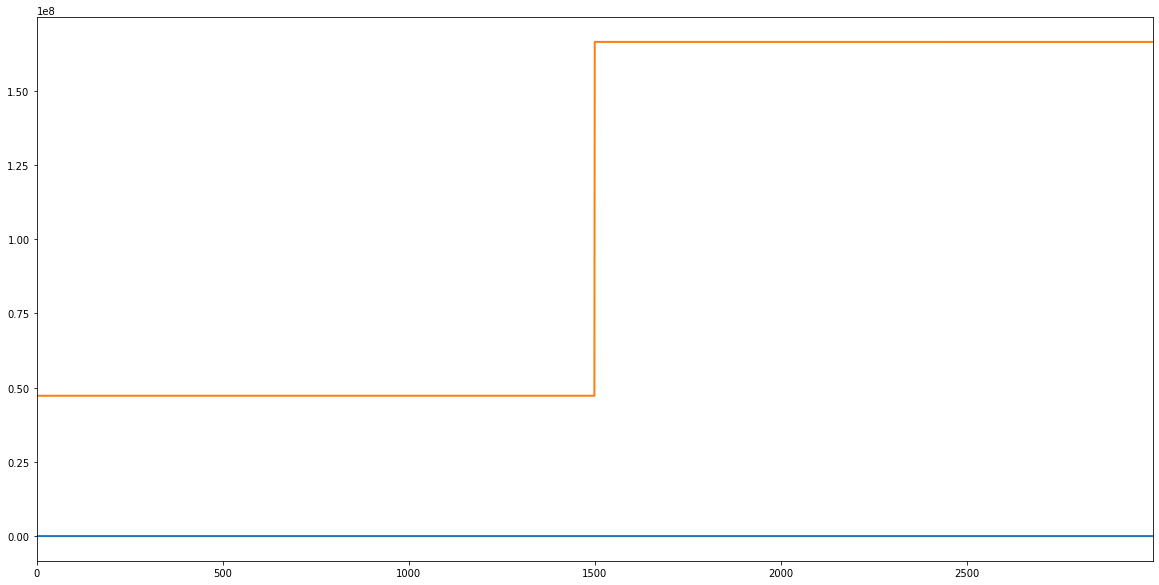

In [22]:
model.save('stacked_model.h5')
#model = load_model('stacked_model.h5')
print(len_data_set)
pd.Series(loss).plot(figsize=(20,10),lw=2)
pd.Series(val_loss).plot(figsize=(20,10),lw=2)



In [26]:
#dict_data=Split_by_companiesANDcontinuosTime(df.loc[:,~df.columns.str.contains('volume')],time_min=105)
#data_dict=pd.DataFrame(dict_data).T.to_dict()
#list_data=list(data_dict.values())
#train_dataSet,test_dataSet= Create_TrainTest_FromListOfSample(list_sample=list_data,delay=5,scaler_y_test=False)

m=   3







predict_1=model.predict([dictionary['X'] for dictionary in test_dataSet[m].values()],batch_size=batch_size)
real_test_1=[dictionary['Y'] for dictionary in test_dataSet[m].values()]
model.reset_states()

scalers=[[scaler for scaler in dict_scaler['Scalers_Y'].values()] for dict_scaler in test_dataSet[m].values()]
#scalers=[[scaler for scaler in dict_scaler['Scalers_Y'].values()] for dict_scaler in train_dataSet[0].values()]

predict=[np.stack([scaler.inverse_transform(pred[:,i].reshape(len(pred),1)) for i,scaler in enumerate(scal)],axis=1).squeeze() for pred,scal in zip(predict_1,scalers)]
#real_test_1=[np.stack([scaler.inverse_transform(pred[:,i].reshape(len(pred),1)) for i,scaler in enumerate(scal)],axis=1).squeeze() for pred,scal in zip(predict_1,scalers)]

0.46418338108882523
0.4269340974212034
0.47564469914040114


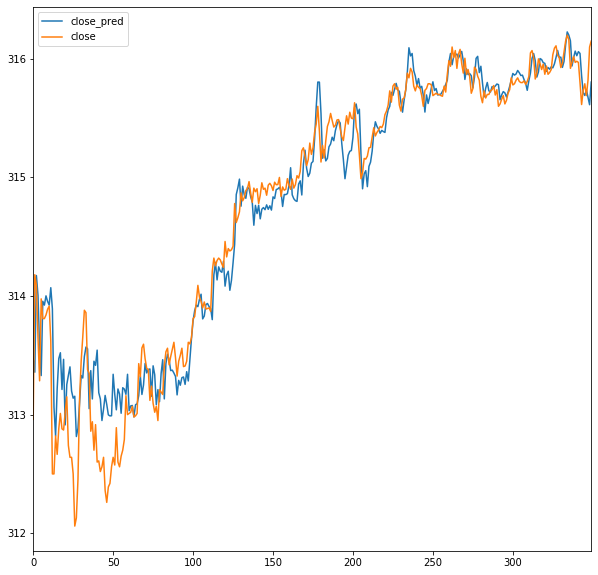

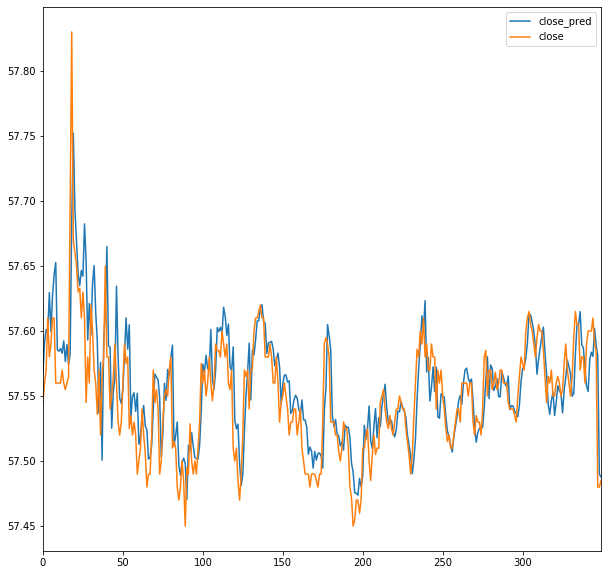

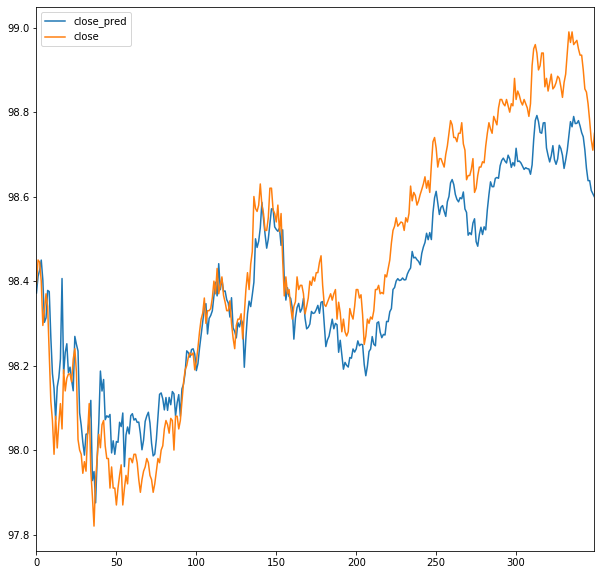

In [27]:
for i in zip(predict,real_test_1):
    fg,ax=plt.subplots(figsize=(10,10))
    df_pred=pd.DataFrame(i[0],columns=['open_pred','high_pred','low_pred','close_pred','volume_pred'])
    df_real=pd.DataFrame(i[1],columns=['open','high','low','close','volume'])
    df_pred['close_pred'].plot(ax=ax,legend='close_pred')
    df_real['close'].plot(ax=ax,legend='close_real')
    
    print((df_pred['close_pred'].diff().dropna()*df_real['close'].diff().dropna()>0).mean())

True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Normalizando
True
Norma

Genral:  0 , Fitting example 36
Epoch 1/1
100/100 [==============================] - 0s 206us/step - loss: 3.6291 - dense_22_loss: 0.1034 - dense_23_loss: 0.0503 - dense_24_loss: 0.0536
Genral:  0 , Fitting example 37
Epoch 1/1
100/100 [==============================] - 0s 211us/step - loss: 3.6182 - dense_22_loss: 0.1015 - dense_23_loss: 0.0486 - dense_24_loss: 0.0520
Genral:  0 , Fitting example 38
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 3.6075 - dense_22_loss: 0.0997 - dense_23_loss: 0.0470 - dense_24_loss: 0.0505
Genral:  0 , Fitting example 39
Epoch 1/1
100/100 [==============================] - 0s 205us/step - loss: 3.5972 - dense_22_loss: 0.0981 - dense_23_loss: 0.0456 - dense_24_loss: 0.0490
Genral:  0 , Fitting example 40
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 3.5874 - dense_22_loss: 0.0967 - dense_23_loss: 0.0443 - dense_24_loss: 0.0475
Genral:  0 , Fitting example 41
Epoch 1/1
100/100 [===================

Genral:  0 , Fitting example 81
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 3.2861 - dense_22_loss: 0.0564 - dense_23_loss: 0.0210 - dense_24_loss: 0.0294
Genral:  0 , Fitting example 82
Epoch 1/1
100/100 [==============================] - 0s 220us/step - loss: 3.2799 - dense_22_loss: 0.0557 - dense_23_loss: 0.0206 - dense_24_loss: 0.0292
Genral:  0 , Fitting example 83
Epoch 1/1
100/100 [==============================] - 0s 246us/step - loss: 3.2736 - dense_22_loss: 0.0551 - dense_23_loss: 0.0202 - dense_24_loss: 0.0291
Genral:  0 , Fitting example 84
Epoch 1/1
100/100 [==============================] - 0s 127us/step - loss: 3.2673 - dense_22_loss: 0.0544 - dense_23_loss: 0.0199 - dense_24_loss: 0.0290
Genral:  0 , Fitting example 85
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 3.2612 - dense_22_loss: 0.0538 - dense_23_loss: 0.0196 - dense_24_loss: 0.0288
Genral:  0 , Fitting example 86
Epoch 1/1
100/100 [===================

Genral:  0 , Fitting example 125
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 3.0312 - dense_22_loss: 0.0352 - dense_23_loss: 0.0123 - dense_24_loss: 0.0228
Genral:  0 , Fitting example 126
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 3.0259 - dense_22_loss: 0.0349 - dense_23_loss: 0.0122 - dense_24_loss: 0.0226
Genral:  0 , Fitting example 127
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 3.0205 - dense_22_loss: 0.0346 - dense_23_loss: 0.0121 - dense_24_loss: 0.0225
Genral:  0 , Fitting example 128
Epoch 1/1
100/100 [==============================] - 0s 190us/step - loss: 3.0152 - dense_22_loss: 0.0343 - dense_23_loss: 0.0120 - dense_24_loss: 0.0224
Genral:  0 , Fitting example 129
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 3.0099 - dense_22_loss: 0.0341 - dense_23_loss: 0.0119 - dense_24_loss: 0.0222
Genral:  0 , Fitting example 130
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 169
Epoch 1/1
100/100 [==============================] - 0s 125us/step - loss: 2.8090 - dense_22_loss: 0.0275 - dense_23_loss: 0.0095 - dense_24_loss: 0.0180
Genral:  0 , Fitting example 170
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 2.8042 - dense_22_loss: 0.0274 - dense_23_loss: 0.0095 - dense_24_loss: 0.0180
Genral:  0 , Fitting example 171
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 2.7994 - dense_22_loss: 0.0273 - dense_23_loss: 0.0095 - dense_24_loss: 0.0179
Genral:  0 , Fitting example 172
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 2.7947 - dense_22_loss: 0.0273 - dense_23_loss: 0.0094 - dense_24_loss: 0.0178
Genral:  0 , Fitting example 173
Epoch 1/1
100/100 [==============================] - 0s 141us/step - loss: 2.7899 - dense_22_loss: 0.0272 - dense_23_loss: 0.0094 - dense_24_loss: 0.0177
Genral:  0 , Fitting example 174
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 213
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 2.6055 - dense_22_loss: 0.0251 - dense_23_loss: 0.0083 - dense_24_loss: 0.0152
Genral:  0 , Fitting example 214
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 2.6010 - dense_22_loss: 0.0250 - dense_23_loss: 0.0083 - dense_24_loss: 0.0151
Genral:  0 , Fitting example 215
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 2.5965 - dense_22_loss: 0.0250 - dense_23_loss: 0.0083 - dense_24_loss: 0.0151
Genral:  0 , Fitting example 216
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 2.5921 - dense_22_loss: 0.0249 - dense_23_loss: 0.0083 - dense_24_loss: 0.0150
Genral:  0 , Fitting example 217
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 2.5876 - dense_22_loss: 0.0249 - dense_23_loss: 0.0083 - dense_24_loss: 0.0150
Genral:  0 , Fitting example 218
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 257
Epoch 1/1
100/100 [==============================] - 0s 213us/step - loss: 2.4135 - dense_22_loss: 0.0233 - dense_23_loss: 0.0075 - dense_24_loss: 0.0133
Genral:  0 , Fitting example 258
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 2.4092 - dense_22_loss: 0.0233 - dense_23_loss: 0.0075 - dense_24_loss: 0.0133
Genral:  0 , Fitting example 259
Epoch 1/1
100/100 [==============================] - 0s 206us/step - loss: 2.4050 - dense_22_loss: 0.0232 - dense_23_loss: 0.0075 - dense_24_loss: 0.0133
Genral:  0 , Fitting example 260
Epoch 1/1
100/100 [==============================] - 0s 187us/step - loss: 2.4008 - dense_22_loss: 0.0232 - dense_23_loss: 0.0074 - dense_24_loss: 0.0132
Genral:  0 , Fitting example 261
Epoch 1/1
100/100 [==============================] - 0s 221us/step - loss: 2.3965 - dense_22_loss: 0.0232 - dense_23_loss: 0.0074 - dense_24_loss: 0.0132
Genral:  0 , Fitting example 262
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 301
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 2.2319 - dense_22_loss: 0.0219 - dense_23_loss: 0.0070 - dense_24_loss: 0.0122
Genral:  0 , Fitting example 302
Epoch 1/1
100/100 [==============================] - 0s 204us/step - loss: 2.2279 - dense_22_loss: 0.0218 - dense_23_loss: 0.0069 - dense_24_loss: 0.0122
Genral:  0 , Fitting example 303
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 2.2239 - dense_22_loss: 0.0218 - dense_23_loss: 0.0069 - dense_24_loss: 0.0122
Genral:  0 , Fitting example 304
Epoch 1/1
100/100 [==============================] - 0s 214us/step - loss: 2.2198 - dense_22_loss: 0.0218 - dense_23_loss: 0.0069 - dense_24_loss: 0.0122
Genral:  0 , Fitting example 305
Epoch 1/1
100/100 [==============================] - 0s 215us/step - loss: 2.2159 - dense_22_loss: 0.0218 - dense_23_loss: 0.0069 - dense_24_loss: 0.0121
Genral:  0 , Fitting example 306
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 345
Epoch 1/1
100/100 [==============================] - 0s 263us/step - loss: 2.0597 - dense_22_loss: 0.0208 - dense_23_loss: 0.0066 - dense_24_loss: 0.0115
Genral:  0 , Fitting example 346
Epoch 1/1
100/100 [==============================] - 0s 192us/step - loss: 2.0560 - dense_22_loss: 0.0207 - dense_23_loss: 0.0066 - dense_24_loss: 0.0114
Genral:  0 , Fitting example 347
Epoch 1/1
100/100 [==============================] - 0s 141us/step - loss: 2.0521 - dense_22_loss: 0.0207 - dense_23_loss: 0.0066 - dense_24_loss: 0.0114
Genral:  0 , Fitting example 348
Epoch 1/1
100/100 [==============================] - 0s 209us/step - loss: 2.0483 - dense_22_loss: 0.0207 - dense_23_loss: 0.0065 - dense_24_loss: 0.0114
Genral:  0 , Fitting example 349
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 2.0445 - dense_22_loss: 0.0207 - dense_23_loss: 0.0065 - dense_24_loss: 0.0114
Genral:  0 , Fitting example 350
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 389
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 1.8963 - dense_22_loss: 0.0198 - dense_23_loss: 0.0062 - dense_24_loss: 0.0108
Genral:  0 , Fitting example 390
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 1.8927 - dense_22_loss: 0.0198 - dense_23_loss: 0.0062 - dense_24_loss: 0.0108
Genral:  0 , Fitting example 391
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 1.8891 - dense_22_loss: 0.0197 - dense_23_loss: 0.0062 - dense_24_loss: 0.0108
Genral:  0 , Fitting example 392
Epoch 1/1
100/100 [==============================] - 0s 178us/step - loss: 1.8855 - dense_22_loss: 0.0197 - dense_23_loss: 0.0062 - dense_24_loss: 0.0108
Genral:  0 , Fitting example 393
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 1.8819 - dense_22_loss: 0.0197 - dense_23_loss: 0.0062 - dense_24_loss: 0.0108
Genral:  0 , Fitting example 394
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 433
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 1.7410 - dense_22_loss: 0.0187 - dense_23_loss: 0.0059 - dense_24_loss: 0.0103
Genral:  0 , Fitting example 434
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 1.7376 - dense_22_loss: 0.0186 - dense_23_loss: 0.0059 - dense_24_loss: 0.0103
Genral:  0 , Fitting example 435
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 1.7341 - dense_22_loss: 0.0186 - dense_23_loss: 0.0059 - dense_24_loss: 0.0102
Genral:  0 , Fitting example 436
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 1.7307 - dense_22_loss: 0.0186 - dense_23_loss: 0.0059 - dense_24_loss: 0.0102
Genral:  0 , Fitting example 437
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 1.7273 - dense_22_loss: 0.0186 - dense_23_loss: 0.0059 - dense_24_loss: 0.0102
Genral:  0 , Fitting example 438
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 477
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 1.5933 - dense_22_loss: 0.0174 - dense_23_loss: 0.0056 - dense_24_loss: 0.0097
Genral:  0 , Fitting example 478
Epoch 1/1
100/100 [==============================] - 0s 195us/step - loss: 1.5901 - dense_22_loss: 0.0174 - dense_23_loss: 0.0056 - dense_24_loss: 0.0097
Genral:  0 , Fitting example 479
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 1.5868 - dense_22_loss: 0.0173 - dense_23_loss: 0.0056 - dense_24_loss: 0.0097
Genral:  0 , Fitting example 480
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 1.5836 - dense_22_loss: 0.0173 - dense_23_loss: 0.0056 - dense_24_loss: 0.0097
Genral:  0 , Fitting example 481
Epoch 1/1
100/100 [==============================] - 0s 191us/step - loss: 1.5803 - dense_22_loss: 0.0173 - dense_23_loss: 0.0056 - dense_24_loss: 0.0096
Genral:  0 , Fitting example 482
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 521
Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 1.4530 - dense_22_loss: 0.0158 - dense_23_loss: 0.0054 - dense_24_loss: 0.0091
Genral:  0 , Fitting example 522
Epoch 1/1
100/100 [==============================] - 0s 246us/step - loss: 1.4499 - dense_22_loss: 0.0158 - dense_23_loss: 0.0054 - dense_24_loss: 0.0091
Genral:  0 , Fitting example 523
Epoch 1/1
100/100 [==============================] - 0s 122us/step - loss: 1.4469 - dense_22_loss: 0.0157 - dense_23_loss: 0.0054 - dense_24_loss: 0.0091
Genral:  0 , Fitting example 524
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 1.4437 - dense_22_loss: 0.0157 - dense_23_loss: 0.0054 - dense_24_loss: 0.0091
Genral:  0 , Fitting example 525
Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 1.4406 - dense_22_loss: 0.0157 - dense_23_loss: 0.0054 - dense_24_loss: 0.0091
Genral:  0 , Fitting example 526
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 565
Epoch 1/1
100/100 [==============================] - 0s 120us/step - loss: 1.3194 - dense_22_loss: 0.0136 - dense_23_loss: 0.0052 - dense_24_loss: 0.0085
Genral:  0 , Fitting example 566
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 1.3165 - dense_22_loss: 0.0136 - dense_23_loss: 0.0052 - dense_24_loss: 0.0085
Genral:  0 , Fitting example 567
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 1.3135 - dense_22_loss: 0.0135 - dense_23_loss: 0.0052 - dense_24_loss: 0.0085
Genral:  0 , Fitting example 568
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 1.3106 - dense_22_loss: 0.0134 - dense_23_loss: 0.0052 - dense_24_loss: 0.0085
Genral:  0 , Fitting example 569
Epoch 1/1
100/100 [==============================] - 0s 191us/step - loss: 1.3076 - dense_22_loss: 0.0134 - dense_23_loss: 0.0052 - dense_24_loss: 0.0085
Genral:  0 , Fitting example 570
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 609
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 1.1924 - dense_22_loss: 0.0109 - dense_23_loss: 0.0050 - dense_24_loss: 0.0080
Genral:  0 , Fitting example 610
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 1.1896 - dense_22_loss: 0.0108 - dense_23_loss: 0.0050 - dense_24_loss: 0.0080
Genral:  0 , Fitting example 611
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 1.1868 - dense_22_loss: 0.0108 - dense_23_loss: 0.0050 - dense_24_loss: 0.0080
Genral:  0 , Fitting example 612
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 1.1841 - dense_22_loss: 0.0108 - dense_23_loss: 0.0050 - dense_24_loss: 0.0080
Genral:  0 , Fitting example 613
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 1.1813 - dense_22_loss: 0.0107 - dense_23_loss: 0.0050 - dense_24_loss: 0.0079
Genral:  0 , Fitting example 614
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 653
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 1.0732 - dense_22_loss: 0.0091 - dense_23_loss: 0.0049 - dense_24_loss: 0.0075
Genral:  0 , Fitting example 654
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 1.0705 - dense_22_loss: 0.0090 - dense_23_loss: 0.0049 - dense_24_loss: 0.0075
Genral:  0 , Fitting example 655
Epoch 1/1
100/100 [==============================] - 0s 141us/step - loss: 1.0679 - dense_22_loss: 0.0090 - dense_23_loss: 0.0049 - dense_24_loss: 0.0075
Genral:  0 , Fitting example 656
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 1.0652 - dense_22_loss: 0.0089 - dense_23_loss: 0.0049 - dense_24_loss: 0.0075
Genral:  0 , Fitting example 657
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 1.0626 - dense_22_loss: 0.0089 - dense_23_loss: 0.0049 - dense_24_loss: 0.0075
Genral:  0 , Fitting example 658
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 697
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.9609 - dense_22_loss: 0.0077 - dense_23_loss: 0.0048 - dense_24_loss: 0.0071
Genral:  0 , Fitting example 698
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.9585 - dense_22_loss: 0.0077 - dense_23_loss: 0.0048 - dense_24_loss: 0.0071
Genral:  0 , Fitting example 699
Epoch 1/1
100/100 [==============================] - 0s 137us/step - loss: 0.9561 - dense_22_loss: 0.0077 - dense_23_loss: 0.0048 - dense_24_loss: 0.0071
Genral:  0 , Fitting example 700
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.9536 - dense_22_loss: 0.0077 - dense_23_loss: 0.0048 - dense_24_loss: 0.0070
Genral:  0 , Fitting example 701
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.9512 - dense_22_loss: 0.0077 - dense_23_loss: 0.0048 - dense_24_loss: 0.0070
Genral:  0 , Fitting example 702
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 741
Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 0.8555 - dense_22_loss: 0.0068 - dense_23_loss: 0.0047 - dense_24_loss: 0.0067
Genral:  0 , Fitting example 742
Epoch 1/1
100/100 [==============================] - 0s 175us/step - loss: 0.8533 - dense_22_loss: 0.0069 - dense_23_loss: 0.0047 - dense_24_loss: 0.0067
Genral:  0 , Fitting example 743
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.8511 - dense_22_loss: 0.0070 - dense_23_loss: 0.0047 - dense_24_loss: 0.0067
Genral:  0 , Fitting example 744
Epoch 1/1
100/100 [==============================] - 0s 240us/step - loss: 0.8488 - dense_22_loss: 0.0069 - dense_23_loss: 0.0047 - dense_24_loss: 0.0066
Genral:  0 , Fitting example 745
Epoch 1/1
100/100 [==============================] - 0s 198us/step - loss: 0.8463 - dense_22_loss: 0.0067 - dense_23_loss: 0.0047 - dense_24_loss: 0.0066
Genral:  0 , Fitting example 746
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 785
Epoch 1/1
100/100 [==============================] - 0s 208us/step - loss: 0.7564 - dense_22_loss: 0.0060 - dense_23_loss: 0.0046 - dense_24_loss: 0.0063
Genral:  0 , Fitting example 786
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.7542 - dense_22_loss: 0.0061 - dense_23_loss: 0.0046 - dense_24_loss: 0.0063
Genral:  0 , Fitting example 787
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.7520 - dense_22_loss: 0.0061 - dense_23_loss: 0.0046 - dense_24_loss: 0.0063
Genral:  0 , Fitting example 788
Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.7499 - dense_22_loss: 0.0061 - dense_23_loss: 0.0046 - dense_24_loss: 0.0063
Genral:  0 , Fitting example 789
Epoch 1/1
100/100 [==============================] - 0s 231us/step - loss: 0.7477 - dense_22_loss: 0.0061 - dense_23_loss: 0.0046 - dense_24_loss: 0.0063
Genral:  0 , Fitting example 790
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 829
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.6631 - dense_22_loss: 0.0054 - dense_23_loss: 0.0045 - dense_24_loss: 0.0059
Genral:  0 , Fitting example 830
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.6612 - dense_22_loss: 0.0054 - dense_23_loss: 0.0045 - dense_24_loss: 0.0059
Genral:  0 , Fitting example 831
Epoch 1/1
100/100 [==============================] - 0s 209us/step - loss: 0.6591 - dense_22_loss: 0.0054 - dense_23_loss: 0.0045 - dense_24_loss: 0.0059
Genral:  0 , Fitting example 832
Epoch 1/1
100/100 [==============================] - 0s 222us/step - loss: 0.6570 - dense_22_loss: 0.0053 - dense_23_loss: 0.0045 - dense_24_loss: 0.0059
Genral:  0 , Fitting example 833
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.6549 - dense_22_loss: 0.0053 - dense_23_loss: 0.0045 - dense_24_loss: 0.0059
Genral:  0 , Fitting example 834
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 873
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.5756 - dense_22_loss: 0.0048 - dense_23_loss: 0.0045 - dense_24_loss: 0.0056
Genral:  0 , Fitting example 874
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.5737 - dense_22_loss: 0.0048 - dense_23_loss: 0.0045 - dense_24_loss: 0.0056
Genral:  0 , Fitting example 875
Epoch 1/1
100/100 [==============================] - 0s 181us/step - loss: 0.5718 - dense_22_loss: 0.0048 - dense_23_loss: 0.0045 - dense_24_loss: 0.0056
Genral:  0 , Fitting example 876
Epoch 1/1
100/100 [==============================] - 0s 210us/step - loss: 0.5699 - dense_22_loss: 0.0049 - dense_23_loss: 0.0044 - dense_24_loss: 0.0056
Genral:  0 , Fitting example 877
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.5680 - dense_22_loss: 0.0048 - dense_23_loss: 0.0044 - dense_24_loss: 0.0056
Genral:  0 , Fitting example 878
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 917
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.4937 - dense_22_loss: 0.0046 - dense_23_loss: 0.0044 - dense_24_loss: 0.0053
Genral:  0 , Fitting example 918
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.4919 - dense_22_loss: 0.0046 - dense_23_loss: 0.0044 - dense_24_loss: 0.0053
Genral:  0 , Fitting example 919
Epoch 1/1
100/100 [==============================] - 0s 140us/step - loss: 0.4899 - dense_22_loss: 0.0044 - dense_23_loss: 0.0044 - dense_24_loss: 0.0053
Genral:  0 , Fitting example 920
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.4881 - dense_22_loss: 0.0044 - dense_23_loss: 0.0044 - dense_24_loss: 0.0053
Genral:  0 , Fitting example 921
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.4864 - dense_22_loss: 0.0045 - dense_23_loss: 0.0044 - dense_24_loss: 0.0053
Genral:  0 , Fitting example 922
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 961
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.4167 - dense_22_loss: 0.0041 - dense_23_loss: 0.0043 - dense_24_loss: 0.0050
Genral:  0 , Fitting example 962
Epoch 1/1
100/100 [==============================] - 0s 134us/step - loss: 0.4150 - dense_22_loss: 0.0041 - dense_23_loss: 0.0043 - dense_24_loss: 0.0050
Genral:  0 , Fitting example 963
Epoch 1/1
100/100 [==============================] - 0s 209us/step - loss: 0.4133 - dense_22_loss: 0.0041 - dense_23_loss: 0.0043 - dense_24_loss: 0.0050
Genral:  0 , Fitting example 964
Epoch 1/1
100/100 [==============================] - 0s 179us/step - loss: 0.4117 - dense_22_loss: 0.0041 - dense_23_loss: 0.0043 - dense_24_loss: 0.0050
Genral:  0 , Fitting example 965
Epoch 1/1
100/100 [==============================] - 0s 214us/step - loss: 0.4100 - dense_22_loss: 0.0041 - dense_23_loss: 0.0043 - dense_24_loss: 0.0050
Genral:  0 , Fitting example 966
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 1005
Epoch 1/1
100/100 [==============================] - 0s 213us/step - loss: 0.3448 - dense_22_loss: 0.0038 - dense_23_loss: 0.0043 - dense_24_loss: 0.0047
Genral:  0 , Fitting example 1006
Epoch 1/1
100/100 [==============================] - 0s 238us/step - loss: 0.3432 - dense_22_loss: 0.0038 - dense_23_loss: 0.0043 - dense_24_loss: 0.0047
Genral:  0 , Fitting example 1007
Epoch 1/1
100/100 [==============================] - 0s 230us/step - loss: 0.3417 - dense_22_loss: 0.0039 - dense_23_loss: 0.0043 - dense_24_loss: 0.0047
Genral:  0 , Fitting example 1008
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.3401 - dense_22_loss: 0.0038 - dense_23_loss: 0.0043 - dense_24_loss: 0.0047
Genral:  0 , Fitting example 1009
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.3385 - dense_22_loss: 0.0038 - dense_23_loss: 0.0043 - dense_24_loss: 0.0047
Genral:  0 , Fitting example 1010
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1049
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.2779 - dense_22_loss: 0.0037 - dense_23_loss: 0.0042 - dense_24_loss: 0.0044
Genral:  0 , Fitting example 1050
Epoch 1/1
100/100 [==============================] - 0s 203us/step - loss: 0.2763 - dense_22_loss: 0.0036 - dense_23_loss: 0.0042 - dense_24_loss: 0.0044
Genral:  0 , Fitting example 1051
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.2748 - dense_22_loss: 0.0035 - dense_23_loss: 0.0042 - dense_24_loss: 0.0044
Genral:  0 , Fitting example 1052
Epoch 1/1
100/100 [==============================] - 0s 140us/step - loss: 0.2734 - dense_22_loss: 0.0036 - dense_23_loss: 0.0042 - dense_24_loss: 0.0044
Genral:  0 , Fitting example 1053
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.2719 - dense_22_loss: 0.0036 - dense_23_loss: 0.0042 - dense_24_loss: 0.0044
Genral:  0 , Fitting example 1054
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1093
Epoch 1/1
100/100 [==============================] - 0s 222us/step - loss: 0.2152 - dense_22_loss: 0.0033 - dense_23_loss: 0.0042 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 1094
Epoch 1/1
100/100 [==============================] - 0s 136us/step - loss: 0.2138 - dense_22_loss: 0.0033 - dense_23_loss: 0.0041 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 1095
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.2124 - dense_22_loss: 0.0033 - dense_23_loss: 0.0041 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 1096
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.2110 - dense_22_loss: 0.0033 - dense_23_loss: 0.0041 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 1097
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.2097 - dense_22_loss: 0.0033 - dense_23_loss: 0.0041 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 1098
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1137
Epoch 1/1
100/100 [==============================] - 0s 222us/step - loss: 0.1569 - dense_22_loss: 0.0032 - dense_23_loss: 0.0041 - dense_24_loss: 0.0040
Genral:  0 , Fitting example 1138
Epoch 1/1
100/100 [==============================] - 0s 247us/step - loss: 0.1557 - dense_22_loss: 0.0031 - dense_23_loss: 0.0041 - dense_24_loss: 0.0040
Genral:  0 , Fitting example 1139
Epoch 1/1
100/100 [==============================] - 0s 219us/step - loss: 0.1544 - dense_22_loss: 0.0032 - dense_23_loss: 0.0041 - dense_24_loss: 0.0040
Genral:  0 , Fitting example 1140
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.1531 - dense_22_loss: 0.0031 - dense_23_loss: 0.0041 - dense_24_loss: 0.0040
Genral:  0 , Fitting example 1141
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.1518 - dense_22_loss: 0.0031 - dense_23_loss: 0.0041 - dense_24_loss: 0.0040
Genral:  0 , Fitting example 1142
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1181
Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.1028 - dense_22_loss: 0.0030 - dense_23_loss: 0.0040 - dense_24_loss: 0.0039
Genral:  0 , Fitting example 1182
Epoch 1/1
100/100 [==============================] - 0s 211us/step - loss: 0.1016 - dense_22_loss: 0.0030 - dense_23_loss: 0.0040 - dense_24_loss: 0.0039
Genral:  0 , Fitting example 1183
Epoch 1/1
100/100 [==============================] - 0s 192us/step - loss: 0.1005 - dense_22_loss: 0.0030 - dense_23_loss: 0.0041 - dense_24_loss: 0.0039
Genral:  0 , Fitting example 1184
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0994 - dense_22_loss: 0.0031 - dense_23_loss: 0.0040 - dense_24_loss: 0.0039
Genral:  0 , Fitting example 1185
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0983 - dense_22_loss: 0.0032 - dense_23_loss: 0.0040 - dense_24_loss: 0.0039
Genral:  0 , Fitting example 1186
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1225
Epoch 1/1
100/100 [==============================] - 0s 173us/step - loss: 0.0527 - dense_22_loss: 0.0029 - dense_23_loss: 0.0040 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 1226
Epoch 1/1
100/100 [==============================] - 0s 181us/step - loss: 0.0516 - dense_22_loss: 0.0028 - dense_23_loss: 0.0040 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 1227
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0504 - dense_22_loss: 0.0028 - dense_23_loss: 0.0040 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 1228
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0493 - dense_22_loss: 0.0028 - dense_23_loss: 0.0040 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 1229
Epoch 1/1
100/100 [==============================] - 0s 179us/step - loss: 0.0482 - dense_22_loss: 0.0028 - dense_23_loss: 0.0040 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 1230
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1269
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0129 - dense_22_loss: 0.0027 - dense_23_loss: 0.0039 - dense_24_loss: 0.0035
Genral:  0 , Fitting example 1270
Epoch 1/1
100/100 [==============================] - 0s 214us/step - loss: 0.0129 - dense_22_loss: 0.0027 - dense_23_loss: 0.0039 - dense_24_loss: 0.0035
Genral:  0 , Fitting example 1271
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0129 - dense_22_loss: 0.0027 - dense_23_loss: 0.0039 - dense_24_loss: 0.0035
Genral:  0 , Fitting example 1272
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0130 - dense_22_loss: 0.0027 - dense_23_loss: 0.0039 - dense_24_loss: 0.0035
Genral:  0 , Fitting example 1273
Epoch 1/1
100/100 [==============================] - 0s 138us/step - loss: 0.0129 - dense_22_loss: 0.0027 - dense_23_loss: 0.0039 - dense_24_loss: 0.0035
Genral:  0 , Fitting example 1274
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1313
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 0.0105 - dense_22_loss: 0.0026 - dense_23_loss: 0.0039 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 1314
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0105 - dense_22_loss: 0.0025 - dense_23_loss: 0.0039 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 1315
Epoch 1/1
100/100 [==============================] - 0s 253us/step - loss: 0.0105 - dense_22_loss: 0.0025 - dense_23_loss: 0.0039 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 1316
Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0105 - dense_22_loss: 0.0026 - dense_23_loss: 0.0039 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 1317
Epoch 1/1
100/100 [==============================] - 0s 130us/step - loss: 0.0105 - dense_22_loss: 0.0026 - dense_23_loss: 0.0039 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 1318
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1357
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0101 - dense_22_loss: 0.0024 - dense_23_loss: 0.0038 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 1358
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0101 - dense_22_loss: 0.0024 - dense_23_loss: 0.0038 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 1359
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0101 - dense_22_loss: 0.0024 - dense_23_loss: 0.0038 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 1360
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0101 - dense_22_loss: 0.0024 - dense_23_loss: 0.0038 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 1361
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0100 - dense_22_loss: 0.0024 - dense_23_loss: 0.0038 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 1362
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1401
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0098 - dense_22_loss: 0.0024 - dense_23_loss: 0.0038 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 1402
Epoch 1/1
100/100 [==============================] - 0s 207us/step - loss: 0.0099 - dense_22_loss: 0.0024 - dense_23_loss: 0.0038 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 1403
Epoch 1/1
100/100 [==============================] - 0s 123us/step - loss: 0.0100 - dense_22_loss: 0.0026 - dense_23_loss: 0.0038 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 1404
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0100 - dense_22_loss: 0.0026 - dense_23_loss: 0.0038 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 1405
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0098 - dense_22_loss: 0.0024 - dense_23_loss: 0.0038 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 1406
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1445
Epoch 1/1
100/100 [==============================] - 0s 199us/step - loss: 0.0094 - dense_22_loss: 0.0022 - dense_23_loss: 0.0037 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 1446
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0094 - dense_22_loss: 0.0022 - dense_23_loss: 0.0037 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 1447
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0094 - dense_22_loss: 0.0022 - dense_23_loss: 0.0037 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 1448
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0094 - dense_22_loss: 0.0022 - dense_23_loss: 0.0037 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 1449
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0094 - dense_22_loss: 0.0022 - dense_23_loss: 0.0037 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 1450
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 1489
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0091 - dense_22_loss: 0.0021 - dense_23_loss: 0.0037 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1490
Epoch 1/1
100/100 [==============================] - 0s 216us/step - loss: 0.0091 - dense_22_loss: 0.0021 - dense_23_loss: 0.0037 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1491
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 0.0091 - dense_22_loss: 0.0021 - dense_23_loss: 0.0037 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1492
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0090 - dense_22_loss: 0.0021 - dense_23_loss: 0.0037 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1493
Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0091 - dense_22_loss: 0.0021 - dense_23_loss: 0.0037 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1494
Epoch 1/1
100/100 [=======

Genral:  0 , Fitting example 33
Epoch 1/1
100/100 [==============================] - 0s 206us/step - loss: 0.0804 - dense_22_loss: 0.0168 - dense_23_loss: 0.0323 - dense_24_loss: 0.0272
Genral:  0 , Fitting example 34
Epoch 1/1
100/100 [==============================] - 0s 249us/step - loss: 0.0792 - dense_22_loss: 0.0165 - dense_23_loss: 0.0320 - dense_24_loss: 0.0266
Genral:  0 , Fitting example 35
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0781 - dense_22_loss: 0.0162 - dense_23_loss: 0.0317 - dense_24_loss: 0.0260
Genral:  0 , Fitting example 36
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0770 - dense_22_loss: 0.0160 - dense_23_loss: 0.0314 - dense_24_loss: 0.0255
Genral:  0 , Fitting example 37
Epoch 1/1
100/100 [==============================] - 0s 189us/step - loss: 0.0760 - dense_22_loss: 0.0157 - dense_23_loss: 0.0312 - dense_24_loss: 0.0250
Genral:  0 , Fitting example 38
Epoch 1/1
100/100 [===================

Genral:  0 , Fitting example 78
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0529 - dense_22_loss: 0.0103 - dense_23_loss: 0.0237 - dense_24_loss: 0.0161
Genral:  0 , Fitting example 79
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0526 - dense_22_loss: 0.0102 - dense_23_loss: 0.0236 - dense_24_loss: 0.0160
Genral:  0 , Fitting example 80
Epoch 1/1
100/100 [==============================] - 0s 240us/step - loss: 0.0523 - dense_22_loss: 0.0102 - dense_23_loss: 0.0235 - dense_24_loss: 0.0159
Genral:  0 , Fitting example 81
Epoch 1/1
100/100 [==============================] - 0s 220us/step - loss: 0.0520 - dense_22_loss: 0.0101 - dense_23_loss: 0.0233 - dense_24_loss: 0.0158
Genral:  0 , Fitting example 82
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0517 - dense_22_loss: 0.0101 - dense_23_loss: 0.0232 - dense_24_loss: 0.0157
Genral:  0 , Fitting example 83
Epoch 1/1
100/100 [===================

Genral:  0 , Fitting example 122
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0425 - dense_22_loss: 0.0083 - dense_23_loss: 0.0192 - dense_24_loss: 0.0131
Genral:  0 , Fitting example 123
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0424 - dense_22_loss: 0.0083 - dense_23_loss: 0.0191 - dense_24_loss: 0.0130
Genral:  0 , Fitting example 124
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0422 - dense_22_loss: 0.0082 - dense_23_loss: 0.0190 - dense_24_loss: 0.0130
Genral:  0 , Fitting example 125
Epoch 1/1
100/100 [==============================] - 0s 240us/step - loss: 0.0420 - dense_22_loss: 0.0082 - dense_23_loss: 0.0190 - dense_24_loss: 0.0129
Genral:  0 , Fitting example 126
Epoch 1/1
100/100 [==============================] - 0s 191us/step - loss: 0.0419 - dense_22_loss: 0.0082 - dense_23_loss: 0.0189 - dense_24_loss: 0.0129
Genral:  0 , Fitting example 127
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 166
Epoch 1/1
100/100 [==============================] - 0s 219us/step - loss: 0.0359 - dense_22_loss: 0.0072 - dense_23_loss: 0.0160 - dense_24_loss: 0.0112
Genral:  0 , Fitting example 167
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0358 - dense_22_loss: 0.0072 - dense_23_loss: 0.0159 - dense_24_loss: 0.0112
Genral:  0 , Fitting example 168
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0357 - dense_22_loss: 0.0072 - dense_23_loss: 0.0159 - dense_24_loss: 0.0111
Genral:  0 , Fitting example 169
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0356 - dense_22_loss: 0.0071 - dense_23_loss: 0.0158 - dense_24_loss: 0.0111
Genral:  0 , Fitting example 170
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0354 - dense_22_loss: 0.0071 - dense_23_loss: 0.0157 - dense_24_loss: 0.0111
Genral:  0 , Fitting example 171
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 210
Epoch 1/1
100/100 [==============================] - 0s 198us/step - loss: 0.0311 - dense_22_loss: 0.0065 - dense_23_loss: 0.0134 - dense_24_loss: 0.0099
Genral:  0 , Fitting example 211
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0310 - dense_22_loss: 0.0065 - dense_23_loss: 0.0134 - dense_24_loss: 0.0099
Genral:  0 , Fitting example 212
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0309 - dense_22_loss: 0.0064 - dense_23_loss: 0.0133 - dense_24_loss: 0.0099
Genral:  0 , Fitting example 213
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0308 - dense_22_loss: 0.0064 - dense_23_loss: 0.0133 - dense_24_loss: 0.0098
Genral:  0 , Fitting example 214
Epoch 1/1
100/100 [==============================] - 0s 194us/step - loss: 0.0308 - dense_22_loss: 0.0064 - dense_23_loss: 0.0132 - dense_24_loss: 0.0098
Genral:  0 , Fitting example 215
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 254
Epoch 1/1
100/100 [==============================] - 0s 132us/step - loss: 0.0273 - dense_22_loss: 0.0059 - dense_23_loss: 0.0113 - dense_24_loss: 0.0090
Genral:  0 , Fitting example 255
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0272 - dense_22_loss: 0.0059 - dense_23_loss: 0.0112 - dense_24_loss: 0.0090
Genral:  0 , Fitting example 256
Epoch 1/1
100/100 [==============================] - 0s 214us/step - loss: 0.0271 - dense_22_loss: 0.0059 - dense_23_loss: 0.0112 - dense_24_loss: 0.0090
Genral:  0 , Fitting example 257
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0271 - dense_22_loss: 0.0059 - dense_23_loss: 0.0111 - dense_24_loss: 0.0090
Genral:  0 , Fitting example 258
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0270 - dense_22_loss: 0.0059 - dense_23_loss: 0.0111 - dense_24_loss: 0.0089
Genral:  0 , Fitting example 259
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 298
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0238 - dense_22_loss: 0.0054 - dense_23_loss: 0.0093 - dense_24_loss: 0.0083
Genral:  0 , Fitting example 299
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0238 - dense_22_loss: 0.0054 - dense_23_loss: 0.0092 - dense_24_loss: 0.0083
Genral:  0 , Fitting example 300
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0238 - dense_22_loss: 0.0054 - dense_23_loss: 0.0092 - dense_24_loss: 0.0082
Genral:  0 , Fitting example 301
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0237 - dense_22_loss: 0.0054 - dense_23_loss: 0.0092 - dense_24_loss: 0.0082
Genral:  0 , Fitting example 302
Epoch 1/1
100/100 [==============================] - 0s 183us/step - loss: 0.0236 - dense_22_loss: 0.0054 - dense_23_loss: 0.0091 - dense_24_loss: 0.0082
Genral:  0 , Fitting example 303
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 342
Epoch 1/1
100/100 [==============================] - 0s 207us/step - loss: 0.0207 - dense_22_loss: 0.0049 - dense_23_loss: 0.0074 - dense_24_loss: 0.0076
Genral:  0 , Fitting example 343
Epoch 1/1
100/100 [==============================] - 0s 196us/step - loss: 0.0206 - dense_22_loss: 0.0049 - dense_23_loss: 0.0074 - dense_24_loss: 0.0076
Genral:  0 , Fitting example 344
Epoch 1/1
100/100 [==============================] - 0s 206us/step - loss: 0.0206 - dense_22_loss: 0.0049 - dense_23_loss: 0.0073 - dense_24_loss: 0.0076
Genral:  0 , Fitting example 345
Epoch 1/1
100/100 [==============================] - 0s 141us/step - loss: 0.0205 - dense_22_loss: 0.0049 - dense_23_loss: 0.0073 - dense_24_loss: 0.0075
Genral:  0 , Fitting example 346
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0204 - dense_22_loss: 0.0048 - dense_23_loss: 0.0073 - dense_24_loss: 0.0075
Genral:  0 , Fitting example 347
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 386
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0177 - dense_22_loss: 0.0044 - dense_23_loss: 0.0056 - dense_24_loss: 0.0069
Genral:  0 , Fitting example 387
Epoch 1/1
100/100 [==============================] - 0s 206us/step - loss: 0.0176 - dense_22_loss: 0.0044 - dense_23_loss: 0.0056 - dense_24_loss: 0.0068
Genral:  0 , Fitting example 388
Epoch 1/1
100/100 [==============================] - 0s 130us/step - loss: 0.0176 - dense_22_loss: 0.0044 - dense_23_loss: 0.0055 - dense_24_loss: 0.0068
Genral:  0 , Fitting example 389
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0175 - dense_22_loss: 0.0044 - dense_23_loss: 0.0055 - dense_24_loss: 0.0068
Genral:  0 , Fitting example 390
Epoch 1/1
100/100 [==============================] - 0s 204us/step - loss: 0.0175 - dense_22_loss: 0.0044 - dense_23_loss: 0.0055 - dense_24_loss: 0.0068
Genral:  0 , Fitting example 391
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 430
Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0150 - dense_22_loss: 0.0040 - dense_23_loss: 0.0041 - dense_24_loss: 0.0061
Genral:  0 , Fitting example 431
Epoch 1/1
100/100 [==============================] - 0s 127us/step - loss: 0.0150 - dense_22_loss: 0.0040 - dense_23_loss: 0.0041 - dense_24_loss: 0.0061
Genral:  0 , Fitting example 432
Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 0.0149 - dense_22_loss: 0.0039 - dense_23_loss: 0.0040 - dense_24_loss: 0.0061
Genral:  0 , Fitting example 433
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0148 - dense_22_loss: 0.0039 - dense_23_loss: 0.0040 - dense_24_loss: 0.0061
Genral:  0 , Fitting example 434
Epoch 1/1
100/100 [==============================] - 0s 183us/step - loss: 0.0147 - dense_22_loss: 0.0039 - dense_23_loss: 0.0040 - dense_24_loss: 0.0061
Genral:  0 , Fitting example 435
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 474
Epoch 1/1
100/100 [==============================] - 0s 217us/step - loss: 0.0129 - dense_22_loss: 0.0036 - dense_23_loss: 0.0031 - dense_24_loss: 0.0054
Genral:  0 , Fitting example 475
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0129 - dense_22_loss: 0.0036 - dense_23_loss: 0.0030 - dense_24_loss: 0.0054
Genral:  0 , Fitting example 476
Epoch 1/1
100/100 [==============================] - 0s 192us/step - loss: 0.0128 - dense_22_loss: 0.0036 - dense_23_loss: 0.0030 - dense_24_loss: 0.0054
Genral:  0 , Fitting example 477
Epoch 1/1
100/100 [==============================] - 0s 214us/step - loss: 0.0128 - dense_22_loss: 0.0036 - dense_23_loss: 0.0030 - dense_24_loss: 0.0054
Genral:  0 , Fitting example 478
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0128 - dense_22_loss: 0.0036 - dense_23_loss: 0.0030 - dense_24_loss: 0.0054
Genral:  0 , Fitting example 479
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 518
Epoch 1/1
100/100 [==============================] - 0s 244us/step - loss: 0.0112 - dense_22_loss: 0.0033 - dense_23_loss: 0.0024 - dense_24_loss: 0.0048
Genral:  0 , Fitting example 519
Epoch 1/1
100/100 [==============================] - 0s 179us/step - loss: 0.0112 - dense_22_loss: 0.0032 - dense_23_loss: 0.0024 - dense_24_loss: 0.0048
Genral:  0 , Fitting example 520
Epoch 1/1
100/100 [==============================] - 0s 141us/step - loss: 0.0112 - dense_22_loss: 0.0032 - dense_23_loss: 0.0024 - dense_24_loss: 0.0048
Genral:  0 , Fitting example 521
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0112 - dense_22_loss: 0.0032 - dense_23_loss: 0.0024 - dense_24_loss: 0.0048
Genral:  0 , Fitting example 522
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0112 - dense_22_loss: 0.0032 - dense_23_loss: 0.0024 - dense_24_loss: 0.0047
Genral:  0 , Fitting example 523
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 562
Epoch 1/1
100/100 [==============================] - 0s 181us/step - loss: 0.0100 - dense_22_loss: 0.0030 - dense_23_loss: 0.0020 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 563
Epoch 1/1
100/100 [==============================] - 0s 187us/step - loss: 0.0100 - dense_22_loss: 0.0030 - dense_23_loss: 0.0020 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 564
Epoch 1/1
100/100 [==============================] - 0s 133us/step - loss: 0.0100 - dense_22_loss: 0.0030 - dense_23_loss: 0.0020 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 565
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0100 - dense_22_loss: 0.0030 - dense_23_loss: 0.0020 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 566
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0099 - dense_22_loss: 0.0030 - dense_23_loss: 0.0020 - dense_24_loss: 0.0042
Genral:  0 , Fitting example 567
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 606
Epoch 1/1
100/100 [==============================] - 0s 208us/step - loss: 0.0090 - dense_22_loss: 0.0028 - dense_23_loss: 0.0017 - dense_24_loss: 0.0038
Genral:  0 , Fitting example 607
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0090 - dense_22_loss: 0.0028 - dense_23_loss: 0.0017 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 608
Epoch 1/1
100/100 [==============================] - 0s 176us/step - loss: 0.0090 - dense_22_loss: 0.0028 - dense_23_loss: 0.0017 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 609
Epoch 1/1
100/100 [==============================] - 0s 245us/step - loss: 0.0090 - dense_22_loss: 0.0028 - dense_23_loss: 0.0017 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 610
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0090 - dense_22_loss: 0.0028 - dense_23_loss: 0.0016 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 611
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 650
Epoch 1/1
100/100 [==============================] - 0s 195us/step - loss: 0.0082 - dense_22_loss: 0.0027 - dense_23_loss: 0.0014 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 651
Epoch 1/1
100/100 [==============================] - 0s 172us/step - loss: 0.0081 - dense_22_loss: 0.0027 - dense_23_loss: 0.0014 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 652
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0081 - dense_22_loss: 0.0027 - dense_23_loss: 0.0014 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 653
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0081 - dense_22_loss: 0.0027 - dense_23_loss: 0.0014 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 654
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0081 - dense_22_loss: 0.0026 - dense_23_loss: 0.0014 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 655
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 694
Epoch 1/1
100/100 [==============================] - 0s 191us/step - loss: 0.0074 - dense_22_loss: 0.0025 - dense_23_loss: 0.0012 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 695
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0074 - dense_22_loss: 0.0025 - dense_23_loss: 0.0012 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 696
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0074 - dense_22_loss: 0.0025 - dense_23_loss: 0.0012 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 697
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0074 - dense_22_loss: 0.0025 - dense_23_loss: 0.0012 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 698
Epoch 1/1
100/100 [==============================] - 0s 218us/step - loss: 0.0074 - dense_22_loss: 0.0026 - dense_23_loss: 0.0012 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 699
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 738
Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 0.0069 - dense_22_loss: 0.0025 - dense_23_loss: 0.0010 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 739
Epoch 1/1
100/100 [==============================] - 0s 196us/step - loss: 0.0069 - dense_22_loss: 0.0026 - dense_23_loss: 0.0010 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 740
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0068 - dense_22_loss: 0.0025 - dense_23_loss: 0.0010 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 741
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0067 - dense_22_loss: 0.0024 - dense_23_loss: 0.0010 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 742
Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0068 - dense_22_loss: 0.0024 - dense_23_loss: 0.0010 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 743
Epoch 1/1
100/100 [=============

100/100 [==============================] - 0s 242us/step - loss: 0.0062 - dense_22_loss: 0.0023 - dense_23_loss: 8.8443e-04 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 782
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0062 - dense_22_loss: 0.0023 - dense_23_loss: 8.8150e-04 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 783
Epoch 1/1
100/100 [==============================] - 0s 176us/step - loss: 0.0061 - dense_22_loss: 0.0023 - dense_23_loss: 8.7851e-04 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 784
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0062 - dense_22_loss: 0.0023 - dense_23_loss: 8.7696e-04 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 785
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0062 - dense_22_loss: 0.0023 - dense_23_loss: 8.7637e-04 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 786
Epoch 1/1
100/100 [==============================] - 0s

100/100 [==============================] - 0s 182us/step - loss: 0.0058 - dense_22_loss: 0.0023 - dense_23_loss: 7.7331e-04 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 825
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0058 - dense_22_loss: 0.0022 - dense_23_loss: 7.6895e-04 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 826
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0057 - dense_22_loss: 0.0022 - dense_23_loss: 7.6813e-04 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 827
Epoch 1/1
100/100 [==============================] - 0s 196us/step - loss: 0.0057 - dense_22_loss: 0.0022 - dense_23_loss: 7.6795e-04 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 828
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0058 - dense_22_loss: 0.0023 - dense_23_loss: 7.6593e-04 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 829
Epoch 1/1
100/100 [==============================] - 0s

100/100 [==============================] - 0s 159us/step - loss: 0.0054 - dense_22_loss: 0.0021 - dense_23_loss: 6.9234e-04 - dense_24_loss: 0.0018
Genral:  0 , Fitting example 868
Epoch 1/1
100/100 [==============================] - 0s 219us/step - loss: 0.0054 - dense_22_loss: 0.0021 - dense_23_loss: 7.0129e-04 - dense_24_loss: 0.0018
Genral:  0 , Fitting example 869
Epoch 1/1
100/100 [==============================] - 0s 189us/step - loss: 0.0054 - dense_22_loss: 0.0021 - dense_23_loss: 7.0155e-04 - dense_24_loss: 0.0018
Genral:  0 , Fitting example 870
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0054 - dense_22_loss: 0.0021 - dense_23_loss: 6.9041e-04 - dense_24_loss: 0.0018
Genral:  0 , Fitting example 871
Epoch 1/1
100/100 [==============================] - 0s 213us/step - loss: 0.0054 - dense_22_loss: 0.0021 - dense_23_loss: 6.7993e-04 - dense_24_loss: 0.0018
Genral:  0 , Fitting example 872
Epoch 1/1
100/100 [==============================] - 0s

100/100 [==============================] - 0s 203us/step - loss: 0.0051 - dense_22_loss: 0.0021 - dense_23_loss: 6.1028e-04 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 911
Epoch 1/1
100/100 [==============================] - 0s 128us/step - loss: 0.0051 - dense_22_loss: 0.0021 - dense_23_loss: 6.1099e-04 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 912
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0052 - dense_22_loss: 0.0021 - dense_23_loss: 6.1268e-04 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 913
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0051 - dense_22_loss: 0.0021 - dense_23_loss: 6.1028e-04 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 914
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0051 - dense_22_loss: 0.0021 - dense_23_loss: 6.0488e-04 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 915
Epoch 1/1
100/100 [==============================] - 0s

100/100 [==============================] - 0s 188us/step - loss: 0.0048 - dense_22_loss: 0.0020 - dense_23_loss: 5.4668e-04 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 954
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0048 - dense_22_loss: 0.0020 - dense_23_loss: 5.4469e-04 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 955
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0048 - dense_22_loss: 0.0020 - dense_23_loss: 5.4287e-04 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 956
Epoch 1/1
100/100 [==============================] - 0s 227us/step - loss: 0.0048 - dense_22_loss: 0.0020 - dense_23_loss: 5.4309e-04 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 957
Epoch 1/1
100/100 [==============================] - 0s 215us/step - loss: 0.0048 - dense_22_loss: 0.0020 - dense_23_loss: 5.4222e-04 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 958
Epoch 1/1
100/100 [==============================] - 0s

100/100 [==============================] - 0s 201us/step - loss: 0.0047 - dense_22_loss: 0.0021 - dense_23_loss: 4.9846e-04 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 997
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0046 - dense_22_loss: 0.0020 - dense_23_loss: 5.0126e-04 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 998
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0047 - dense_22_loss: 0.0021 - dense_23_loss: 5.0373e-04 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 999
Epoch 1/1
100/100 [==============================] - 0s 238us/step - loss: 0.0048 - dense_22_loss: 0.0022 - dense_23_loss: 5.0367e-04 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 1000
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0046 - dense_22_loss: 0.0020 - dense_23_loss: 4.9388e-04 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 1001
Epoch 1/1
100/100 [==============================] - 

Genral:  0 , Fitting example 1039
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0044 - dense_22_loss: 0.0019 - dense_23_loss: 4.4923e-04 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 1040
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0044 - dense_22_loss: 0.0019 - dense_23_loss: 4.5095e-04 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 1041
Epoch 1/1
100/100 [==============================] - 0s 231us/step - loss: 0.0044 - dense_22_loss: 0.0019 - dense_23_loss: 4.5429e-04 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 1042
Epoch 1/1
100/100 [==============================] - 0s 181us/step - loss: 0.0044 - dense_22_loss: 0.0019 - dense_23_loss: 4.5615e-04 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 1043
Epoch 1/1
100/100 [==============================] - 0s 189us/step - loss: 0.0044 - dense_22_loss: 0.0019 - dense_23_loss: 4.5382e-04 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 1044
Epoch 

Genral:  0 , Fitting example 1082
Epoch 1/1
100/100 [==============================] - 0s 188us/step - loss: 0.0042 - dense_22_loss: 0.0019 - dense_23_loss: 4.1645e-04 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 1083
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0042 - dense_22_loss: 0.0019 - dense_23_loss: 4.1208e-04 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 1084
Epoch 1/1
100/100 [==============================] - 0s 199us/step - loss: 0.0042 - dense_22_loss: 0.0019 - dense_23_loss: 4.0896e-04 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 1085
Epoch 1/1
100/100 [==============================] - 0s 188us/step - loss: 0.0042 - dense_22_loss: 0.0019 - dense_23_loss: 4.0630e-04 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 1086
Epoch 1/1
100/100 [==============================] - 0s 210us/step - loss: 0.0042 - dense_22_loss: 0.0019 - dense_23_loss: 4.0493e-04 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 1087
Epoch 

Genral:  0 , Fitting example 1125
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0042 - dense_22_loss: 0.0020 - dense_23_loss: 3.7836e-04 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 1126
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0042 - dense_22_loss: 0.0021 - dense_23_loss: 3.7553e-04 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 1127
Epoch 1/1
100/100 [==============================] - 0s 210us/step - loss: 0.0043 - dense_22_loss: 0.0022 - dense_23_loss: 3.7325e-04 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 1128
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0045 - dense_22_loss: 0.0023 - dense_23_loss: 3.7264e-04 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 1129
Epoch 1/1
100/100 [==============================] - 0s 135us/step - loss: 0.0046 - dense_22_loss: 0.0024 - dense_23_loss: 3.7121e-04 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 1130
Epoch 

Genral:  0 , Fitting example 1168
Epoch 1/1
100/100 [==============================] - 0s 173us/step - loss: 0.0039 - dense_22_loss: 0.0018 - dense_23_loss: 3.4186e-04 - dense_24_loss: 9.5913e-04
Genral:  0 , Fitting example 1169
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0039 - dense_22_loss: 0.0018 - dense_23_loss: 3.4036e-04 - dense_24_loss: 9.5826e-04
Genral:  0 , Fitting example 1170
Epoch 1/1
100/100 [==============================] - 0s 199us/step - loss: 0.0039 - dense_22_loss: 0.0018 - dense_23_loss: 3.4083e-04 - dense_24_loss: 9.5733e-04
Genral:  0 , Fitting example 1171
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0038 - dense_22_loss: 0.0018 - dense_23_loss: 3.4139e-04 - dense_24_loss: 9.5673e-04
Genral:  0 , Fitting example 1172
Epoch 1/1
100/100 [==============================] - 0s 230us/step - loss: 0.0038 - dense_22_loss: 0.0018 - dense_23_loss: 3.4016e-04 - dense_24_loss: 9.5973e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1210
Epoch 1/1
100/100 [==============================] - 0s 219us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 3.4229e-04 - dense_24_loss: 8.8312e-04
Genral:  0 , Fitting example 1211
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 3.5104e-04 - dense_24_loss: 8.8053e-04
Genral:  0 , Fitting example 1212
Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 3.2990e-04 - dense_24_loss: 8.7914e-04
Genral:  0 , Fitting example 1213
Epoch 1/1
100/100 [==============================] - 0s 191us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 3.2020e-04 - dense_24_loss: 8.7774e-04
Genral:  0 , Fitting example 1214
Epoch 1/1
100/100 [==============================] - 0s 222us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 3.1832e-04 - dense_24_loss: 8.7601e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1252
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 3.1251e-04 - dense_24_loss: 8.1652e-04
Genral:  0 , Fitting example 1253
Epoch 1/1
100/100 [==============================] - 0s 211us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 3.1141e-04 - dense_24_loss: 8.1548e-04
Genral:  0 , Fitting example 1254
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 3.0692e-04 - dense_24_loss: 8.1714e-04
Genral:  0 , Fitting example 1255
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0037 - dense_22_loss: 0.0017 - dense_23_loss: 3.0577e-04 - dense_24_loss: 8.1926e-04
Genral:  0 , Fitting example 1256
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0037 - dense_22_loss: 0.0017 - dense_23_loss: 2.9763e-04 - dense_24_loss: 8.2033e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1294
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 2.7331e-04 - dense_24_loss: 7.6964e-04
Genral:  0 , Fitting example 1295
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 2.7510e-04 - dense_24_loss: 7.7443e-04
Genral:  0 , Fitting example 1296
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 2.7643e-04 - dense_24_loss: 7.7441e-04
Genral:  0 , Fitting example 1297
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 2.7897e-04 - dense_24_loss: 7.7709e-04
Genral:  0 , Fitting example 1298
Epoch 1/1
100/100 [==============================] - 0s 210us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 2.8012e-04 - dense_24_loss: 7.7319e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1336
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0034 - dense_22_loss: 0.0017 - dense_23_loss: 2.6250e-04 - dense_24_loss: 6.9768e-04
Genral:  0 , Fitting example 1337
Epoch 1/1
100/100 [==============================] - 0s 141us/step - loss: 0.0034 - dense_22_loss: 0.0017 - dense_23_loss: 2.6655e-04 - dense_24_loss: 6.9204e-04
Genral:  0 , Fitting example 1338
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0034 - dense_22_loss: 0.0017 - dense_23_loss: 2.6561e-04 - dense_24_loss: 6.9203e-04
Genral:  0 , Fitting example 1339
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 2.6105e-04 - dense_24_loss: 6.9122e-04
Genral:  0 , Fitting example 1340
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0034 - dense_22_loss: 0.0017 - dense_23_loss: 2.6129e-04 - dense_24_loss: 6.9091e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1378
Epoch 1/1
100/100 [==============================] - 0s 259us/step - loss: 0.0035 - dense_22_loss: 0.0018 - dense_23_loss: 2.3925e-04 - dense_24_loss: 6.4149e-04
Genral:  0 , Fitting example 1379
Epoch 1/1
100/100 [==============================] - 0s 130us/step - loss: 0.0034 - dense_22_loss: 0.0017 - dense_23_loss: 2.3758e-04 - dense_24_loss: 6.3842e-04
Genral:  0 , Fitting example 1380
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0033 - dense_22_loss: 0.0017 - dense_23_loss: 2.3956e-04 - dense_24_loss: 6.3681e-04
Genral:  0 , Fitting example 1381
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0034 - dense_22_loss: 0.0017 - dense_23_loss: 2.4436e-04 - dense_24_loss: 6.3561e-04
Genral:  0 , Fitting example 1382
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0034 - dense_22_loss: 0.0018 - dense_23_loss: 2.5460e-04 - dense_24_loss: 6.3460e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1420
Epoch 1/1
100/100 [==============================] - 0s 186us/step - loss: 0.0032 - dense_22_loss: 0.0016 - dense_23_loss: 2.2498e-04 - dense_24_loss: 5.9292e-04
Genral:  0 , Fitting example 1421
Epoch 1/1
100/100 [==============================] - 0s 266us/step - loss: 0.0032 - dense_22_loss: 0.0016 - dense_23_loss: 2.2365e-04 - dense_24_loss: 5.9140e-04
Genral:  0 , Fitting example 1422
Epoch 1/1
100/100 [==============================] - 0s 190us/step - loss: 0.0032 - dense_22_loss: 0.0016 - dense_23_loss: 2.2217e-04 - dense_24_loss: 5.9089e-04
Genral:  0 , Fitting example 1423
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0032 - dense_22_loss: 0.0016 - dense_23_loss: 2.2196e-04 - dense_24_loss: 5.8845e-04
Genral:  0 , Fitting example 1424
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0031 - dense_22_loss: 0.0016 - dense_23_loss: 2.2226e-04 - dense_24_loss: 5.8532e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1462
Epoch 1/1
100/100 [==============================] - 0s 179us/step - loss: 0.0031 - dense_22_loss: 0.0016 - dense_23_loss: 2.1037e-04 - dense_24_loss: 5.4699e-04
Genral:  0 , Fitting example 1463
Epoch 1/1
100/100 [==============================] - 0s 179us/step - loss: 0.0031 - dense_22_loss: 0.0016 - dense_23_loss: 2.1315e-04 - dense_24_loss: 5.4631e-04
Genral:  0 , Fitting example 1464
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0031 - dense_22_loss: 0.0016 - dense_23_loss: 2.2175e-04 - dense_24_loss: 5.4649e-04
Genral:  0 , Fitting example 1465
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0032 - dense_22_loss: 0.0016 - dense_23_loss: 2.2906e-04 - dense_24_loss: 5.4640e-04
Genral:  0 , Fitting example 1466
Epoch 1/1
100/100 [==============================] - 0s 237us/step - loss: 0.0032 - dense_22_loss: 0.0016 - dense_23_loss: 2.2978e-04 - dense_24_loss: 5.4745e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 5
Epoch 1/1
100/100 [==============================] - 0s 219us/step - loss: 0.1272 - dense_22_loss: 0.0400 - dense_23_loss: 0.0560 - dense_24_loss: 0.0260
Genral:  0 , Fitting example 6
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.1161 - dense_22_loss: 0.0349 - dense_23_loss: 0.0519 - dense_24_loss: 0.0241
Genral:  0 , Fitting example 7
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.1119 - dense_22_loss: 0.0356 - dense_23_loss: 0.0484 - dense_24_loss: 0.0228
Genral:  0 , Fitting example 8
Epoch 1/1
100/100 [==============================] - 0s 178us/step - loss: 0.1071 - dense_22_loss: 0.0348 - dense_23_loss: 0.0454 - dense_24_loss: 0.0221
Genral:  0 , Fitting example 9
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.1005 - dense_22_loss: 0.0313 - dense_23_loss: 0.0429 - dense_24_loss: 0.0214
Genral:  0 , Fitting example 10
Epoch 1/1
100/100 [========================

100/100 [==============================] - 0s 140us/step - loss: 0.0385 - dense_22_loss: 0.0125 - dense_23_loss: 0.0161 - dense_24_loss: 0.0075
Genral:  0 , Fitting example 50
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0380 - dense_22_loss: 0.0124 - dense_23_loss: 0.0159 - dense_24_loss: 0.0074
Genral:  0 , Fitting example 51
Epoch 1/1
100/100 [==============================] - 0s 130us/step - loss: 0.0376 - dense_22_loss: 0.0123 - dense_23_loss: 0.0158 - dense_24_loss: 0.0073
Genral:  0 , Fitting example 52
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0371 - dense_22_loss: 0.0122 - dense_23_loss: 0.0156 - dense_24_loss: 0.0072
Genral:  0 , Fitting example 53
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0367 - dense_22_loss: 0.0121 - dense_23_loss: 0.0154 - dense_24_loss: 0.0070
Genral:  0 , Fitting example 54
Epoch 1/1
100/100 [==============================] - 0s 186us/step - loss: 0.036

Genral:  0 , Fitting example 94
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0260 - dense_22_loss: 0.0098 - dense_23_loss: 0.0103 - dense_24_loss: 0.0045
Genral:  0 , Fitting example 95
Epoch 1/1
100/100 [==============================] - 0s 262us/step - loss: 0.0258 - dense_22_loss: 0.0098 - dense_23_loss: 0.0102 - dense_24_loss: 0.0045
Genral:  0 , Fitting example 96
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0256 - dense_22_loss: 0.0098 - dense_23_loss: 0.0102 - dense_24_loss: 0.0044
Genral:  0 , Fitting example 97
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0255 - dense_22_loss: 0.0097 - dense_23_loss: 0.0101 - dense_24_loss: 0.0044
Genral:  0 , Fitting example 98
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0253 - dense_22_loss: 0.0097 - dense_23_loss: 0.0100 - dense_24_loss: 0.0044
Genral:  0 , Fitting example 99
Epoch 1/1
100/100 [===================

Genral:  0 , Fitting example 138
Epoch 1/1
100/100 [==============================] - 0s 174us/step - loss: 0.0208 - dense_22_loss: 0.0085 - dense_23_loss: 0.0079 - dense_24_loss: 0.0035
Genral:  0 , Fitting example 139
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0207 - dense_22_loss: 0.0085 - dense_23_loss: 0.0078 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 140
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0206 - dense_22_loss: 0.0085 - dense_23_loss: 0.0078 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 141
Epoch 1/1
100/100 [==============================] - 0s 193us/step - loss: 0.0205 - dense_22_loss: 0.0085 - dense_23_loss: 0.0077 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 142
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0204 - dense_22_loss: 0.0084 - dense_23_loss: 0.0077 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 143
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 182
Epoch 1/1
100/100 [==============================] - 0s 192us/step - loss: 0.0177 - dense_22_loss: 0.0077 - dense_23_loss: 0.0064 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 183
Epoch 1/1
100/100 [==============================] - 0s 194us/step - loss: 0.0176 - dense_22_loss: 0.0077 - dense_23_loss: 0.0063 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 184
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0176 - dense_22_loss: 0.0077 - dense_23_loss: 0.0063 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 185
Epoch 1/1
100/100 [==============================] - 0s 130us/step - loss: 0.0175 - dense_22_loss: 0.0076 - dense_23_loss: 0.0063 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 186
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0175 - dense_22_loss: 0.0076 - dense_23_loss: 0.0062 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 187
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 226
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0156 - dense_22_loss: 0.0071 - dense_23_loss: 0.0053 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 227
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0156 - dense_22_loss: 0.0071 - dense_23_loss: 0.0052 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 228
Epoch 1/1
100/100 [==============================] - 0s 217us/step - loss: 0.0156 - dense_22_loss: 0.0070 - dense_23_loss: 0.0052 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 229
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 0.0155 - dense_22_loss: 0.0070 - dense_23_loss: 0.0052 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 230
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0154 - dense_22_loss: 0.0070 - dense_23_loss: 0.0052 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 231
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 270
Epoch 1/1
100/100 [==============================] - 0s 179us/step - loss: 0.0140 - dense_22_loss: 0.0065 - dense_23_loss: 0.0045 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 271
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0140 - dense_22_loss: 0.0065 - dense_23_loss: 0.0044 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 272
Epoch 1/1
100/100 [==============================] - 0s 200us/step - loss: 0.0140 - dense_22_loss: 0.0065 - dense_23_loss: 0.0044 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 273
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0139 - dense_22_loss: 0.0065 - dense_23_loss: 0.0044 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 274
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0139 - dense_22_loss: 0.0065 - dense_23_loss: 0.0044 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 275
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 314
Epoch 1/1
100/100 [==============================] - 0s 128us/step - loss: 0.0127 - dense_22_loss: 0.0060 - dense_23_loss: 0.0039 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 315
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0126 - dense_22_loss: 0.0060 - dense_23_loss: 0.0039 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 316
Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.0126 - dense_22_loss: 0.0060 - dense_23_loss: 0.0038 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 317
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0126 - dense_22_loss: 0.0060 - dense_23_loss: 0.0038 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 318
Epoch 1/1
100/100 [==============================] - 0s 173us/step - loss: 0.0126 - dense_22_loss: 0.0060 - dense_23_loss: 0.0038 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 319
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 358
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0117 - dense_22_loss: 0.0056 - dense_23_loss: 0.0034 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 359
Epoch 1/1
100/100 [==============================] - 0s 188us/step - loss: 0.0116 - dense_22_loss: 0.0056 - dense_23_loss: 0.0034 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 360
Epoch 1/1
100/100 [==============================] - 0s 200us/step - loss: 0.0116 - dense_22_loss: 0.0056 - dense_23_loss: 0.0034 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 361
Epoch 1/1
100/100 [==============================] - 0s 226us/step - loss: 0.0116 - dense_22_loss: 0.0056 - dense_23_loss: 0.0034 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 362
Epoch 1/1
100/100 [==============================] - 0s 183us/step - loss: 0.0116 - dense_22_loss: 0.0056 - dense_23_loss: 0.0034 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 363
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 402
Epoch 1/1
100/100 [==============================] - 0s 194us/step - loss: 0.0108 - dense_22_loss: 0.0052 - dense_23_loss: 0.0031 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 403
Epoch 1/1
100/100 [==============================] - 0s 132us/step - loss: 0.0108 - dense_22_loss: 0.0052 - dense_23_loss: 0.0031 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 404
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0107 - dense_22_loss: 0.0052 - dense_23_loss: 0.0031 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 405
Epoch 1/1
100/100 [==============================] - 0s 209us/step - loss: 0.0107 - dense_22_loss: 0.0052 - dense_23_loss: 0.0030 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 406
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0107 - dense_22_loss: 0.0052 - dense_23_loss: 0.0030 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 407
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 446
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0100 - dense_22_loss: 0.0048 - dense_23_loss: 0.0028 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 447
Epoch 1/1
100/100 [==============================] - 0s 214us/step - loss: 0.0100 - dense_22_loss: 0.0048 - dense_23_loss: 0.0028 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 448
Epoch 1/1
100/100 [==============================] - 0s 187us/step - loss: 0.0100 - dense_22_loss: 0.0048 - dense_23_loss: 0.0028 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 449
Epoch 1/1
100/100 [==============================] - 0s 125us/step - loss: 0.0099 - dense_22_loss: 0.0048 - dense_23_loss: 0.0028 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 450
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 0.0099 - dense_22_loss: 0.0048 - dense_23_loss: 0.0028 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 451
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 490
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0093 - dense_22_loss: 0.0045 - dense_23_loss: 0.0025 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 491
Epoch 1/1
100/100 [==============================] - 0s 186us/step - loss: 0.0093 - dense_22_loss: 0.0045 - dense_23_loss: 0.0025 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 492
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0092 - dense_22_loss: 0.0044 - dense_23_loss: 0.0025 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 493
Epoch 1/1
100/100 [==============================] - 0s 196us/step - loss: 0.0092 - dense_22_loss: 0.0044 - dense_23_loss: 0.0025 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 494
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0092 - dense_22_loss: 0.0044 - dense_23_loss: 0.0025 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 495
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 534
Epoch 1/1
100/100 [==============================] - 0s 209us/step - loss: 0.0086 - dense_22_loss: 0.0041 - dense_23_loss: 0.0023 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 535
Epoch 1/1
100/100 [==============================] - 0s 129us/step - loss: 0.0086 - dense_22_loss: 0.0041 - dense_23_loss: 0.0023 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 536
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0086 - dense_22_loss: 0.0041 - dense_23_loss: 0.0023 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 537
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0086 - dense_22_loss: 0.0041 - dense_23_loss: 0.0023 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 538
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0086 - dense_22_loss: 0.0041 - dense_23_loss: 0.0023 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 539
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 578
Epoch 1/1
100/100 [==============================] - 0s 261us/step - loss: 0.0080 - dense_22_loss: 0.0038 - dense_23_loss: 0.0021 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 579
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0080 - dense_22_loss: 0.0038 - dense_23_loss: 0.0021 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 580
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0080 - dense_22_loss: 0.0038 - dense_23_loss: 0.0021 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 581
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0080 - dense_22_loss: 0.0038 - dense_23_loss: 0.0021 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 582
Epoch 1/1
100/100 [==============================] - 0s 182us/step - loss: 0.0080 - dense_22_loss: 0.0038 - dense_23_loss: 0.0021 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 583
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 622
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0075 - dense_22_loss: 0.0036 - dense_23_loss: 0.0020 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 623
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0075 - dense_22_loss: 0.0036 - dense_23_loss: 0.0019 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 624
Epoch 1/1
100/100 [==============================] - 0s 217us/step - loss: 0.0075 - dense_22_loss: 0.0036 - dense_23_loss: 0.0019 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 625
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0075 - dense_22_loss: 0.0035 - dense_23_loss: 0.0019 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 626
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0074 - dense_22_loss: 0.0035 - dense_23_loss: 0.0019 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 627
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 666
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0073 - dense_22_loss: 0.0036 - dense_23_loss: 0.0018 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 667
Epoch 1/1
100/100 [==============================] - 0s 172us/step - loss: 0.0072 - dense_22_loss: 0.0035 - dense_23_loss: 0.0018 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 668
Epoch 1/1
100/100 [==============================] - 0s 176us/step - loss: 0.0071 - dense_22_loss: 0.0034 - dense_23_loss: 0.0018 - dense_24_loss: 0.0012
Genral:  0 , Fitting example 669
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0070 - dense_22_loss: 0.0033 - dense_23_loss: 0.0018 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 670
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0070 - dense_22_loss: 0.0033 - dense_23_loss: 0.0018 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 671
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 710
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0066 - dense_22_loss: 0.0031 - dense_23_loss: 0.0017 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 711
Epoch 1/1
100/100 [==============================] - 0s 129us/step - loss: 0.0066 - dense_22_loss: 0.0031 - dense_23_loss: 0.0017 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 712
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0066 - dense_22_loss: 0.0032 - dense_23_loss: 0.0017 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 713
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0067 - dense_22_loss: 0.0033 - dense_23_loss: 0.0016 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 714
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0069 - dense_22_loss: 0.0034 - dense_23_loss: 0.0016 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 715
Epoch 1/1
100/100 [=============

100/100 [==============================] - 0s 217us/step - loss: 0.0062 - dense_22_loss: 0.0030 - dense_23_loss: 0.0015 - dense_24_loss: 9.2454e-04
Genral:  0 , Fitting example 754
Epoch 1/1
100/100 [==============================] - 0s 186us/step - loss: 0.0062 - dense_22_loss: 0.0030 - dense_23_loss: 0.0015 - dense_24_loss: 9.2339e-04
Genral:  0 , Fitting example 755
Epoch 1/1
100/100 [==============================] - 0s 133us/step - loss: 0.0062 - dense_22_loss: 0.0030 - dense_23_loss: 0.0015 - dense_24_loss: 9.2303e-04
Genral:  0 , Fitting example 756
Epoch 1/1
100/100 [==============================] - 0s 135us/step - loss: 0.0062 - dense_22_loss: 0.0030 - dense_23_loss: 0.0015 - dense_24_loss: 9.1983e-04
Genral:  0 , Fitting example 757
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0062 - dense_22_loss: 0.0030 - dense_23_loss: 0.0015 - dense_24_loss: 9.1798e-04
Genral:  0 , Fitting example 758
Epoch 1/1
100/100 [==============================] - 0s

Genral:  0 , Fitting example 797
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0059 - dense_22_loss: 0.0028 - dense_23_loss: 0.0014 - dense_24_loss: 9.3226e-04
Genral:  0 , Fitting example 798
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0059 - dense_22_loss: 0.0028 - dense_23_loss: 0.0014 - dense_24_loss: 8.6490e-04
Genral:  0 , Fitting example 799
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0059 - dense_22_loss: 0.0028 - dense_23_loss: 0.0014 - dense_24_loss: 9.1835e-04
Genral:  0 , Fitting example 800
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0060 - dense_22_loss: 0.0028 - dense_23_loss: 0.0014 - dense_24_loss: 9.5341e-04
Genral:  0 , Fitting example 801
Epoch 1/1
100/100 [==============================] - 0s 188us/step - loss: 0.0058 - dense_22_loss: 0.0028 - dense_23_loss: 0.0014 - dense_24_loss: 8.6753e-04
Genral:  0 , Fitting example 802
Epoch 1/1
10

Genral:  0 , Fitting example 840
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0056 - dense_22_loss: 0.0027 - dense_23_loss: 0.0013 - dense_24_loss: 7.9163e-04
Genral:  0 , Fitting example 841
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0057 - dense_22_loss: 0.0028 - dense_23_loss: 0.0013 - dense_24_loss: 7.8951e-04
Genral:  0 , Fitting example 842
Epoch 1/1
100/100 [==============================] - 0s 230us/step - loss: 0.0057 - dense_22_loss: 0.0028 - dense_23_loss: 0.0013 - dense_24_loss: 7.8586e-04
Genral:  0 , Fitting example 843
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0056 - dense_22_loss: 0.0027 - dense_23_loss: 0.0013 - dense_24_loss: 7.8517e-04
Genral:  0 , Fitting example 844
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0056 - dense_22_loss: 0.0027 - dense_23_loss: 0.0013 - dense_24_loss: 7.8461e-04
Genral:  0 , Fitting example 845
Epoch 1/1
10

Genral:  0 , Fitting example 883
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0053 - dense_22_loss: 0.0026 - dense_23_loss: 0.0012 - dense_24_loss: 7.3224e-04
Genral:  0 , Fitting example 884
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0053 - dense_22_loss: 0.0026 - dense_23_loss: 0.0012 - dense_24_loss: 7.2996e-04
Genral:  0 , Fitting example 885
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0053 - dense_22_loss: 0.0026 - dense_23_loss: 0.0012 - dense_24_loss: 7.2909e-04
Genral:  0 , Fitting example 886
Epoch 1/1
100/100 [==============================] - 0s 190us/step - loss: 0.0053 - dense_22_loss: 0.0026 - dense_23_loss: 0.0012 - dense_24_loss: 7.2880e-04
Genral:  0 , Fitting example 887
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0053 - dense_22_loss: 0.0026 - dense_23_loss: 0.0012 - dense_24_loss: 7.2813e-04
Genral:  0 , Fitting example 888
Epoch 1/1
10

Genral:  0 , Fitting example 926
Epoch 1/1
100/100 [==============================] - 0s 221us/step - loss: 0.0055 - dense_22_loss: 0.0027 - dense_23_loss: 0.0012 - dense_24_loss: 6.8260e-04
Genral:  0 , Fitting example 927
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0052 - dense_22_loss: 0.0025 - dense_23_loss: 0.0013 - dense_24_loss: 6.8330e-04
Genral:  0 , Fitting example 928
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0053 - dense_22_loss: 0.0025 - dense_23_loss: 0.0013 - dense_24_loss: 6.8279e-04
Genral:  0 , Fitting example 929
Epoch 1/1
100/100 [==============================] - 0s 200us/step - loss: 0.0056 - dense_22_loss: 0.0028 - dense_23_loss: 0.0014 - dense_24_loss: 6.8734e-04
Genral:  0 , Fitting example 930
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0058 - dense_22_loss: 0.0029 - dense_23_loss: 0.0014 - dense_24_loss: 6.9873e-04
Genral:  0 , Fitting example 931
Epoch 1/1
10

Genral:  0 , Fitting example 969
Epoch 1/1
100/100 [==============================] - 0s 229us/step - loss: 0.0048 - dense_22_loss: 0.0024 - dense_23_loss: 0.0011 - dense_24_loss: 6.3576e-04
Genral:  0 , Fitting example 970
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0049 - dense_22_loss: 0.0024 - dense_23_loss: 0.0011 - dense_24_loss: 6.3689e-04
Genral:  0 , Fitting example 971
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0049 - dense_22_loss: 0.0024 - dense_23_loss: 0.0011 - dense_24_loss: 6.4057e-04
Genral:  0 , Fitting example 972
Epoch 1/1
100/100 [==============================] - 0s 186us/step - loss: 0.0049 - dense_22_loss: 0.0024 - dense_23_loss: 0.0011 - dense_24_loss: 6.4388e-04
Genral:  0 , Fitting example 973
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0048 - dense_22_loss: 0.0024 - dense_23_loss: 0.0011 - dense_24_loss: 6.4255e-04
Genral:  0 , Fitting example 974
Epoch 1/1
10

Genral:  0 , Fitting example 1012
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0050 - dense_22_loss: 0.0026 - dense_23_loss: 0.0010 - dense_24_loss: 5.9299e-04
Genral:  0 , Fitting example 1013
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0048 - dense_22_loss: 0.0024 - dense_23_loss: 0.0010 - dense_24_loss: 5.9099e-04
Genral:  0 , Fitting example 1014
Epoch 1/1
100/100 [==============================] - 0s 174us/step - loss: 0.0048 - dense_22_loss: 0.0024 - dense_23_loss: 0.0010 - dense_24_loss: 5.9001e-04
Genral:  0 , Fitting example 1015
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0049 - dense_22_loss: 0.0025 - dense_23_loss: 0.0010 - dense_24_loss: 5.8928e-04
Genral:  0 , Fitting example 1016
Epoch 1/1
100/100 [==============================] - 0s 176us/step - loss: 0.0047 - dense_22_loss: 0.0023 - dense_23_loss: 0.0010 - dense_24_loss: 5.8837e-04
Genral:  0 , Fitting example 1017
Epoch 

100/100 [==============================] - 0s 226us/step - loss: 0.0045 - dense_22_loss: 0.0022 - dense_23_loss: 9.6137e-04 - dense_24_loss: 6.1056e-04
Genral:  0 , Fitting example 1055
Epoch 1/1
100/100 [==============================] - 0s 134us/step - loss: 0.0045 - dense_22_loss: 0.0022 - dense_23_loss: 9.5975e-04 - dense_24_loss: 6.0267e-04
Genral:  0 , Fitting example 1056
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0045 - dense_22_loss: 0.0022 - dense_23_loss: 9.5624e-04 - dense_24_loss: 5.7358e-04
Genral:  0 , Fitting example 1057
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0045 - dense_22_loss: 0.0022 - dense_23_loss: 9.5343e-04 - dense_24_loss: 5.5472e-04
Genral:  0 , Fitting example 1058
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0045 - dense_22_loss: 0.0022 - dense_23_loss: 9.5272e-04 - dense_24_loss: 5.6246e-04
Genral:  0 , Fitting example 1059
Epoch 1/1
100/100 [===========

100/100 [==============================] - 0s 241us/step - loss: 0.0043 - dense_22_loss: 0.0021 - dense_23_loss: 9.2230e-04 - dense_24_loss: 5.2402e-04
Genral:  0 , Fitting example 1097
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0043 - dense_22_loss: 0.0021 - dense_23_loss: 8.9908e-04 - dense_24_loss: 5.2443e-04
Genral:  0 , Fitting example 1098
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0043 - dense_22_loss: 0.0021 - dense_23_loss: 9.0257e-04 - dense_24_loss: 5.2620e-04
Genral:  0 , Fitting example 1099
Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0043 - dense_22_loss: 0.0021 - dense_23_loss: 9.2290e-04 - dense_24_loss: 5.2626e-04
Genral:  0 , Fitting example 1100
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0043 - dense_22_loss: 0.0021 - dense_23_loss: 9.4440e-04 - dense_24_loss: 5.2417e-04
Genral:  0 , Fitting example 1101
Epoch 1/1
100/100 [===========

100/100 [==============================] - 0s 182us/step - loss: 0.0041 - dense_22_loss: 0.0021 - dense_23_loss: 8.5142e-04 - dense_24_loss: 5.0201e-04
Genral:  0 , Fitting example 1139
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0041 - dense_22_loss: 0.0021 - dense_23_loss: 8.4452e-04 - dense_24_loss: 4.9750e-04
Genral:  0 , Fitting example 1140
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0041 - dense_22_loss: 0.0020 - dense_23_loss: 8.4337e-04 - dense_24_loss: 4.9665e-04
Genral:  0 , Fitting example 1141
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0041 - dense_22_loss: 0.0020 - dense_23_loss: 8.4599e-04 - dense_24_loss: 4.9918e-04
Genral:  0 , Fitting example 1142
Epoch 1/1
100/100 [==============================] - 0s 242us/step - loss: 0.0041 - dense_22_loss: 0.0020 - dense_23_loss: 8.4589e-04 - dense_24_loss: 5.0239e-04
Genral:  0 , Fitting example 1143
Epoch 1/1
100/100 [===========

Genral:  0 , Fitting example 1181
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0040 - dense_22_loss: 0.0020 - dense_23_loss: 7.9940e-04 - dense_24_loss: 4.7423e-04
Genral:  0 , Fitting example 1182
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0040 - dense_22_loss: 0.0020 - dense_23_loss: 7.9805e-04 - dense_24_loss: 4.7048e-04
Genral:  0 , Fitting example 1183
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0040 - dense_22_loss: 0.0020 - dense_23_loss: 7.9578e-04 - dense_24_loss: 4.6862e-04
Genral:  0 , Fitting example 1184
Epoch 1/1
100/100 [==============================] - 0s 125us/step - loss: 0.0040 - dense_22_loss: 0.0020 - dense_23_loss: 7.9281e-04 - dense_24_loss: 4.6935e-04
Genral:  0 , Fitting example 1185
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0040 - dense_22_loss: 0.0020 - dense_23_loss: 7.9089e-04 - dense_24_loss: 4.6847e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1223
Epoch 1/1
100/100 [==============================] - 0s 205us/step - loss: 0.0040 - dense_22_loss: 0.0019 - dense_23_loss: 8.2987e-04 - dense_24_loss: 4.8672e-04
Genral:  0 , Fitting example 1224
Epoch 1/1
100/100 [==============================] - 0s 190us/step - loss: 0.0040 - dense_22_loss: 0.0019 - dense_23_loss: 8.6302e-04 - dense_24_loss: 4.7542e-04
Genral:  0 , Fitting example 1225
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0041 - dense_22_loss: 0.0019 - dense_23_loss: 8.9525e-04 - dense_24_loss: 4.6458e-04
Genral:  0 , Fitting example 1226
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0040 - dense_22_loss: 0.0019 - dense_23_loss: 8.8130e-04 - dense_24_loss: 4.5776e-04
Genral:  0 , Fitting example 1227
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0039 - dense_22_loss: 0.0019 - dense_23_loss: 8.3580e-04 - dense_24_loss: 4.4980e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1265
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 7.1028e-04 - dense_24_loss: 4.2493e-04
Genral:  0 , Fitting example 1266
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 7.0891e-04 - dense_24_loss: 4.2433e-04
Genral:  0 , Fitting example 1267
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 7.0580e-04 - dense_24_loss: 4.2106e-04
Genral:  0 , Fitting example 1268
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 7.0194e-04 - dense_24_loss: 4.1903e-04
Genral:  0 , Fitting example 1269
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 6.9918e-04 - dense_24_loss: 4.1806e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1307
Epoch 1/1
100/100 [==============================] - 0s 178us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 6.6510e-04 - dense_24_loss: 4.0541e-04
Genral:  0 , Fitting example 1308
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0037 - dense_22_loss: 0.0018 - dense_23_loss: 6.6742e-04 - dense_24_loss: 4.0391e-04
Genral:  0 , Fitting example 1309
Epoch 1/1
100/100 [==============================] - 0s 179us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 6.7491e-04 - dense_24_loss: 4.0526e-04
Genral:  0 , Fitting example 1310
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0038 - dense_22_loss: 0.0019 - dense_23_loss: 6.9047e-04 - dense_24_loss: 4.0186e-04
Genral:  0 , Fitting example 1311
Epoch 1/1
100/100 [==============================] - 0s 226us/step - loss: 0.0039 - dense_22_loss: 0.0021 - dense_23_loss: 7.2312e-04 - dense_24_loss: 3.9589e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1349
Epoch 1/1
100/100 [==============================] - 0s 135us/step - loss: 0.0036 - dense_22_loss: 0.0018 - dense_23_loss: 6.3062e-04 - dense_24_loss: 4.0493e-04
Genral:  0 , Fitting example 1350
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0036 - dense_22_loss: 0.0018 - dense_23_loss: 6.2550e-04 - dense_24_loss: 4.0750e-04
Genral:  0 , Fitting example 1351
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0036 - dense_22_loss: 0.0018 - dense_23_loss: 6.2015e-04 - dense_24_loss: 4.1049e-04
Genral:  0 , Fitting example 1352
Epoch 1/1
100/100 [==============================] - 0s 189us/step - loss: 0.0036 - dense_22_loss: 0.0018 - dense_23_loss: 6.1685e-04 - dense_24_loss: 4.0616e-04
Genral:  0 , Fitting example 1353
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0036 - dense_22_loss: 0.0018 - dense_23_loss: 6.1849e-04 - dense_24_loss: 4.0451e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1391
Epoch 1/1
100/100 [==============================] - 0s 220us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 6.1878e-04 - dense_24_loss: 3.9792e-04
Genral:  0 , Fitting example 1392
Epoch 1/1
100/100 [==============================] - 0s 175us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 6.1268e-04 - dense_24_loss: 4.1635e-04
Genral:  0 , Fitting example 1393
Epoch 1/1
100/100 [==============================] - 0s 263us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 5.9134e-04 - dense_24_loss: 4.4976e-04
Genral:  0 , Fitting example 1394
Epoch 1/1
100/100 [==============================] - 0s 136us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 5.8983e-04 - dense_24_loss: 4.9300e-04
Genral:  0 , Fitting example 1395
Epoch 1/1
100/100 [==============================] - 0s 132us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 6.0151e-04 - dense_24_loss: 4.8231e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1433
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0033 - dense_22_loss: 0.0017 - dense_23_loss: 5.5648e-04 - dense_24_loss: 3.4500e-04
Genral:  0 , Fitting example 1434
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0033 - dense_22_loss: 0.0017 - dense_23_loss: 5.5648e-04 - dense_24_loss: 3.4819e-04
Genral:  0 , Fitting example 1435
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0033 - dense_22_loss: 0.0017 - dense_23_loss: 5.5805e-04 - dense_24_loss: 3.5004e-04
Genral:  0 , Fitting example 1436
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0034 - dense_22_loss: 0.0017 - dense_23_loss: 5.5746e-04 - dense_24_loss: 3.5180e-04
Genral:  0 , Fitting example 1437
Epoch 1/1
100/100 [==============================] - 0s 207us/step - loss: 0.0035 - dense_22_loss: 0.0018 - dense_23_loss: 5.5551e-04 - dense_24_loss: 3.5368e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1475
Epoch 1/1
100/100 [==============================] - 0s 199us/step - loss: 0.0033 - dense_22_loss: 0.0017 - dense_23_loss: 5.2851e-04 - dense_24_loss: 3.8957e-04
Genral:  0 , Fitting example 1476
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0033 - dense_22_loss: 0.0016 - dense_23_loss: 5.2721e-04 - dense_24_loss: 3.7897e-04
Genral:  0 , Fitting example 1477
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0033 - dense_22_loss: 0.0017 - dense_23_loss: 5.2648e-04 - dense_24_loss: 3.6523e-04
Genral:  0 , Fitting example 1478
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0033 - dense_22_loss: 0.0017 - dense_23_loss: 5.2634e-04 - dense_24_loss: 3.4350e-04
Genral:  0 , Fitting example 1479
Epoch 1/1
100/100 [==============================] - 0s 209us/step - loss: 0.0032 - dense_22_loss: 0.0016 - dense_23_loss: 5.2563e-04 - dense_24_loss: 3.3393e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 18
Epoch 1/1
100/100 [==============================] - 0s 174us/step - loss: 0.1231 - dense_22_loss: 0.0703 - dense_23_loss: 0.0230 - dense_24_loss: 0.0194
Genral:  0 , Fitting example 19
Epoch 1/1
100/100 [==============================] - 0s 172us/step - loss: 0.1200 - dense_22_loss: 0.0685 - dense_23_loss: 0.0224 - dense_24_loss: 0.0188
Genral:  0 , Fitting example 20
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.1170 - dense_22_loss: 0.0670 - dense_23_loss: 0.0217 - dense_24_loss: 0.0182
Genral:  0 , Fitting example 21
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.1140 - dense_22_loss: 0.0652 - dense_23_loss: 0.0210 - dense_24_loss: 0.0177
Genral:  0 , Fitting example 22
Epoch 1/1
100/100 [==============================] - 0s 173us/step - loss: 0.1111 - dense_22_loss: 0.0631 - dense_23_loss: 0.0205 - dense_24_loss: 0.0175
Genral:  0 , Fitting example 23
Epoch 1/1
100/100 [===================

100/100 [==============================] - 0s 166us/step - loss: 0.0625 - dense_22_loss: 0.0364 - dense_23_loss: 0.0118 - dense_24_loss: 0.0096
Genral:  0 , Fitting example 63
Epoch 1/1
100/100 [==============================] - 0s 228us/step - loss: 0.0620 - dense_22_loss: 0.0361 - dense_23_loss: 0.0117 - dense_24_loss: 0.0095
Genral:  0 , Fitting example 64
Epoch 1/1
100/100 [==============================] - 0s 141us/step - loss: 0.0614 - dense_22_loss: 0.0358 - dense_23_loss: 0.0116 - dense_24_loss: 0.0094
Genral:  0 , Fitting example 65
Epoch 1/1
100/100 [==============================] - 0s 175us/step - loss: 0.0608 - dense_22_loss: 0.0355 - dense_23_loss: 0.0116 - dense_24_loss: 0.0093
Genral:  0 , Fitting example 66
Epoch 1/1
100/100 [==============================] - 0s 125us/step - loss: 0.0603 - dense_22_loss: 0.0352 - dense_23_loss: 0.0115 - dense_24_loss: 0.0092
Genral:  0 , Fitting example 67
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.059

Genral:  0 , Fitting example 107
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0452 - dense_22_loss: 0.0265 - dense_23_loss: 0.0093 - dense_24_loss: 0.0064
Genral:  0 , Fitting example 108
Epoch 1/1
100/100 [==============================] - 0s 208us/step - loss: 0.0450 - dense_22_loss: 0.0263 - dense_23_loss: 0.0092 - dense_24_loss: 0.0064
Genral:  0 , Fitting example 109
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0447 - dense_22_loss: 0.0261 - dense_23_loss: 0.0092 - dense_24_loss: 0.0063
Genral:  0 , Fitting example 110
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0444 - dense_22_loss: 0.0260 - dense_23_loss: 0.0091 - dense_24_loss: 0.0063
Genral:  0 , Fitting example 111
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0442 - dense_22_loss: 0.0258 - dense_23_loss: 0.0091 - dense_24_loss: 0.0063
Genral:  0 , Fitting example 112
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 151
Epoch 1/1
100/100 [==============================] - 0s 206us/step - loss: 0.0357 - dense_22_loss: 0.0207 - dense_23_loss: 0.0078 - dense_24_loss: 0.0048
Genral:  0 , Fitting example 152
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0355 - dense_22_loss: 0.0206 - dense_23_loss: 0.0078 - dense_24_loss: 0.0048
Genral:  0 , Fitting example 153
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0353 - dense_22_loss: 0.0205 - dense_23_loss: 0.0078 - dense_24_loss: 0.0048
Genral:  0 , Fitting example 154
Epoch 1/1
100/100 [==============================] - 0s 244us/step - loss: 0.0352 - dense_22_loss: 0.0204 - dense_23_loss: 0.0077 - dense_24_loss: 0.0048
Genral:  0 , Fitting example 155
Epoch 1/1
100/100 [==============================] - 0s 126us/step - loss: 0.0350 - dense_22_loss: 0.0203 - dense_23_loss: 0.0077 - dense_24_loss: 0.0047
Genral:  0 , Fitting example 156
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 195
Epoch 1/1
100/100 [==============================] - 0s 216us/step - loss: 0.0291 - dense_22_loss: 0.0166 - dense_23_loss: 0.0069 - dense_24_loss: 0.0038
Genral:  0 , Fitting example 196
Epoch 1/1
100/100 [==============================] - 0s 128us/step - loss: 0.0290 - dense_22_loss: 0.0165 - dense_23_loss: 0.0068 - dense_24_loss: 0.0038
Genral:  0 , Fitting example 197
Epoch 1/1
100/100 [==============================] - 0s 195us/step - loss: 0.0288 - dense_22_loss: 0.0164 - dense_23_loss: 0.0068 - dense_24_loss: 0.0038
Genral:  0 , Fitting example 198
Epoch 1/1
100/100 [==============================] - 0s 254us/step - loss: 0.0287 - dense_22_loss: 0.0164 - dense_23_loss: 0.0068 - dense_24_loss: 0.0038
Genral:  0 , Fitting example 199
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0286 - dense_22_loss: 0.0163 - dense_23_loss: 0.0068 - dense_24_loss: 0.0038
Genral:  0 , Fitting example 200
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 239
Epoch 1/1
100/100 [==============================] - 0s 194us/step - loss: 0.0242 - dense_22_loss: 0.0134 - dense_23_loss: 0.0061 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 240
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0241 - dense_22_loss: 0.0133 - dense_23_loss: 0.0061 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 241
Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.0240 - dense_22_loss: 0.0133 - dense_23_loss: 0.0061 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 242
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0239 - dense_22_loss: 0.0132 - dense_23_loss: 0.0061 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 243
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0238 - dense_22_loss: 0.0131 - dense_23_loss: 0.0061 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 244
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 283
Epoch 1/1
100/100 [==============================] - 0s 182us/step - loss: 0.0205 - dense_22_loss: 0.0110 - dense_23_loss: 0.0055 - dense_24_loss: 0.0026
Genral:  0 , Fitting example 284
Epoch 1/1
100/100 [==============================] - 0s 222us/step - loss: 0.0204 - dense_22_loss: 0.0110 - dense_23_loss: 0.0055 - dense_24_loss: 0.0026
Genral:  0 , Fitting example 285
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0203 - dense_22_loss: 0.0110 - dense_23_loss: 0.0055 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 286
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0202 - dense_22_loss: 0.0109 - dense_23_loss: 0.0055 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 287
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0202 - dense_22_loss: 0.0109 - dense_23_loss: 0.0054 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 288
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 327
Epoch 1/1
100/100 [==============================] - 0s 217us/step - loss: 0.0175 - dense_22_loss: 0.0093 - dense_23_loss: 0.0049 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 328
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0175 - dense_22_loss: 0.0093 - dense_23_loss: 0.0049 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 329
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0174 - dense_22_loss: 0.0093 - dense_23_loss: 0.0049 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 330
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0174 - dense_22_loss: 0.0092 - dense_23_loss: 0.0049 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 331
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0173 - dense_22_loss: 0.0092 - dense_23_loss: 0.0049 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 332
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 371
Epoch 1/1
100/100 [==============================] - 0s 212us/step - loss: 0.0153 - dense_22_loss: 0.0080 - dense_23_loss: 0.0044 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 372
Epoch 1/1
100/100 [==============================] - 0s 190us/step - loss: 0.0153 - dense_22_loss: 0.0080 - dense_23_loss: 0.0044 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 373
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0152 - dense_22_loss: 0.0080 - dense_23_loss: 0.0044 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 374
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0151 - dense_22_loss: 0.0080 - dense_23_loss: 0.0044 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 375
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0151 - dense_22_loss: 0.0079 - dense_23_loss: 0.0044 - dense_24_loss: 0.0019
Genral:  0 , Fitting example 376
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 415
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0134 - dense_22_loss: 0.0070 - dense_23_loss: 0.0039 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 416
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0134 - dense_22_loss: 0.0070 - dense_23_loss: 0.0039 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 417
Epoch 1/1
100/100 [==============================] - 0s 135us/step - loss: 0.0134 - dense_22_loss: 0.0070 - dense_23_loss: 0.0039 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 418
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0133 - dense_22_loss: 0.0069 - dense_23_loss: 0.0039 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 419
Epoch 1/1
100/100 [==============================] - 0s 205us/step - loss: 0.0133 - dense_22_loss: 0.0069 - dense_23_loss: 0.0039 - dense_24_loss: 0.0016
Genral:  0 , Fitting example 420
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 459
Epoch 1/1
100/100 [==============================] - 0s 203us/step - loss: 0.0119 - dense_22_loss: 0.0062 - dense_23_loss: 0.0035 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 460
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0119 - dense_22_loss: 0.0062 - dense_23_loss: 0.0034 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 461
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0118 - dense_22_loss: 0.0062 - dense_23_loss: 0.0034 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 462
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0118 - dense_22_loss: 0.0062 - dense_23_loss: 0.0034 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 463
Epoch 1/1
100/100 [==============================] - 0s 242us/step - loss: 0.0118 - dense_22_loss: 0.0062 - dense_23_loss: 0.0034 - dense_24_loss: 0.0014
Genral:  0 , Fitting example 464
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 503
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0107 - dense_22_loss: 0.0056 - dense_23_loss: 0.0030 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 504
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0106 - dense_22_loss: 0.0056 - dense_23_loss: 0.0030 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 505
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0106 - dense_22_loss: 0.0056 - dense_23_loss: 0.0030 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 506
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0105 - dense_22_loss: 0.0055 - dense_23_loss: 0.0030 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 507
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0105 - dense_22_loss: 0.0055 - dense_23_loss: 0.0029 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 508
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 547
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0096 - dense_22_loss: 0.0051 - dense_23_loss: 0.0026 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 548
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0095 - dense_22_loss: 0.0051 - dense_23_loss: 0.0025 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 549
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0095 - dense_22_loss: 0.0051 - dense_23_loss: 0.0025 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 550
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0095 - dense_22_loss: 0.0051 - dense_23_loss: 0.0025 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 551
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0095 - dense_22_loss: 0.0050 - dense_23_loss: 0.0025 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 552
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 591
Epoch 1/1
100/100 [==============================] - 0s 197us/step - loss: 0.0087 - dense_22_loss: 0.0047 - dense_23_loss: 0.0022 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 592
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0087 - dense_22_loss: 0.0047 - dense_23_loss: 0.0022 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 593
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0087 - dense_22_loss: 0.0047 - dense_23_loss: 0.0022 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 594
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0087 - dense_22_loss: 0.0047 - dense_23_loss: 0.0022 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 595
Epoch 1/1
100/100 [==============================] - 0s 226us/step - loss: 0.0086 - dense_22_loss: 0.0047 - dense_23_loss: 0.0022 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 596
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 635
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0079 - dense_22_loss: 0.0044 - dense_23_loss: 0.0019 - dense_24_loss: 9.6954e-04
Genral:  0 , Fitting example 636
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0079 - dense_22_loss: 0.0043 - dense_23_loss: 0.0019 - dense_24_loss: 9.6281e-04
Genral:  0 , Fitting example 637
Epoch 1/1
100/100 [==============================] - 0s 201us/step - loss: 0.0080 - dense_22_loss: 0.0043 - dense_23_loss: 0.0019 - dense_24_loss: 9.6884e-04
Genral:  0 , Fitting example 638
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0079 - dense_22_loss: 0.0043 - dense_23_loss: 0.0019 - dense_24_loss: 9.7150e-04
Genral:  0 , Fitting example 639
Epoch 1/1
100/100 [==============================] - 0s 206us/step - loss: 0.0079 - dense_22_loss: 0.0043 - dense_23_loss: 0.0019 - dense_24_loss: 9.6600e-04
Genral:  0 , Fitting example 640
Epoch 1/1
10

Genral:  0 , Fitting example 678
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0074 - dense_22_loss: 0.0041 - dense_23_loss: 0.0017 - dense_24_loss: 8.8329e-04
Genral:  0 , Fitting example 679
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0073 - dense_22_loss: 0.0041 - dense_23_loss: 0.0017 - dense_24_loss: 8.8252e-04
Genral:  0 , Fitting example 680
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0073 - dense_22_loss: 0.0040 - dense_23_loss: 0.0016 - dense_24_loss: 8.8124e-04
Genral:  0 , Fitting example 681
Epoch 1/1
100/100 [==============================] - 0s 241us/step - loss: 0.0073 - dense_22_loss: 0.0040 - dense_23_loss: 0.0016 - dense_24_loss: 8.7914e-04
Genral:  0 , Fitting example 682
Epoch 1/1
100/100 [==============================] - 0s 201us/step - loss: 0.0073 - dense_22_loss: 0.0040 - dense_23_loss: 0.0016 - dense_24_loss: 8.7879e-04
Genral:  0 , Fitting example 683
Epoch 1/1
10

Genral:  0 , Fitting example 721
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0070 - dense_22_loss: 0.0039 - dense_23_loss: 0.0015 - dense_24_loss: 8.2494e-04
Genral:  0 , Fitting example 722
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0069 - dense_22_loss: 0.0039 - dense_23_loss: 0.0015 - dense_24_loss: 8.2275e-04
Genral:  0 , Fitting example 723
Epoch 1/1
100/100 [==============================] - 0s 205us/step - loss: 0.0068 - dense_22_loss: 0.0038 - dense_23_loss: 0.0015 - dense_24_loss: 8.2042e-04
Genral:  0 , Fitting example 724
Epoch 1/1
100/100 [==============================] - 0s 125us/step - loss: 0.0069 - dense_22_loss: 0.0038 - dense_23_loss: 0.0015 - dense_24_loss: 8.1872e-04
Genral:  0 , Fitting example 725
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0070 - dense_22_loss: 0.0038 - dense_23_loss: 0.0015 - dense_24_loss: 8.1876e-04
Genral:  0 , Fitting example 726
Epoch 1/1
10

Genral:  0 , Fitting example 764
Epoch 1/1
100/100 [==============================] - 0s 175us/step - loss: 0.0064 - dense_22_loss: 0.0036 - dense_23_loss: 0.0013 - dense_24_loss: 7.7429e-04
Genral:  0 , Fitting example 765
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0064 - dense_22_loss: 0.0036 - dense_23_loss: 0.0013 - dense_24_loss: 7.6973e-04
Genral:  0 , Fitting example 766
Epoch 1/1
100/100 [==============================] - 0s 182us/step - loss: 0.0064 - dense_22_loss: 0.0036 - dense_23_loss: 0.0013 - dense_24_loss: 7.6633e-04
Genral:  0 , Fitting example 767
Epoch 1/1
100/100 [==============================] - 0s 204us/step - loss: 0.0064 - dense_22_loss: 0.0036 - dense_23_loss: 0.0013 - dense_24_loss: 7.6446e-04
Genral:  0 , Fitting example 768
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0064 - dense_22_loss: 0.0036 - dense_23_loss: 0.0013 - dense_24_loss: 7.6317e-04
Genral:  0 , Fitting example 769
Epoch 1/1
10

Genral:  0 , Fitting example 807
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0062 - dense_22_loss: 0.0034 - dense_23_loss: 0.0013 - dense_24_loss: 7.2402e-04
Genral:  0 , Fitting example 808
Epoch 1/1
100/100 [==============================] - 0s 229us/step - loss: 0.0062 - dense_22_loss: 0.0035 - dense_23_loss: 0.0012 - dense_24_loss: 7.2249e-04
Genral:  0 , Fitting example 809
Epoch 1/1
100/100 [==============================] - 0s 188us/step - loss: 0.0062 - dense_22_loss: 0.0035 - dense_23_loss: 0.0012 - dense_24_loss: 7.2072e-04
Genral:  0 , Fitting example 810
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0062 - dense_22_loss: 0.0035 - dense_23_loss: 0.0012 - dense_24_loss: 7.1892e-04
Genral:  0 , Fitting example 811
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0062 - dense_22_loss: 0.0034 - dense_23_loss: 0.0012 - dense_24_loss: 7.1799e-04
Genral:  0 , Fitting example 812
Epoch 1/1
10

Genral:  0 , Fitting example 850
Epoch 1/1
100/100 [==============================] - 0s 206us/step - loss: 0.0057 - dense_22_loss: 0.0032 - dense_23_loss: 0.0011 - dense_24_loss: 6.8156e-04
Genral:  0 , Fitting example 851
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0057 - dense_22_loss: 0.0032 - dense_23_loss: 0.0011 - dense_24_loss: 6.7969e-04
Genral:  0 , Fitting example 852
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0057 - dense_22_loss: 0.0031 - dense_23_loss: 0.0011 - dense_24_loss: 6.7835e-04
Genral:  0 , Fitting example 853
Epoch 1/1
100/100 [==============================] - 0s 192us/step - loss: 0.0057 - dense_22_loss: 0.0031 - dense_23_loss: 0.0011 - dense_24_loss: 6.7780e-04
Genral:  0 , Fitting example 854
Epoch 1/1
100/100 [==============================] - 0s 196us/step - loss: 0.0057 - dense_22_loss: 0.0031 - dense_23_loss: 0.0011 - dense_24_loss: 6.7693e-04
Genral:  0 , Fitting example 855
Epoch 1/1
10

Genral:  0 , Fitting example 893
Epoch 1/1
100/100 [==============================] - 0s 214us/step - loss: 0.0054 - dense_22_loss: 0.0030 - dense_23_loss: 0.0010 - dense_24_loss: 6.5104e-04
Genral:  0 , Fitting example 894
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0054 - dense_22_loss: 0.0030 - dense_23_loss: 0.0010 - dense_24_loss: 6.7449e-04
Genral:  0 , Fitting example 895
Epoch 1/1
100/100 [==============================] - 0s 137us/step - loss: 0.0054 - dense_22_loss: 0.0030 - dense_23_loss: 0.0010 - dense_24_loss: 6.8272e-04
Genral:  0 , Fitting example 896
Epoch 1/1
100/100 [==============================] - 0s 194us/step - loss: 0.0054 - dense_22_loss: 0.0030 - dense_23_loss: 0.0010 - dense_24_loss: 6.6804e-04
Genral:  0 , Fitting example 897
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0054 - dense_22_loss: 0.0030 - dense_23_loss: 0.0010 - dense_24_loss: 6.4828e-04
Genral:  0 , Fitting example 898
Epoch 1/1
10

Genral:  0 , Fitting example 936
Epoch 1/1
100/100 [==============================] - 0s 238us/step - loss: 0.0052 - dense_22_loss: 0.0028 - dense_23_loss: 0.0010 - dense_24_loss: 6.1279e-04
Genral:  0 , Fitting example 937
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0051 - dense_22_loss: 0.0028 - dense_23_loss: 0.0010 - dense_24_loss: 6.1322e-04
Genral:  0 , Fitting example 938
Epoch 1/1
100/100 [==============================] - 0s 189us/step - loss: 0.0051 - dense_22_loss: 0.0028 - dense_23_loss: 9.7293e-04 - dense_24_loss: 6.1192e-04
Genral:  0 , Fitting example 939
Epoch 1/1
100/100 [==============================] - 0s 205us/step - loss: 0.0051 - dense_22_loss: 0.0028 - dense_23_loss: 9.4821e-04 - dense_24_loss: 6.1057e-04
Genral:  0 , Fitting example 940
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0050 - dense_22_loss: 0.0028 - dense_23_loss: 9.4035e-04 - dense_24_loss: 6.1032e-04
Genral:  0 , Fitting example 941


Genral:  0 , Fitting example 979
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0049 - dense_22_loss: 0.0026 - dense_23_loss: 9.0820e-04 - dense_24_loss: 5.8691e-04
Genral:  0 , Fitting example 980
Epoch 1/1
100/100 [==============================] - 0s 196us/step - loss: 0.0049 - dense_22_loss: 0.0026 - dense_23_loss: 9.0467e-04 - dense_24_loss: 5.8450e-04
Genral:  0 , Fitting example 981
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0049 - dense_22_loss: 0.0026 - dense_23_loss: 9.0188e-04 - dense_24_loss: 5.8338e-04
Genral:  0 , Fitting example 982
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0048 - dense_22_loss: 0.0026 - dense_23_loss: 8.9496e-04 - dense_24_loss: 5.8188e-04
Genral:  0 , Fitting example 983
Epoch 1/1
100/100 [==============================] - 0s 175us/step - loss: 0.0048 - dense_22_loss: 0.0026 - dense_23_loss: 8.8842e-04 - dense_24_loss: 5.8037e-04
Genral:  0 , Fitting exam

Genral:  0 , Fitting example 1021
Epoch 1/1
100/100 [==============================] - 0s 296us/step - loss: 0.0046 - dense_22_loss: 0.0025 - dense_23_loss: 8.7528e-04 - dense_24_loss: 5.5689e-04
Genral:  0 , Fitting example 1022
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0046 - dense_22_loss: 0.0024 - dense_23_loss: 8.6256e-04 - dense_24_loss: 5.5587e-04
Genral:  0 , Fitting example 1023
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0046 - dense_22_loss: 0.0024 - dense_23_loss: 8.4249e-04 - dense_24_loss: 5.5449e-04
Genral:  0 , Fitting example 1024
Epoch 1/1
100/100 [==============================] - 0s 173us/step - loss: 0.0046 - dense_22_loss: 0.0024 - dense_23_loss: 8.1557e-04 - dense_24_loss: 5.5533e-04
Genral:  0 , Fitting example 1025
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0046 - dense_22_loss: 0.0024 - dense_23_loss: 8.1931e-04 - dense_24_loss: 5.5582e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1063
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0061 - dense_22_loss: 0.0040 - dense_23_loss: 7.6919e-04 - dense_24_loss: 5.3516e-04
Genral:  0 , Fitting example 1064
Epoch 1/1
100/100 [==============================] - 0s 217us/step - loss: 0.0064 - dense_22_loss: 0.0043 - dense_23_loss: 7.7096e-04 - dense_24_loss: 5.3372e-04
Genral:  0 , Fitting example 1065
Epoch 1/1
100/100 [==============================] - 0s 207us/step - loss: 0.0055 - dense_22_loss: 0.0035 - dense_23_loss: 7.6818e-04 - dense_24_loss: 5.3322e-04
Genral:  0 , Fitting example 1066
Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 0.0046 - dense_22_loss: 0.0025 - dense_23_loss: 7.6684e-04 - dense_24_loss: 5.3536e-04
Genral:  0 , Fitting example 1067
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0046 - dense_22_loss: 0.0024 - dense_23_loss: 7.6707e-04 - dense_24_loss: 5.3486e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1105
Epoch 1/1
100/100 [==============================] - 0s 207us/step - loss: 0.0042 - dense_22_loss: 0.0022 - dense_23_loss: 7.4568e-04 - dense_24_loss: 5.1690e-04
Genral:  0 , Fitting example 1106
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0042 - dense_22_loss: 0.0022 - dense_23_loss: 7.1996e-04 - dense_24_loss: 5.1738e-04
Genral:  0 , Fitting example 1107
Epoch 1/1
100/100 [==============================] - 0s 192us/step - loss: 0.0042 - dense_22_loss: 0.0022 - dense_23_loss: 7.1156e-04 - dense_24_loss: 5.1795e-04
Genral:  0 , Fitting example 1108
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0042 - dense_22_loss: 0.0022 - dense_23_loss: 7.1973e-04 - dense_24_loss: 5.2046e-04
Genral:  0 , Fitting example 1109
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0042 - dense_22_loss: 0.0022 - dense_23_loss: 7.3486e-04 - dense_24_loss: 5.2129e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1147
Epoch 1/1
100/100 [==============================] - 0s 172us/step - loss: 0.0040 - dense_22_loss: 0.0021 - dense_23_loss: 6.7036e-04 - dense_24_loss: 4.8865e-04
Genral:  0 , Fitting example 1148
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0040 - dense_22_loss: 0.0021 - dense_23_loss: 6.6868e-04 - dense_24_loss: 4.8932e-04
Genral:  0 , Fitting example 1149
Epoch 1/1
100/100 [==============================] - 0s 202us/step - loss: 0.0040 - dense_22_loss: 0.0021 - dense_23_loss: 6.6801e-04 - dense_24_loss: 4.8965e-04
Genral:  0 , Fitting example 1150
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0040 - dense_22_loss: 0.0021 - dense_23_loss: 6.6701e-04 - dense_24_loss: 4.8982e-04
Genral:  0 , Fitting example 1151
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0040 - dense_22_loss: 0.0021 - dense_23_loss: 6.6553e-04 - dense_24_loss: 4.9262e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1189
Epoch 1/1
100/100 [==============================] - 0s 211us/step - loss: 0.0038 - dense_22_loss: 0.0020 - dense_23_loss: 6.3150e-04 - dense_24_loss: 4.6799e-04
Genral:  0 , Fitting example 1190
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0038 - dense_22_loss: 0.0020 - dense_23_loss: 6.5257e-04 - dense_24_loss: 4.6655e-04
Genral:  0 , Fitting example 1191
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0039 - dense_22_loss: 0.0020 - dense_23_loss: 7.2408e-04 - dense_24_loss: 4.6776e-04
Genral:  0 , Fitting example 1192
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0040 - dense_22_loss: 0.0020 - dense_23_loss: 7.7408e-04 - dense_24_loss: 4.6878e-04
Genral:  0 , Fitting example 1193
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0039 - dense_22_loss: 0.0020 - dense_23_loss: 7.3364e-04 - dense_24_loss: 4.7127e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1231
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0038 - dense_22_loss: 0.0020 - dense_23_loss: 5.9402e-04 - dense_24_loss: 4.6131e-04
Genral:  0 , Fitting example 1232
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 5.9432e-04 - dense_24_loss: 4.6342e-04
Genral:  0 , Fitting example 1233
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 5.9519e-04 - dense_24_loss: 4.6348e-04
Genral:  0 , Fitting example 1234
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 5.9691e-04 - dense_24_loss: 4.6668e-04
Genral:  0 , Fitting example 1235
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0037 - dense_22_loss: 0.0019 - dense_23_loss: 5.9761e-04 - dense_24_loss: 4.7089e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1273
Epoch 1/1
100/100 [==============================] - 0s 196us/step - loss: 0.0035 - dense_22_loss: 0.0018 - dense_23_loss: 5.5957e-04 - dense_24_loss: 4.4439e-04
Genral:  0 , Fitting example 1274
Epoch 1/1
100/100 [==============================] - 0s 173us/step - loss: 0.0035 - dense_22_loss: 0.0018 - dense_23_loss: 5.5763e-04 - dense_24_loss: 4.4659e-04
Genral:  0 , Fitting example 1275
Epoch 1/1
100/100 [==============================] - 0s 252us/step - loss: 0.0035 - dense_22_loss: 0.0018 - dense_23_loss: 5.5692e-04 - dense_24_loss: 4.4556e-04
Genral:  0 , Fitting example 1276
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0036 - dense_22_loss: 0.0018 - dense_23_loss: 5.5821e-04 - dense_24_loss: 4.4452e-04
Genral:  0 , Fitting example 1277
Epoch 1/1
100/100 [==============================] - 0s 182us/step - loss: 0.0036 - dense_22_loss: 0.0018 - dense_23_loss: 5.5898e-04 - dense_24_loss: 4.4654e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1315
Epoch 1/1
100/100 [==============================] - 0s 183us/step - loss: 0.0036 - dense_22_loss: 0.0018 - dense_23_loss: 5.3319e-04 - dense_24_loss: 5.0250e-04
Genral:  0 , Fitting example 1316
Epoch 1/1
100/100 [==============================] - 0s 126us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 5.2962e-04 - dense_24_loss: 5.2252e-04
Genral:  0 , Fitting example 1317
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 5.3078e-04 - dense_24_loss: 5.5197e-04
Genral:  0 , Fitting example 1318
Epoch 1/1
100/100 [==============================] - 0s 204us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 5.3114e-04 - dense_24_loss: 5.2222e-04
Genral:  0 , Fitting example 1319
Epoch 1/1
100/100 [==============================] - 0s 195us/step - loss: 0.0035 - dense_22_loss: 0.0017 - dense_23_loss: 5.3376e-04 - dense_24_loss: 4.9668e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1357
Epoch 1/1
100/100 [==============================] - 0s 194us/step - loss: 0.0033 - dense_22_loss: 0.0016 - dense_23_loss: 5.0042e-04 - dense_24_loss: 4.0287e-04
Genral:  0 , Fitting example 1358
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0033 - dense_22_loss: 0.0016 - dense_23_loss: 5.0358e-04 - dense_24_loss: 4.0450e-04
Genral:  0 , Fitting example 1359
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0033 - dense_22_loss: 0.0016 - dense_23_loss: 5.0947e-04 - dense_24_loss: 4.0488e-04
Genral:  0 , Fitting example 1360
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0033 - dense_22_loss: 0.0016 - dense_23_loss: 5.1611e-04 - dense_24_loss: 4.0400e-04
Genral:  0 , Fitting example 1361
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0033 - dense_22_loss: 0.0016 - dense_23_loss: 5.2181e-04 - dense_24_loss: 4.0474e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1399
Epoch 1/1
100/100 [==============================] - 0s 174us/step - loss: 0.0034 - dense_22_loss: 0.0017 - dense_23_loss: 4.8168e-04 - dense_24_loss: 3.9982e-04
Genral:  0 , Fitting example 1400
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0033 - dense_22_loss: 0.0017 - dense_23_loss: 4.7883e-04 - dense_24_loss: 4.0442e-04
Genral:  0 , Fitting example 1401
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0032 - dense_22_loss: 0.0016 - dense_23_loss: 4.7549e-04 - dense_24_loss: 4.1037e-04
Genral:  0 , Fitting example 1402
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0032 - dense_22_loss: 0.0016 - dense_23_loss: 4.7202e-04 - dense_24_loss: 4.1567e-04
Genral:  0 , Fitting example 1403
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0033 - dense_22_loss: 0.0017 - dense_23_loss: 4.6972e-04 - dense_24_loss: 4.2125e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1441
Epoch 1/1
100/100 [==============================] - 0s 229us/step - loss: 0.0031 - dense_22_loss: 0.0015 - dense_23_loss: 4.7922e-04 - dense_24_loss: 3.7729e-04
Genral:  0 , Fitting example 1442
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0031 - dense_22_loss: 0.0015 - dense_23_loss: 4.8590e-04 - dense_24_loss: 3.7442e-04
Genral:  0 , Fitting example 1443
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0031 - dense_22_loss: 0.0015 - dense_23_loss: 4.9040e-04 - dense_24_loss: 3.7481e-04
Genral:  0 , Fitting example 1444
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0031 - dense_22_loss: 0.0015 - dense_23_loss: 4.9115e-04 - dense_24_loss: 3.7607e-04
Genral:  0 , Fitting example 1445
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0031 - dense_22_loss: 0.0015 - dense_23_loss: 4.8909e-04 - dense_24_loss: 3.7721e-04
Genral:  0 , Fitting

Genral:  0 , Fitting example 1483
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0030 - dense_22_loss: 0.0015 - dense_23_loss: 4.2789e-04 - dense_24_loss: 3.6702e-04
Genral:  0 , Fitting example 1484
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0030 - dense_22_loss: 0.0015 - dense_23_loss: 4.3369e-04 - dense_24_loss: 3.6724e-04
Genral:  0 , Fitting example 1485
Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0030 - dense_22_loss: 0.0015 - dense_23_loss: 4.4049e-04 - dense_24_loss: 3.6836e-04
Genral:  0 , Fitting example 1486
Epoch 1/1
100/100 [==============================] - 0s 192us/step - loss: 0.0030 - dense_22_loss: 0.0015 - dense_23_loss: 4.4270e-04 - dense_24_loss: 3.7106e-04
Genral:  0 , Fitting example 1487
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0030 - dense_22_loss: 0.0015 - dense_23_loss: 4.4149e-04 - dense_24_loss: 3.7250e-04
Genral:  0 , Fitting

200/200 [==============================] - 0s 157us/step - loss: 0.1495 - dense_22_loss: 0.0735 - dense_23_loss: 0.0469 - dense_24_loss: 0.0223
Genral:  0 , Fitting example 27
Epoch 1/1
200/200 [==============================] - 0s 146us/step - loss: 0.1438 - dense_22_loss: 0.0706 - dense_23_loss: 0.0454 - dense_24_loss: 0.0214
Genral:  0 , Fitting example 28
Epoch 1/1
200/200 [==============================] - 0s 138us/step - loss: 0.1372 - dense_22_loss: 0.0671 - dense_23_loss: 0.0429 - dense_24_loss: 0.0211
Genral:  0 , Fitting example 29
Epoch 1/1
200/200 [==============================] - 0s 164us/step - loss: 0.1507 - dense_22_loss: 0.0787 - dense_23_loss: 0.0439 - dense_24_loss: 0.0222
Genral:  0 , Fitting example 30
Epoch 1/1
200/200 [==============================] - 0s 157us/step - loss: 0.1498 - dense_22_loss: 0.0759 - dense_23_loss: 0.0470 - dense_24_loss: 0.0211
Genral:  0 , Fitting example 31
Epoch 1/1
200/200 [==============================] - 0s 226us/step - loss: 0.134

200/200 [==============================] - 0s 210us/step - loss: 0.0317 - dense_22_loss: 0.0114 - dense_23_loss: 0.0089 - dense_24_loss: 0.0100
Genral:  0 , Fitting example 115
Epoch 1/1
200/200 [==============================] - 0s 162us/step - loss: 0.0372 - dense_22_loss: 0.0148 - dense_23_loss: 0.0117 - dense_24_loss: 0.0092
Genral:  0 , Fitting example 116
Epoch 1/1
200/200 [==============================] - 0s 215us/step - loss: 0.0364 - dense_22_loss: 0.0147 - dense_23_loss: 0.0114 - dense_24_loss: 0.0089
Genral:  0 , Fitting example 117
Epoch 1/1
200/200 [==============================] - 0s 196us/step - loss: 0.0309 - dense_22_loss: 0.0112 - dense_23_loss: 0.0086 - dense_24_loss: 0.0098
Genral:  0 , Fitting example 118
Epoch 1/1
200/200 [==============================] - 0s 226us/step - loss: 0.0308 - dense_22_loss: 0.0111 - dense_23_loss: 0.0087 - dense_24_loss: 0.0097
Genral:  0 , Fitting example 119
Epoch 1/1
200/200 [==============================] - 0s 191us/step - loss: 

200/200 [==============================] - 0s 141us/step - loss: 0.0265 - dense_22_loss: 0.0096 - dense_23_loss: 0.0075 - dense_24_loss: 0.0085
Genral:  0 , Fitting example 159
Epoch 1/1
200/200 [==============================] - 0s 151us/step - loss: 0.0262 - dense_22_loss: 0.0096 - dense_23_loss: 0.0075 - dense_24_loss: 0.0082
Genral:  0 , Fitting example 160
Epoch 1/1
200/200 [==============================] - 0s 185us/step - loss: 0.0268 - dense_22_loss: 0.0114 - dense_23_loss: 0.0076 - dense_24_loss: 0.0069
Genral:  0 , Fitting example 161
Epoch 1/1
200/200 [==============================] - 0s 227us/step - loss: 0.0266 - dense_22_loss: 0.0113 - dense_23_loss: 0.0076 - dense_24_loss: 0.0068
Genral:  0 , Fitting example 162
Epoch 1/1
200/200 [==============================] - 0s 161us/step - loss: 0.0260 - dense_22_loss: 0.0112 - dense_23_loss: 0.0072 - dense_24_loss: 0.0068
Genral:  0 , Fitting example 163
Epoch 1/1
200/200 [==============================] - 0s 199us/step - loss: 

200/200 [==============================] - 0s 179us/step - loss: 0.0222 - dense_22_loss: 0.0097 - dense_23_loss: 0.0061 - dense_24_loss: 0.0055
Genral:  0 , Fitting example 203
Epoch 1/1
200/200 [==============================] - 0s 169us/step - loss: 0.0221 - dense_22_loss: 0.0097 - dense_23_loss: 0.0062 - dense_24_loss: 0.0054
Genral:  0 , Fitting example 204
Epoch 1/1
200/200 [==============================] - 0s 173us/step - loss: 0.0217 - dense_22_loss: 0.0094 - dense_23_loss: 0.0061 - dense_24_loss: 0.0054
Genral:  0 , Fitting example 205
Epoch 1/1
200/200 [==============================] - 0s 165us/step - loss: 0.0214 - dense_22_loss: 0.0093 - dense_23_loss: 0.0060 - dense_24_loss: 0.0054
Genral:  0 , Fitting example 206
Epoch 1/1
200/200 [==============================] - 0s 195us/step - loss: 0.0212 - dense_22_loss: 0.0093 - dense_23_loss: 0.0059 - dense_24_loss: 0.0053
Genral:  0 , Fitting example 207
Epoch 1/1
200/200 [==============================] - 0s 163us/step - loss: 

200/200 [==============================] - 0s 180us/step - loss: 0.0194 - dense_22_loss: 0.0076 - dense_23_loss: 0.0052 - dense_24_loss: 0.0057
Genral:  0 , Fitting example 247
Epoch 1/1
200/200 [==============================] - 0s 142us/step - loss: 0.0193 - dense_22_loss: 0.0076 - dense_23_loss: 0.0052 - dense_24_loss: 0.0057
Genral:  0 , Fitting example 248
Epoch 1/1
200/200 [==============================] - 0s 222us/step - loss: 0.0191 - dense_22_loss: 0.0075 - dense_23_loss: 0.0051 - dense_24_loss: 0.0057
Genral:  0 , Fitting example 249
Epoch 1/1
200/200 [==============================] - 0s 226us/step - loss: 0.0210 - dense_22_loss: 0.0093 - dense_23_loss: 0.0056 - dense_24_loss: 0.0052
Genral:  0 , Fitting example 250
Epoch 1/1
200/200 [==============================] - 0s 179us/step - loss: 0.0202 - dense_22_loss: 0.0088 - dense_23_loss: 0.0056 - dense_24_loss: 0.0050
Genral:  0 , Fitting example 251
Epoch 1/1
200/200 [==============================] - 0s 190us/step - loss: 

200/200 [==============================] - 0s 156us/step - loss: 0.0177 - dense_22_loss: 0.0077 - dense_23_loss: 0.0049 - dense_24_loss: 0.0043
Genral:  0 , Fitting example 291
Epoch 1/1
200/200 [==============================] - 0s 188us/step - loss: 0.0180 - dense_22_loss: 0.0075 - dense_23_loss: 0.0046 - dense_24_loss: 0.0051
Genral:  0 , Fitting example 292
Epoch 1/1
200/200 [==============================] - 0s 157us/step - loss: 0.0177 - dense_22_loss: 0.0077 - dense_23_loss: 0.0049 - dense_24_loss: 0.0043
Genral:  0 , Fitting example 293
Epoch 1/1
200/200 [==============================] - 0s 170us/step - loss: 0.0179 - dense_22_loss: 0.0074 - dense_23_loss: 0.0046 - dense_24_loss: 0.0050
Genral:  0 , Fitting example 294
Epoch 1/1
200/200 [==============================] - 0s 245us/step - loss: 0.0175 - dense_22_loss: 0.0076 - dense_23_loss: 0.0049 - dense_24_loss: 0.0043
Genral:  0 , Fitting example 295
Epoch 1/1
200/200 [==============================] - 0s 200us/step - loss: 

200/200 [==============================] - 0s 171us/step - loss: 0.0147 - dense_22_loss: 0.0060 - dense_23_loss: 0.0037 - dense_24_loss: 0.0041
Genral:  0 , Fitting example 378
Epoch 1/1
200/200 [==============================] - 0s 197us/step - loss: 0.0146 - dense_22_loss: 0.0060 - dense_23_loss: 0.0037 - dense_24_loss: 0.0041
Genral:  0 , Fitting example 379
Epoch 1/1
200/200 [==============================] - 0s 184us/step - loss: 0.0158 - dense_22_loss: 0.0068 - dense_23_loss: 0.0043 - dense_24_loss: 0.0039
Genral:  0 , Fitting example 380
Epoch 1/1
200/200 [==============================] - 0s 173us/step - loss: 0.0147 - dense_22_loss: 0.0060 - dense_23_loss: 0.0038 - dense_24_loss: 0.0041
Genral:  0 , Fitting example 381
Epoch 1/1
200/200 [==============================] - 0s 145us/step - loss: 0.0145 - dense_22_loss: 0.0060 - dense_23_loss: 0.0037 - dense_24_loss: 0.0040
Genral:  0 , Fitting example 382
Epoch 1/1
200/200 [==============================] - 0s 228us/step - loss: 

200/200 [==============================] - 0s 160us/step - loss: 0.0145 - dense_22_loss: 0.0061 - dense_23_loss: 0.0036 - dense_24_loss: 0.0039
Genral:  0 , Fitting example 422
Epoch 1/1
200/200 [==============================] - 0s 155us/step - loss: 0.0153 - dense_22_loss: 0.0062 - dense_23_loss: 0.0044 - dense_24_loss: 0.0039
Genral:  0 , Fitting example 423
Epoch 1/1
200/200 [==============================] - 0s 164us/step - loss: 0.0148 - dense_22_loss: 0.0062 - dense_23_loss: 0.0043 - dense_24_loss: 0.0035
Genral:  0 , Fitting example 424
Epoch 1/1
200/200 [==============================] - 0s 163us/step - loss: 0.0147 - dense_22_loss: 0.0061 - dense_23_loss: 0.0040 - dense_24_loss: 0.0038
Genral:  0 , Fitting example 425
Epoch 1/1
200/200 [==============================] - 0s 172us/step - loss: 0.0143 - dense_22_loss: 0.0058 - dense_23_loss: 0.0036 - dense_24_loss: 0.0040
Genral:  0 , Fitting example 426
Epoch 1/1
200/200 [==============================] - 0s 168us/step - loss: 

200/200 [==============================] - 0s 143us/step - loss: 0.0141 - dense_22_loss: 0.0059 - dense_23_loss: 0.0039 - dense_24_loss: 0.0035
Genral:  0 , Fitting example 466
Epoch 1/1
200/200 [==============================] - 0s 194us/step - loss: 0.0140 - dense_22_loss: 0.0059 - dense_23_loss: 0.0039 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 467
Epoch 1/1
200/200 [==============================] - 0s 202us/step - loss: 0.0132 - dense_22_loss: 0.0055 - dense_23_loss: 0.0032 - dense_24_loss: 0.0037
Genral:  0 , Fitting example 468
Epoch 1/1
200/200 [==============================] - 0s 147us/step - loss: 0.0130 - dense_22_loss: 0.0054 - dense_23_loss: 0.0032 - dense_24_loss: 0.0036
Genral:  0 , Fitting example 469
Epoch 1/1
200/200 [==============================] - 0s 190us/step - loss: 0.0130 - dense_22_loss: 0.0053 - dense_23_loss: 0.0032 - dense_24_loss: 0.0036
Genral:  0 , Fitting example 470
Epoch 1/1
200/200 [==============================] - 0s 140us/step - loss: 

200/200 [==============================] - 0s 149us/step - loss: 0.0124 - dense_22_loss: 0.0051 - dense_23_loss: 0.0030 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 510
Epoch 1/1
200/200 [==============================] - 0s 137us/step - loss: 0.0124 - dense_22_loss: 0.0051 - dense_23_loss: 0.0030 - dense_24_loss: 0.0035
Genral:  0 , Fitting example 511
Epoch 1/1
200/200 [==============================] - 0s 207us/step - loss: 0.0122 - dense_22_loss: 0.0051 - dense_23_loss: 0.0030 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 512
Epoch 1/1
200/200 [==============================] - 0s 202us/step - loss: 0.0123 - dense_22_loss: 0.0050 - dense_23_loss: 0.0030 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 513
Epoch 1/1
200/200 [==============================] - 0s 174us/step - loss: 0.0175 - dense_22_loss: 0.0093 - dense_23_loss: 0.0040 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 514
Epoch 1/1
200/200 [==============================] - 0s 210us/step - loss: 

200/200 [==============================] - 0s 154us/step - loss: 0.0124 - dense_22_loss: 0.0051 - dense_23_loss: 0.0030 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 554
Epoch 1/1
200/200 [==============================] - 0s 254us/step - loss: 0.0154 - dense_22_loss: 0.0079 - dense_23_loss: 0.0035 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 555
Epoch 1/1
200/200 [==============================] - 0s 184us/step - loss: 0.0147 - dense_22_loss: 0.0072 - dense_23_loss: 0.0035 - dense_24_loss: 0.0032
Genral:  0 , Fitting example 556
Epoch 1/1
200/200 [==============================] - 0s 192us/step - loss: 0.0131 - dense_22_loss: 0.0056 - dense_23_loss: 0.0035 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 557
Epoch 1/1
200/200 [==============================] - 0s 177us/step - loss: 0.0125 - dense_22_loss: 0.0051 - dense_23_loss: 0.0031 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 558
Epoch 1/1
200/200 [==============================] - 0s 206us/step - loss: 

200/200 [==============================] - 0s 161us/step - loss: 0.0127 - dense_22_loss: 0.0050 - dense_23_loss: 0.0035 - dense_24_loss: 0.0034
Genral:  0 , Fitting example 598
Epoch 1/1
200/200 [==============================] - 0s 214us/step - loss: 0.0127 - dense_22_loss: 0.0051 - dense_23_loss: 0.0036 - dense_24_loss: 0.0032
Genral:  0 , Fitting example 599
Epoch 1/1
200/200 [==============================] - 0s 247us/step - loss: 0.0125 - dense_22_loss: 0.0050 - dense_23_loss: 0.0035 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 600
Epoch 1/1
200/200 [==============================] - 0s 140us/step - loss: 0.0121 - dense_22_loss: 0.0048 - dense_23_loss: 0.0032 - dense_24_loss: 0.0033
Genral:  0 , Fitting example 601
Epoch 1/1
200/200 [==============================] - 0s 156us/step - loss: 0.0116 - dense_22_loss: 0.0047 - dense_23_loss: 0.0028 - dense_24_loss: 0.0032
Genral:  0 , Fitting example 602
Epoch 1/1
200/200 [==============================] - 0s 167us/step - loss: 

200/200 [==============================] - 0s 224us/step - loss: 0.0119 - dense_22_loss: 0.0048 - dense_23_loss: 0.0033 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 642
Epoch 1/1
200/200 [==============================] - 0s 182us/step - loss: 0.0118 - dense_22_loss: 0.0048 - dense_23_loss: 0.0034 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 643
Epoch 1/1
200/200 [==============================] - 0s 164us/step - loss: 0.0113 - dense_22_loss: 0.0047 - dense_23_loss: 0.0028 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 644
Epoch 1/1
200/200 [==============================] - 0s 156us/step - loss: 0.0111 - dense_22_loss: 0.0046 - dense_23_loss: 0.0026 - dense_24_loss: 0.0030
Genral:  0 , Fitting example 645
Epoch 1/1
200/200 [==============================] - 0s 202us/step - loss: 0.0108 - dense_22_loss: 0.0045 - dense_23_loss: 0.0025 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 646
Epoch 1/1
200/200 [==============================] - 0s 203us/step - loss: 

200/200 [==============================] - 0s 149us/step - loss: 0.0106 - dense_22_loss: 0.0044 - dense_23_loss: 0.0024 - dense_24_loss: 0.0030
Genral:  0 , Fitting example 686
Epoch 1/1
200/200 [==============================] - 0s 200us/step - loss: 0.0106 - dense_22_loss: 0.0044 - dense_23_loss: 0.0024 - dense_24_loss: 0.0030
Genral:  0 , Fitting example 687
Epoch 1/1
200/200 [==============================] - 0s 176us/step - loss: 0.0112 - dense_22_loss: 0.0046 - dense_23_loss: 0.0031 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 688
Epoch 1/1
200/200 [==============================] - 0s 164us/step - loss: 0.0106 - dense_22_loss: 0.0044 - dense_23_loss: 0.0024 - dense_24_loss: 0.0030
Genral:  0 , Fitting example 689
Epoch 1/1
200/200 [==============================] - 0s 146us/step - loss: 0.0105 - dense_22_loss: 0.0043 - dense_23_loss: 0.0024 - dense_24_loss: 0.0030
Genral:  0 , Fitting example 690
Epoch 1/1
200/200 [==============================] - 0s 153us/step - loss: 

200/200 [==============================] - 0s 256us/step - loss: 0.0102 - dense_22_loss: 0.0043 - dense_23_loss: 0.0022 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 730
Epoch 1/1
200/200 [==============================] - 0s 156us/step - loss: 0.0112 - dense_22_loss: 0.0045 - dense_23_loss: 0.0030 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 731
Epoch 1/1
200/200 [==============================] - 0s 165us/step - loss: 0.0111 - dense_22_loss: 0.0045 - dense_23_loss: 0.0030 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 732
Epoch 1/1
200/200 [==============================] - 0s 189us/step - loss: 0.0102 - dense_22_loss: 0.0043 - dense_23_loss: 0.0022 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 733
Epoch 1/1
200/200 [==============================] - 0s 216us/step - loss: 0.0102 - dense_22_loss: 0.0043 - dense_23_loss: 0.0022 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 734
Epoch 1/1
200/200 [==============================] - 0s 245us/step - loss: 

200/200 [==============================] - 0s 207us/step - loss: 0.0105 - dense_22_loss: 0.0043 - dense_23_loss: 0.0029 - dense_24_loss: 0.0026
Genral:  0 , Fitting example 774
Epoch 1/1
200/200 [==============================] - 0s 201us/step - loss: 0.0104 - dense_22_loss: 0.0042 - dense_23_loss: 0.0029 - dense_24_loss: 0.0026
Genral:  0 , Fitting example 775
Epoch 1/1
200/200 [==============================] - 0s 173us/step - loss: 0.0104 - dense_22_loss: 0.0043 - dense_23_loss: 0.0028 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 776
Epoch 1/1
200/200 [==============================] - 0s 171us/step - loss: 0.0104 - dense_22_loss: 0.0043 - dense_23_loss: 0.0024 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 777
Epoch 1/1
200/200 [==============================] - 0s 174us/step - loss: 0.0102 - dense_22_loss: 0.0043 - dense_23_loss: 0.0022 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 778
Epoch 1/1
200/200 [==============================] - 0s 189us/step - loss: 

200/200 [==============================] - 0s 149us/step - loss: 0.0096 - dense_22_loss: 0.0040 - dense_23_loss: 0.0021 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 818
Epoch 1/1
200/200 [==============================] - 0s 187us/step - loss: 0.0096 - dense_22_loss: 0.0040 - dense_23_loss: 0.0021 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 819
Epoch 1/1
200/200 [==============================] - 0s 156us/step - loss: 0.0096 - dense_22_loss: 0.0041 - dense_23_loss: 0.0021 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 820
Epoch 1/1
200/200 [==============================] - 0s 165us/step - loss: 0.0107 - dense_22_loss: 0.0044 - dense_23_loss: 0.0029 - dense_24_loss: 0.0026
Genral:  0 , Fitting example 821
Epoch 1/1
200/200 [==============================] - 0s 185us/step - loss: 0.0096 - dense_22_loss: 0.0040 - dense_23_loss: 0.0021 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 822
Epoch 1/1
200/200 [==============================] - 0s 143us/step - loss: 

200/200 [==============================] - 0s 159us/step - loss: 0.0110 - dense_22_loss: 0.0043 - dense_23_loss: 0.0028 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 862
Epoch 1/1
200/200 [==============================] - 0s 162us/step - loss: 0.0097 - dense_22_loss: 0.0039 - dense_23_loss: 0.0021 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 863
Epoch 1/1
200/200 [==============================] - 0s 153us/step - loss: 0.0098 - dense_22_loss: 0.0039 - dense_23_loss: 0.0020 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 864
Epoch 1/1
200/200 [==============================] - 0s 169us/step - loss: 0.0095 - dense_22_loss: 0.0039 - dense_23_loss: 0.0020 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 865
Epoch 1/1
200/200 [==============================] - 0s 176us/step - loss: 0.0095 - dense_22_loss: 0.0039 - dense_23_loss: 0.0020 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 866
Epoch 1/1
200/200 [==============================] - 0s 159us/step - loss: 

200/200 [==============================] - 0s 150us/step - loss: 0.0097 - dense_22_loss: 0.0040 - dense_23_loss: 0.0026 - dense_24_loss: 0.0024
Genral:  0 , Fitting example 906
Epoch 1/1
200/200 [==============================] - 0s 186us/step - loss: 0.0098 - dense_22_loss: 0.0040 - dense_23_loss: 0.0022 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 907
Epoch 1/1
200/200 [==============================] - 0s 228us/step - loss: 0.0095 - dense_22_loss: 0.0039 - dense_23_loss: 0.0021 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 908
Epoch 1/1
200/200 [==============================] - 0s 142us/step - loss: 0.0095 - dense_22_loss: 0.0039 - dense_23_loss: 0.0021 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 909
Epoch 1/1
200/200 [==============================] - 0s 135us/step - loss: 0.0094 - dense_22_loss: 0.0038 - dense_23_loss: 0.0020 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 910
Epoch 1/1
200/200 [==============================] - 0s 208us/step - loss: 

200/200 [==============================] - 0s 138us/step - loss: 0.0104 - dense_22_loss: 0.0040 - dense_23_loss: 0.0026 - dense_24_loss: 0.0030
Genral:  0 , Fitting example 950
Epoch 1/1
200/200 [==============================] - 0s 239us/step - loss: 0.0095 - dense_22_loss: 0.0040 - dense_23_loss: 0.0019 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 951
Epoch 1/1
200/200 [==============================] - 0s 165us/step - loss: 0.0093 - dense_22_loss: 0.0037 - dense_23_loss: 0.0019 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 952
Epoch 1/1
200/200 [==============================] - 0s 165us/step - loss: 0.0106 - dense_22_loss: 0.0040 - dense_23_loss: 0.0026 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 953
Epoch 1/1
200/200 [==============================] - 0s 181us/step - loss: 0.0112 - dense_22_loss: 0.0037 - dense_23_loss: 0.0019 - dense_24_loss: 0.0048
Genral:  0 , Fitting example 954
Epoch 1/1
200/200 [==============================] - 0s 177us/step - loss: 

200/200 [==============================] - 0s 246us/step - loss: 0.0089 - dense_22_loss: 0.0036 - dense_23_loss: 0.0019 - dense_24_loss: 0.0026
Genral:  0 , Fitting example 994
Epoch 1/1
200/200 [==============================] - 0s 166us/step - loss: 0.0101 - dense_22_loss: 0.0039 - dense_23_loss: 0.0025 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 995
Epoch 1/1
200/200 [==============================] - 0s 151us/step - loss: 0.0094 - dense_22_loss: 0.0036 - dense_23_loss: 0.0019 - dense_24_loss: 0.0031
Genral:  0 , Fitting example 996
Epoch 1/1
200/200 [==============================] - 0s 176us/step - loss: 0.0100 - dense_22_loss: 0.0039 - dense_23_loss: 0.0025 - dense_24_loss: 0.0028
Genral:  0 , Fitting example 997
Epoch 1/1
200/200 [==============================] - 0s 187us/step - loss: 0.0097 - dense_22_loss: 0.0038 - dense_23_loss: 0.0025 - dense_24_loss: 0.0026
Genral:  0 , Fitting example 998
Epoch 1/1
200/200 [==============================] - 0s 144us/step - loss: 

200/200 [==============================] - 0s 144us/step - loss: 0.0086 - dense_22_loss: 0.0034 - dense_23_loss: 0.0018 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1080
Epoch 1/1
200/200 [==============================] - 0s 186us/step - loss: 0.0086 - dense_22_loss: 0.0034 - dense_23_loss: 0.0017 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1081
Epoch 1/1
200/200 [==============================] - 0s 176us/step - loss: 0.0100 - dense_22_loss: 0.0040 - dense_23_loss: 0.0024 - dense_24_loss: 0.0027
Genral:  0 , Fitting example 1082
Epoch 1/1
200/200 [==============================] - 0s 170us/step - loss: 0.0096 - dense_22_loss: 0.0038 - dense_23_loss: 0.0024 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1083
Epoch 1/1
200/200 [==============================] - 0s 141us/step - loss: 0.0097 - dense_22_loss: 0.0039 - dense_23_loss: 0.0024 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1084
Epoch 1/1
200/200 [==============================] - 0s 141us/step - l

200/200 [==============================] - 0s 172us/step - loss: 0.0082 - dense_22_loss: 0.0034 - dense_23_loss: 0.0018 - dense_24_loss: 0.0023
Genral:  0 , Fitting example 1166
Epoch 1/1
200/200 [==============================] - 0s 179us/step - loss: 0.0081 - dense_22_loss: 0.0034 - dense_23_loss: 0.0017 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 1167
Epoch 1/1
200/200 [==============================] - 0s 162us/step - loss: 0.0096 - dense_22_loss: 0.0038 - dense_23_loss: 0.0024 - dense_24_loss: 0.0025
Genral:  0 , Fitting example 1168
Epoch 1/1
200/200 [==============================] - 0s 164us/step - loss: 0.0083 - dense_22_loss: 0.0033 - dense_23_loss: 0.0019 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 1169
Epoch 1/1
200/200 [==============================] - 0s 213us/step - loss: 0.0081 - dense_22_loss: 0.0034 - dense_23_loss: 0.0017 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 1170
Epoch 1/1
200/200 [==============================] - 0s 160us/step - l

200/200 [==============================] - 0s 249us/step - loss: 0.0081 - dense_22_loss: 0.0032 - dense_23_loss: 0.0018 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 1252
Epoch 1/1
200/200 [==============================] - 0s 213us/step - loss: 0.0092 - dense_22_loss: 0.0036 - dense_23_loss: 0.0024 - dense_24_loss: 0.0024
Genral:  0 , Fitting example 1253
Epoch 1/1
200/200 [==============================] - 0s 147us/step - loss: 0.0081 - dense_22_loss: 0.0033 - dense_23_loss: 0.0018 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 1254
Epoch 1/1
200/200 [==============================] - 0s 162us/step - loss: 0.0081 - dense_22_loss: 0.0033 - dense_23_loss: 0.0018 - dense_24_loss: 0.0022
Genral:  0 , Fitting example 1255
Epoch 1/1
200/200 [==============================] - 0s 163us/step - loss: 0.0089 - dense_22_loss: 0.0036 - dense_23_loss: 0.0023 - dense_24_loss: 0.0023
Genral:  0 , Fitting example 1256
Epoch 1/1
200/200 [==============================] - 0s 173us/step - l

200/200 [==============================] - 0s 232us/step - loss: 0.0077 - dense_22_loss: 0.0032 - dense_23_loss: 0.0016 - dense_24_loss: 0.0021
Genral:  0 , Fitting example 1338
Epoch 1/1
200/200 [==============================] - 0s 155us/step - loss: 0.0083 - dense_22_loss: 0.0034 - dense_23_loss: 0.0020 - dense_24_loss: 0.0021
Genral:  0 , Fitting example 1339
Epoch 1/1
200/200 [==============================] - 0s 171us/step - loss: 0.0083 - dense_22_loss: 0.0034 - dense_23_loss: 0.0020 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 1340
Epoch 1/1
200/200 [==============================] - 0s 153us/step - loss: 0.0078 - dense_22_loss: 0.0032 - dense_23_loss: 0.0016 - dense_24_loss: 0.0021
Genral:  0 , Fitting example 1341
Epoch 1/1
200/200 [==============================] - 0s 157us/step - loss: 0.0084 - dense_22_loss: 0.0036 - dense_23_loss: 0.0020 - dense_24_loss: 0.0021
Genral:  0 , Fitting example 1342
Epoch 1/1
200/200 [==============================] - 0s 161us/step - l

200/200 [==============================] - 0s 191us/step - loss: 0.0077 - dense_22_loss: 0.0032 - dense_23_loss: 0.0016 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 1424
Epoch 1/1
200/200 [==============================] - 0s 255us/step - loss: 0.0101 - dense_22_loss: 0.0052 - dense_23_loss: 0.0020 - dense_24_loss: 0.0021
Genral:  0 , Fitting example 1425
Epoch 1/1
200/200 [==============================] - 0s 134us/step - loss: 0.0077 - dense_22_loss: 0.0032 - dense_23_loss: 0.0015 - dense_24_loss: 0.0021
Genral:  0 , Fitting example 1426
Epoch 1/1
200/200 [==============================] - 0s 161us/step - loss: 0.0077 - dense_22_loss: 0.0033 - dense_23_loss: 0.0015 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 1427
Epoch 1/1
200/200 [==============================] - 0s 223us/step - loss: 0.0079 - dense_22_loss: 0.0035 - dense_23_loss: 0.0016 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 1428
Epoch 1/1
200/200 [==============================] - 0s 159us/step - l

Genral:  0 , Fitting example 10
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0540 - dense_22_loss: 0.0168 - dense_23_loss: 0.0271 - dense_24_loss: 0.0062
Genral:  0 , Fitting example 11
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0525 - dense_22_loss: 0.0164 - dense_23_loss: 0.0262 - dense_24_loss: 0.0059
Genral:  0 , Fitting example 12
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0512 - dense_22_loss: 0.0161 - dense_23_loss: 0.0254 - dense_24_loss: 0.0056
Genral:  0 , Fitting example 13
Epoch 1/1
100/100 [==============================] - 0s 251us/step - loss: 0.0501 - dense_22_loss: 0.0157 - dense_23_loss: 0.0246 - dense_24_loss: 0.0056
Genral:  0 , Fitting example 14
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0488 - dense_22_loss: 0.0154 - dense_23_loss: 0.0240 - dense_24_loss: 0.0055
Genral:  0 , Fitting example 15
Epoch 1/1
100/100 [===================

100/100 [==============================] - 0s 175us/step - loss: 0.0282 - dense_22_loss: 0.0104 - dense_23_loss: 0.0131 - dense_24_loss: 0.0030
Genral:  0 , Fitting example 55
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0279 - dense_22_loss: 0.0103 - dense_23_loss: 0.0130 - dense_24_loss: 0.0030
Genral:  0 , Fitting example 56
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0277 - dense_22_loss: 0.0102 - dense_23_loss: 0.0128 - dense_24_loss: 0.0030
Genral:  0 , Fitting example 57
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0274 - dense_22_loss: 0.0102 - dense_23_loss: 0.0127 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 58
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0272 - dense_22_loss: 0.0101 - dense_23_loss: 0.0126 - dense_24_loss: 0.0029
Genral:  0 , Fitting example 59
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.026

Genral:  0 , Fitting example 99
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0196 - dense_22_loss: 0.0077 - dense_23_loss: 0.0085 - dense_24_loss: 0.0024
Genral:  0 , Fitting example 100
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0194 - dense_22_loss: 0.0077 - dense_23_loss: 0.0085 - dense_24_loss: 0.0024
Genral:  0 , Fitting example 101
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0193 - dense_22_loss: 0.0076 - dense_23_loss: 0.0084 - dense_24_loss: 0.0023
Genral:  0 , Fitting example 102
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0192 - dense_22_loss: 0.0076 - dense_23_loss: 0.0083 - dense_24_loss: 0.0023
Genral:  0 , Fitting example 103
Epoch 1/1
100/100 [==============================] - 0s 199us/step - loss: 0.0190 - dense_22_loss: 0.0075 - dense_23_loss: 0.0082 - dense_24_loss: 0.0023
Genral:  0 , Fitting example 104
Epoch 1/1
100/100 [==============

Genral:  0 , Fitting example 143
Epoch 1/1
100/100 [==============================] - 0s 135us/step - loss: 0.0147 - dense_22_loss: 0.0063 - dense_23_loss: 0.0056 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 144
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0146 - dense_22_loss: 0.0063 - dense_23_loss: 0.0056 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 145
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0146 - dense_22_loss: 0.0063 - dense_23_loss: 0.0055 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 146
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0145 - dense_22_loss: 0.0062 - dense_23_loss: 0.0055 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 147
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0144 - dense_22_loss: 0.0062 - dense_23_loss: 0.0054 - dense_24_loss: 0.0020
Genral:  0 , Fitting example 148
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 187
Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0118 - dense_22_loss: 0.0054 - dense_23_loss: 0.0039 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 188
Epoch 1/1
100/100 [==============================] - 0s 226us/step - loss: 0.0117 - dense_22_loss: 0.0053 - dense_23_loss: 0.0039 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 189
Epoch 1/1
100/100 [==============================] - 0s 132us/step - loss: 0.0117 - dense_22_loss: 0.0053 - dense_23_loss: 0.0039 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 190
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0116 - dense_22_loss: 0.0053 - dense_23_loss: 0.0038 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 191
Epoch 1/1
100/100 [==============================] - 0s 128us/step - loss: 0.0116 - dense_22_loss: 0.0053 - dense_23_loss: 0.0038 - dense_24_loss: 0.0017
Genral:  0 , Fitting example 192
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 231
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0099 - dense_22_loss: 0.0046 - dense_23_loss: 0.0030 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 232
Epoch 1/1
100/100 [==============================] - 0s 190us/step - loss: 0.0099 - dense_22_loss: 0.0046 - dense_23_loss: 0.0030 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 233
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0098 - dense_22_loss: 0.0046 - dense_23_loss: 0.0029 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 234
Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0098 - dense_22_loss: 0.0046 - dense_23_loss: 0.0029 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 235
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0097 - dense_22_loss: 0.0045 - dense_23_loss: 0.0029 - dense_24_loss: 0.0015
Genral:  0 , Fitting example 236
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 275
Epoch 1/1
100/100 [==============================] - 0s 212us/step - loss: 0.0084 - dense_22_loss: 0.0039 - dense_23_loss: 0.0024 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 276
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0084 - dense_22_loss: 0.0039 - dense_23_loss: 0.0024 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 277
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0083 - dense_22_loss: 0.0039 - dense_23_loss: 0.0024 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 278
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0083 - dense_22_loss: 0.0039 - dense_23_loss: 0.0024 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 279
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0083 - dense_22_loss: 0.0039 - dense_23_loss: 0.0024 - dense_24_loss: 0.0013
Genral:  0 , Fitting example 280
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 319
Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0073 - dense_22_loss: 0.0033 - dense_23_loss: 0.0020 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 320
Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.0073 - dense_22_loss: 0.0033 - dense_23_loss: 0.0020 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 321
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0073 - dense_22_loss: 0.0033 - dense_23_loss: 0.0020 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 322
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0072 - dense_22_loss: 0.0033 - dense_23_loss: 0.0020 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 323
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0072 - dense_22_loss: 0.0033 - dense_23_loss: 0.0020 - dense_24_loss: 0.0011
Genral:  0 , Fitting example 324
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 363
Epoch 1/1
100/100 [==============================] - 0s 175us/step - loss: 0.0063 - dense_22_loss: 0.0028 - dense_23_loss: 0.0017 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 364
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0063 - dense_22_loss: 0.0028 - dense_23_loss: 0.0017 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 365
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0062 - dense_22_loss: 0.0028 - dense_23_loss: 0.0017 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 366
Epoch 1/1
100/100 [==============================] - 0s 195us/step - loss: 0.0062 - dense_22_loss: 0.0028 - dense_23_loss: 0.0017 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 367
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0062 - dense_22_loss: 0.0028 - dense_23_loss: 0.0017 - dense_24_loss: 0.0010
Genral:  0 , Fitting example 368
Epoch 1/1
100/100 [=============

Genral:  0 , Fitting example 407
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0056 - dense_22_loss: 0.0024 - dense_23_loss: 0.0015 - dense_24_loss: 9.6864e-04
Genral:  0 , Fitting example 408
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0056 - dense_22_loss: 0.0024 - dense_23_loss: 0.0015 - dense_24_loss: 9.6844e-04
Genral:  0 , Fitting example 409
Epoch 1/1
100/100 [==============================] - 0s 228us/step - loss: 0.0056 - dense_22_loss: 0.0024 - dense_23_loss: 0.0015 - dense_24_loss: 9.6337e-04
Genral:  0 , Fitting example 410
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0057 - dense_22_loss: 0.0024 - dense_23_loss: 0.0015 - dense_24_loss: 9.5606e-04
Genral:  0 , Fitting example 411
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0056 - dense_22_loss: 0.0024 - dense_23_loss: 0.0015 - dense_24_loss: 9.4959e-04
Genral:  0 , Fitting example 412
Epoch 1/1
10

Genral:  0 , Fitting example 450
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 0.0050 - dense_22_loss: 0.0021 - dense_23_loss: 0.0013 - dense_24_loss: 8.8050e-04
Genral:  0 , Fitting example 451
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0049 - dense_22_loss: 0.0021 - dense_23_loss: 0.0013 - dense_24_loss: 8.7947e-04
Genral:  0 , Fitting example 452
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0050 - dense_22_loss: 0.0021 - dense_23_loss: 0.0013 - dense_24_loss: 8.7938e-04
Genral:  0 , Fitting example 453
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0050 - dense_22_loss: 0.0021 - dense_23_loss: 0.0013 - dense_24_loss: 8.7951e-04
Genral:  0 , Fitting example 454
Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0049 - dense_22_loss: 0.0020 - dense_23_loss: 0.0013 - dense_24_loss: 8.7796e-04
Genral:  0 , Fitting example 455
Epoch 1/1
10

Genral:  0 , Fitting example 493
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0045 - dense_22_loss: 0.0018 - dense_23_loss: 0.0011 - dense_24_loss: 8.1947e-04
Genral:  0 , Fitting example 494
Epoch 1/1
100/100 [==============================] - 0s 135us/step - loss: 0.0046 - dense_22_loss: 0.0019 - dense_23_loss: 0.0011 - dense_24_loss: 8.1738e-04
Genral:  0 , Fitting example 495
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0045 - dense_22_loss: 0.0018 - dense_23_loss: 0.0011 - dense_24_loss: 8.1627e-04
Genral:  0 , Fitting example 496
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0045 - dense_22_loss: 0.0018 - dense_23_loss: 0.0011 - dense_24_loss: 8.1561e-04
Genral:  0 , Fitting example 497
Epoch 1/1
100/100 [==============================] - 0s 136us/step - loss: 0.0045 - dense_22_loss: 0.0018 - dense_23_loss: 0.0011 - dense_24_loss: 8.1461e-04
Genral:  0 , Fitting example 498
Epoch 1/1
10

Genral:  0 , Fitting example 536
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0042 - dense_22_loss: 0.0016 - dense_23_loss: 9.9699e-04 - dense_24_loss: 7.7454e-04
Genral:  0 , Fitting example 537
Epoch 1/1
100/100 [==============================] - 0s 134us/step - loss: 0.0041 - dense_22_loss: 0.0016 - dense_23_loss: 9.8953e-04 - dense_24_loss: 7.6651e-04
Genral:  0 , Fitting example 538
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0041 - dense_22_loss: 0.0016 - dense_23_loss: 9.8428e-04 - dense_24_loss: 7.6323e-04
Genral:  0 , Fitting example 539
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0041 - dense_22_loss: 0.0016 - dense_23_loss: 9.8423e-04 - dense_24_loss: 7.6219e-04
Genral:  0 , Fitting example 540
Epoch 1/1
100/100 [==============================] - 0s 126us/step - loss: 0.0041 - dense_22_loss: 0.0016 - dense_23_loss: 9.8415e-04 - dense_24_loss: 7.6304e-04
Genral:  0 , Fitting exam

100/100 [==============================] - 0s 159us/step - loss: 0.0039 - dense_22_loss: 0.0015 - dense_23_loss: 8.8867e-04 - dense_24_loss: 7.1571e-04
Genral:  0 , Fitting example 579
Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0039 - dense_22_loss: 0.0015 - dense_23_loss: 8.8642e-04 - dense_24_loss: 7.1461e-04
Genral:  0 , Fitting example 580
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0039 - dense_22_loss: 0.0015 - dense_23_loss: 8.8385e-04 - dense_24_loss: 7.1357e-04
Genral:  0 , Fitting example 581
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0038 - dense_22_loss: 0.0015 - dense_23_loss: 8.8030e-04 - dense_24_loss: 7.1257e-04
Genral:  0 , Fitting example 582
Epoch 1/1
100/100 [==============================] - 0s 209us/step - loss: 0.0038 - dense_22_loss: 0.0015 - dense_23_loss: 8.7773e-04 - dense_24_loss: 7.1173e-04
Genral:  0 , Fitting example 583
Epoch 1/1
100/100 [================

Genral:  0 , Fitting example 621
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0037 - dense_22_loss: 0.0013 - dense_23_loss: 8.0270e-04 - dense_24_loss: 7.8974e-04
Genral:  0 , Fitting example 622
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0038 - dense_22_loss: 0.0013 - dense_23_loss: 8.0204e-04 - dense_24_loss: 8.7702e-04
Genral:  0 , Fitting example 623
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0038 - dense_22_loss: 0.0013 - dense_23_loss: 8.0128e-04 - dense_24_loss: 9.2692e-04
Genral:  0 , Fitting example 624
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0037 - dense_22_loss: 0.0013 - dense_23_loss: 7.9815e-04 - dense_24_loss: 8.3653e-04
Genral:  0 , Fitting example 625
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0036 - dense_22_loss: 0.0013 - dense_23_loss: 7.9407e-04 - dense_24_loss: 6.8993e-04
Genral:  0 , Fitting exam

Genral:  0 , Fitting example 664
Epoch 1/1
100/100 [==============================] - 0s 193us/step - loss: 0.0034 - dense_22_loss: 0.0012 - dense_23_loss: 7.3120e-04 - dense_24_loss: 6.2877e-04
Genral:  0 , Fitting example 665
Epoch 1/1
100/100 [==============================] - 0s 194us/step - loss: 0.0034 - dense_22_loss: 0.0012 - dense_23_loss: 7.3597e-04 - dense_24_loss: 6.2865e-04
Genral:  0 , Fitting example 666
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0034 - dense_22_loss: 0.0012 - dense_23_loss: 7.4073e-04 - dense_24_loss: 6.2703e-04
Genral:  0 , Fitting example 667
Epoch 1/1
100/100 [==============================] - 0s 137us/step - loss: 0.0034 - dense_22_loss: 0.0012 - dense_23_loss: 7.5000e-04 - dense_24_loss: 6.2535e-04
Genral:  0 , Fitting example 668
Epoch 1/1
100/100 [==============================] - 0s 131us/step - loss: 0.0034 - dense_22_loss: 0.0012 - dense_23_loss: 7.6241e-04 - dense_24_loss: 6.2576e-04
Genral:  0 , Fitting exam

Genral:  0 , Fitting example 707
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0032 - dense_22_loss: 0.0012 - dense_23_loss: 6.6153e-04 - dense_24_loss: 5.8905e-04
Genral:  0 , Fitting example 708
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0032 - dense_22_loss: 0.0012 - dense_23_loss: 6.6042e-04 - dense_24_loss: 5.8959e-04
Genral:  0 , Fitting example 709
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0032 - dense_22_loss: 0.0012 - dense_23_loss: 6.5906e-04 - dense_24_loss: 5.8714e-04
Genral:  0 , Fitting example 710
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0032 - dense_22_loss: 0.0011 - dense_23_loss: 6.5682e-04 - dense_24_loss: 5.8649e-04
Genral:  0 , Fitting example 711
Epoch 1/1
100/100 [==============================] - 0s 213us/step - loss: 0.0032 - dense_22_loss: 0.0011 - dense_23_loss: 6.5502e-04 - dense_24_loss: 5.8577e-04
Genral:  0 , Fitting exam

Genral:  0 , Fitting example 750
Epoch 1/1
100/100 [==============================] - 0s 131us/step - loss: 0.0030 - dense_22_loss: 0.0011 - dense_23_loss: 6.0835e-04 - dense_24_loss: 5.5193e-04
Genral:  0 , Fitting example 751
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0030 - dense_22_loss: 0.0011 - dense_23_loss: 6.0795e-04 - dense_24_loss: 5.5163e-04
Genral:  0 , Fitting example 752
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0030 - dense_22_loss: 0.0011 - dense_23_loss: 6.0685e-04 - dense_24_loss: 5.4909e-04
Genral:  0 , Fitting example 753
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0030 - dense_22_loss: 0.0011 - dense_23_loss: 6.0540e-04 - dense_24_loss: 5.4929e-04
Genral:  0 , Fitting example 754
Epoch 1/1
100/100 [==============================] - 0s 216us/step - loss: 0.0030 - dense_22_loss: 0.0011 - dense_23_loss: 6.0434e-04 - dense_24_loss: 5.4921e-04
Genral:  0 , Fitting exam

Genral:  0 , Fitting example 792
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0028 - dense_22_loss: 9.9330e-04 - dense_23_loss: 5.6351e-04 - dense_24_loss: 5.1730e-04
Genral:  0 , Fitting example 793
Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 0.0028 - dense_22_loss: 9.9230e-04 - dense_23_loss: 5.6503e-04 - dense_24_loss: 5.1714e-04
Genral:  0 , Fitting example 794
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0028 - dense_22_loss: 9.9096e-04 - dense_23_loss: 5.6539e-04 - dense_24_loss: 5.1508e-04
Genral:  0 , Fitting example 795
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0028 - dense_22_loss: 9.8941e-04 - dense_23_loss: 5.6582e-04 - dense_24_loss: 5.1493e-04
Genral:  0 , Fitting example 796
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0029 - dense_22_loss: 9.8776e-04 - dense_23_loss: 5.6447e-04 - dense_24_loss: 5.1503e-04
Genra

Genral:  0 , Fitting example 834
Epoch 1/1
100/100 [==============================] - 0s 208us/step - loss: 0.0027 - dense_22_loss: 9.2603e-04 - dense_23_loss: 5.2740e-04 - dense_24_loss: 5.0029e-04
Genral:  0 , Fitting example 835
Epoch 1/1
100/100 [==============================] - 0s 255us/step - loss: 0.0027 - dense_22_loss: 9.2417e-04 - dense_23_loss: 5.2616e-04 - dense_24_loss: 5.1418e-04
Genral:  0 , Fitting example 836
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0027 - dense_22_loss: 9.2256e-04 - dense_23_loss: 5.2549e-04 - dense_24_loss: 5.1099e-04
Genral:  0 , Fitting example 837
Epoch 1/1
100/100 [==============================] - 0s 141us/step - loss: 0.0027 - dense_22_loss: 9.2144e-04 - dense_23_loss: 5.2455e-04 - dense_24_loss: 4.9321e-04
Genral:  0 , Fitting example 838
Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0027 - dense_22_loss: 9.1965e-04 - dense_23_loss: 5.2295e-04 - dense_24_loss: 4.8277e-04
Genra

Genral:  0 , Fitting example 876
Epoch 1/1
100/100 [==============================] - 0s 208us/step - loss: 0.0026 - dense_22_loss: 8.6805e-04 - dense_23_loss: 4.8832e-04 - dense_24_loss: 4.5948e-04
Genral:  0 , Fitting example 877
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0026 - dense_22_loss: 8.6782e-04 - dense_23_loss: 4.8765e-04 - dense_24_loss: 4.5744e-04
Genral:  0 , Fitting example 878
Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0026 - dense_22_loss: 8.7006e-04 - dense_23_loss: 4.8662e-04 - dense_24_loss: 4.5684e-04
Genral:  0 , Fitting example 879
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0025 - dense_22_loss: 8.6821e-04 - dense_23_loss: 4.8519e-04 - dense_24_loss: 4.5770e-04
Genral:  0 , Fitting example 880
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0026 - dense_22_loss: 8.6511e-04 - dense_23_loss: 4.8369e-04 - dense_24_loss: 4.5409e-04
Genra

100/100 [==============================] - 0s 164us/step - loss: 0.0024 - dense_22_loss: 8.1862e-04 - dense_23_loss: 4.6888e-04 - dense_24_loss: 4.3181e-04
Genral:  0 , Fitting example 918
Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.0025 - dense_22_loss: 8.1761e-04 - dense_23_loss: 4.6990e-04 - dense_24_loss: 4.3359e-04
Genral:  0 , Fitting example 919
Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 0.0025 - dense_22_loss: 8.1501e-04 - dense_23_loss: 4.6603e-04 - dense_24_loss: 4.3571e-04
Genral:  0 , Fitting example 920
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0025 - dense_22_loss: 8.1383e-04 - dense_23_loss: 4.6151e-04 - dense_24_loss: 4.3620e-04
Genral:  0 , Fitting example 921
Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.0025 - dense_22_loss: 8.1140e-04 - dense_23_loss: 4.5673e-04 - dense_24_loss: 4.3523e-04
Genral:  0 , Fitting example 922
Epoch 1/1
100/1

Genral:  0 , Fitting example 959
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0025 - dense_22_loss: 8.7746e-04 - dense_23_loss: 4.3117e-04 - dense_24_loss: 4.0408e-04
Genral:  0 , Fitting example 960
Epoch 1/1
100/100 [==============================] - 0s 209us/step - loss: 0.0025 - dense_22_loss: 8.4598e-04 - dense_23_loss: 4.3009e-04 - dense_24_loss: 4.0358e-04
Genral:  0 , Fitting example 961
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0024 - dense_22_loss: 7.8347e-04 - dense_23_loss: 4.2848e-04 - dense_24_loss: 4.0329e-04
Genral:  0 , Fitting example 962
Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0023 - dense_22_loss: 7.5399e-04 - dense_23_loss: 4.2820e-04 - dense_24_loss: 4.0405e-04
Genral:  0 , Fitting example 963
Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0024 - dense_22_loss: 7.6557e-04 - dense_23_loss: 4.2820e-04 - dense_24_loss: 4.0412e-04
Genra

Genral:  0 , Fitting example 1001
Epoch 1/1
100/100 [==============================] - 0s 197us/step - loss: 0.0023 - dense_22_loss: 7.0797e-04 - dense_23_loss: 4.0765e-04 - dense_24_loss: 4.0066e-04
Genral:  0 , Fitting example 1002
Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0022 - dense_22_loss: 7.0537e-04 - dense_23_loss: 4.0857e-04 - dense_24_loss: 3.8852e-04
Genral:  0 , Fitting example 1003
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0022 - dense_22_loss: 7.0362e-04 - dense_23_loss: 4.0762e-04 - dense_24_loss: 3.8163e-04
Genral:  0 , Fitting example 1004
Epoch 1/1
100/100 [==============================] - 0s 176us/step - loss: 0.0023 - dense_22_loss: 7.0349e-04 - dense_23_loss: 4.0530e-04 - dense_24_loss: 3.8040e-04
Genral:  0 , Fitting example 1005
Epoch 1/1
100/100 [==============================] - 0s 194us/step - loss: 0.0022 - dense_22_loss: 7.0386e-04 - dense_23_loss: 4.0354e-04 - dense_24_loss: 3.8511e-04


Genral:  0 , Fitting example 1042
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0022 - dense_22_loss: 6.6006e-04 - dense_23_loss: 3.8711e-04 - dense_24_loss: 3.6286e-04
Genral:  0 , Fitting example 1043
Epoch 1/1
100/100 [==============================] - 0s 128us/step - loss: 0.0022 - dense_22_loss: 6.5892e-04 - dense_23_loss: 3.8895e-04 - dense_24_loss: 3.6282e-04
Genral:  0 , Fitting example 1044
Epoch 1/1
100/100 [==============================] - 0s 126us/step - loss: 0.0022 - dense_22_loss: 6.5775e-04 - dense_23_loss: 3.9153e-04 - dense_24_loss: 3.6238e-04
Genral:  0 , Fitting example 1045
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0022 - dense_22_loss: 6.5668e-04 - dense_23_loss: 3.9678e-04 - dense_24_loss: 3.6141e-04
Genral:  0 , Fitting example 1046
Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0022 - dense_22_loss: 6.5579e-04 - dense_23_loss: 4.0278e-04 - dense_24_loss: 3.6171e-04


Genral:  0 , Fitting example 1083
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0021 - dense_22_loss: 6.2638e-04 - dense_23_loss: 3.6365e-04 - dense_24_loss: 3.5027e-04
Genral:  0 , Fitting example 1084
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 0.0021 - dense_22_loss: 6.2332e-04 - dense_23_loss: 3.6388e-04 - dense_24_loss: 3.4894e-04
Genral:  0 , Fitting example 1085
Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0021 - dense_22_loss: 6.2239e-04 - dense_23_loss: 3.6505e-04 - dense_24_loss: 3.5326e-04
Genral:  0 , Fitting example 1086
Epoch 1/1
100/100 [==============================] - 0s 174us/step - loss: 0.0021 - dense_22_loss: 6.2090e-04 - dense_23_loss: 3.6514e-04 - dense_24_loss: 3.5433e-04
Genral:  0 , Fitting example 1087
Epoch 1/1
100/100 [==============================] - 0s 181us/step - loss: 0.0021 - dense_22_loss: 6.2048e-04 - dense_23_loss: 3.6444e-04 - dense_24_loss: 3.4950e-04


Genral:  0 , Fitting example 1124
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0020 - dense_22_loss: 5.7997e-04 - dense_23_loss: 3.4759e-04 - dense_24_loss: 3.2713e-04
Genral:  0 , Fitting example 1125
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0020 - dense_22_loss: 5.7792e-04 - dense_23_loss: 3.4703e-04 - dense_24_loss: 3.2700e-04
Genral:  0 , Fitting example 1126
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0020 - dense_22_loss: 5.7715e-04 - dense_23_loss: 3.4655e-04 - dense_24_loss: 3.2767e-04
Genral:  0 , Fitting example 1127
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0020 - dense_22_loss: 5.7677e-04 - dense_23_loss: 3.4586e-04 - dense_24_loss: 3.2682e-04
Genral:  0 , Fitting example 1128
Epoch 1/1
100/100 [==============================] - 0s 225us/step - loss: 0.0020 - dense_22_loss: 5.7527e-04 - dense_23_loss: 3.4537e-04 - dense_24_loss: 3.2802e-04


Genral:  0 , Fitting example 1165
Epoch 1/1
100/100 [==============================] - 0s 152us/step - loss: 0.0019 - dense_22_loss: 5.5491e-04 - dense_23_loss: 3.4368e-04 - dense_24_loss: 3.1888e-04
Genral:  0 , Fitting example 1166
Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0019 - dense_22_loss: 5.4884e-04 - dense_23_loss: 3.4504e-04 - dense_24_loss: 3.1749e-04
Genral:  0 , Fitting example 1167
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0020 - dense_22_loss: 5.4383e-04 - dense_23_loss: 3.4258e-04 - dense_24_loss: 3.1597e-04
Genral:  0 , Fitting example 1168
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 0.0020 - dense_22_loss: 5.4295e-04 - dense_23_loss: 3.3973e-04 - dense_24_loss: 3.1546e-04
Genral:  0 , Fitting example 1169
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0019 - dense_22_loss: 5.4425e-04 - dense_23_loss: 3.3804e-04 - dense_24_loss: 3.1492e-04


Genral:  0 , Fitting example 1206
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0020 - dense_22_loss: 5.0865e-04 - dense_23_loss: 3.8348e-04 - dense_24_loss: 3.1400e-04
Genral:  0 , Fitting example 1207
Epoch 1/1
100/100 [==============================] - 0s 246us/step - loss: 0.0019 - dense_22_loss: 5.0697e-04 - dense_23_loss: 3.8001e-04 - dense_24_loss: 3.0814e-04
Genral:  0 , Fitting example 1208
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0019 - dense_22_loss: 5.0584e-04 - dense_23_loss: 3.6378e-04 - dense_24_loss: 3.0309e-04
Genral:  0 , Fitting example 1209
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0019 - dense_22_loss: 5.0598e-04 - dense_23_loss: 3.4301e-04 - dense_24_loss: 2.9966e-04
Genral:  0 , Fitting example 1210
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0019 - dense_22_loss: 5.0636e-04 - dense_23_loss: 3.2524e-04 - dense_24_loss: 3.0178e-04


Genral:  0 , Fitting example 1247
Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0018 - dense_22_loss: 4.9106e-04 - dense_23_loss: 3.0663e-04 - dense_24_loss: 2.8805e-04
Genral:  0 , Fitting example 1248
Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.0018 - dense_22_loss: 4.7540e-04 - dense_23_loss: 3.0694e-04 - dense_24_loss: 2.8815e-04
Genral:  0 , Fitting example 1249
Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0018 - dense_22_loss: 4.7917e-04 - dense_23_loss: 3.0685e-04 - dense_24_loss: 2.8835e-04
Genral:  0 , Fitting example 1250
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0019 - dense_22_loss: 4.9325e-04 - dense_23_loss: 3.0580e-04 - dense_24_loss: 2.8901e-04
Genral:  0 , Fitting example 1251
Epoch 1/1
100/100 [==============================] - 0s 139us/step - loss: 0.0019 - dense_22_loss: 5.0821e-04 - dense_23_loss: 3.0491e-04 - dense_24_loss: 2.8873e-04


Genral:  0 , Fitting example 1288
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0018 - dense_22_loss: 4.4806e-04 - dense_23_loss: 2.9906e-04 - dense_24_loss: 3.0267e-04
Genral:  0 , Fitting example 1289
Epoch 1/1
100/100 [==============================] - 0s 197us/step - loss: 0.0018 - dense_22_loss: 4.4804e-04 - dense_23_loss: 3.0021e-04 - dense_24_loss: 3.0816e-04
Genral:  0 , Fitting example 1290
Epoch 1/1
100/100 [==============================] - 0s 188us/step - loss: 0.0018 - dense_22_loss: 4.4680e-04 - dense_23_loss: 3.0136e-04 - dense_24_loss: 3.1534e-04
Genral:  0 , Fitting example 1291
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0018 - dense_22_loss: 4.4608e-04 - dense_23_loss: 3.0185e-04 - dense_24_loss: 3.1369e-04
Genral:  0 , Fitting example 1292
Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0018 - dense_22_loss: 4.4488e-04 - dense_23_loss: 3.0246e-04 - dense_24_loss: 3.0689e-04


Genral:  0 , Fitting example 1329
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0017 - dense_22_loss: 4.2001e-04 - dense_23_loss: 2.9369e-04 - dense_24_loss: 2.6815e-04
Genral:  0 , Fitting example 1330
Epoch 1/1
100/100 [==============================] - 0s 229us/step - loss: 0.0017 - dense_22_loss: 4.2037e-04 - dense_23_loss: 2.9120e-04 - dense_24_loss: 2.6659e-04
Genral:  0 , Fitting example 1331
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0017 - dense_22_loss: 4.2016e-04 - dense_23_loss: 2.8800e-04 - dense_24_loss: 2.6514e-04
Genral:  0 , Fitting example 1332
Epoch 1/1
100/100 [==============================] - 0s 145us/step - loss: 0.0017 - dense_22_loss: 4.2046e-04 - dense_23_loss: 2.8523e-04 - dense_24_loss: 2.6459e-04
Genral:  0 , Fitting example 1333
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0017 - dense_22_loss: 4.2301e-04 - dense_23_loss: 2.8373e-04 - dense_24_loss: 2.6454e-04


Genral:  0 , Fitting example 1370
Epoch 1/1
100/100 [==============================] - 0s 149us/step - loss: 0.0017 - dense_22_loss: 4.1349e-04 - dense_23_loss: 2.7286e-04 - dense_24_loss: 2.6129e-04
Genral:  0 , Fitting example 1371
Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0017 - dense_22_loss: 4.0622e-04 - dense_23_loss: 2.7297e-04 - dense_24_loss: 2.5542e-04
Genral:  0 , Fitting example 1372
Epoch 1/1
100/100 [==============================] - 0s 220us/step - loss: 0.0017 - dense_22_loss: 4.0022e-04 - dense_23_loss: 2.7360e-04 - dense_24_loss: 2.5854e-04
Genral:  0 , Fitting example 1373
Epoch 1/1
100/100 [==============================] - 0s 137us/step - loss: 0.0017 - dense_22_loss: 3.9500e-04 - dense_23_loss: 2.7377e-04 - dense_24_loss: 2.6822e-04
Genral:  0 , Fitting example 1374
Epoch 1/1
100/100 [==============================] - 0s 136us/step - loss: 0.0017 - dense_22_loss: 3.9204e-04 - dense_23_loss: 2.7429e-04 - dense_24_loss: 2.7710e-04


Genral:  0 , Fitting example 1411
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0016 - dense_22_loss: 3.7790e-04 - dense_23_loss: 2.6896e-04 - dense_24_loss: 2.4532e-04
Genral:  0 , Fitting example 1412
Epoch 1/1
100/100 [==============================] - 0s 191us/step - loss: 0.0016 - dense_22_loss: 3.7795e-04 - dense_23_loss: 2.6912e-04 - dense_24_loss: 2.4514e-04
Genral:  0 , Fitting example 1413
Epoch 1/1
100/100 [==============================] - 0s 147us/step - loss: 0.0016 - dense_22_loss: 3.7795e-04 - dense_23_loss: 2.6760e-04 - dense_24_loss: 2.4497e-04
Genral:  0 , Fitting example 1414
Epoch 1/1
100/100 [==============================] - 0s 144us/step - loss: 0.0016 - dense_22_loss: 3.7852e-04 - dense_23_loss: 2.6611e-04 - dense_24_loss: 2.4453e-04
Genral:  0 , Fitting example 1415
Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0016 - dense_22_loss: 3.7945e-04 - dense_23_loss: 2.6440e-04 - dense_24_loss: 2.4518e-04


Genral:  0 , Fitting example 1452
Epoch 1/1
100/100 [==============================] - 0s 151us/step - loss: 0.0016 - dense_22_loss: 3.7077e-04 - dense_23_loss: 2.5554e-04 - dense_24_loss: 2.4135e-04
Genral:  0 , Fitting example 1453
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0016 - dense_22_loss: 3.7288e-04 - dense_23_loss: 2.5512e-04 - dense_24_loss: 2.4177e-04
Genral:  0 , Fitting example 1454
Epoch 1/1
100/100 [==============================] - 0s 221us/step - loss: 0.0016 - dense_22_loss: 3.7673e-04 - dense_23_loss: 2.5450e-04 - dense_24_loss: 2.4062e-04
Genral:  0 , Fitting example 1455
Epoch 1/1
100/100 [==============================] - 0s 182us/step - loss: 0.0016 - dense_22_loss: 3.7742e-04 - dense_23_loss: 2.5449e-04 - dense_24_loss: 2.3892e-04
Genral:  0 , Fitting example 1456
Epoch 1/1
100/100 [==============================] - 0s 174us/step - loss: 0.0016 - dense_22_loss: 3.8151e-04 - dense_23_loss: 2.5458e-04 - dense_24_loss: 2.3834e-04


Genral:  0 , Fitting example 1493
Epoch 1/1
100/100 [==============================] - 0s 153us/step - loss: 0.0016 - dense_22_loss: 3.3429e-04 - dense_23_loss: 2.5801e-04 - dense_24_loss: 2.2911e-04
Genral:  0 , Fitting example 1494
Epoch 1/1
100/100 [==============================] - 0s 174us/step - loss: 0.0016 - dense_22_loss: 3.3299e-04 - dense_23_loss: 2.7107e-04 - dense_24_loss: 2.3575e-04
Genral:  0 , Fitting example 1495
Epoch 1/1
100/100 [==============================] - 0s 181us/step - loss: 0.0016 - dense_22_loss: 3.3140e-04 - dense_23_loss: 2.6438e-04 - dense_24_loss: 2.4537e-04
Genral:  0 , Fitting example 1496
Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0016 - dense_22_loss: 3.3043e-04 - dense_23_loss: 2.5534e-04 - dense_24_loss: 2.4774e-04
Genral:  0 , Fitting example 1497
Epoch 1/1
100/100 [==============================] - 0s 143us/step - loss: 0.0016 - dense_22_loss: 3.2867e-04 - dense_23_loss: 2.5930e-04 - dense_24_loss: 2.4416e-04


[100, 100, 100, 100, 200, 100]


(0, 1)

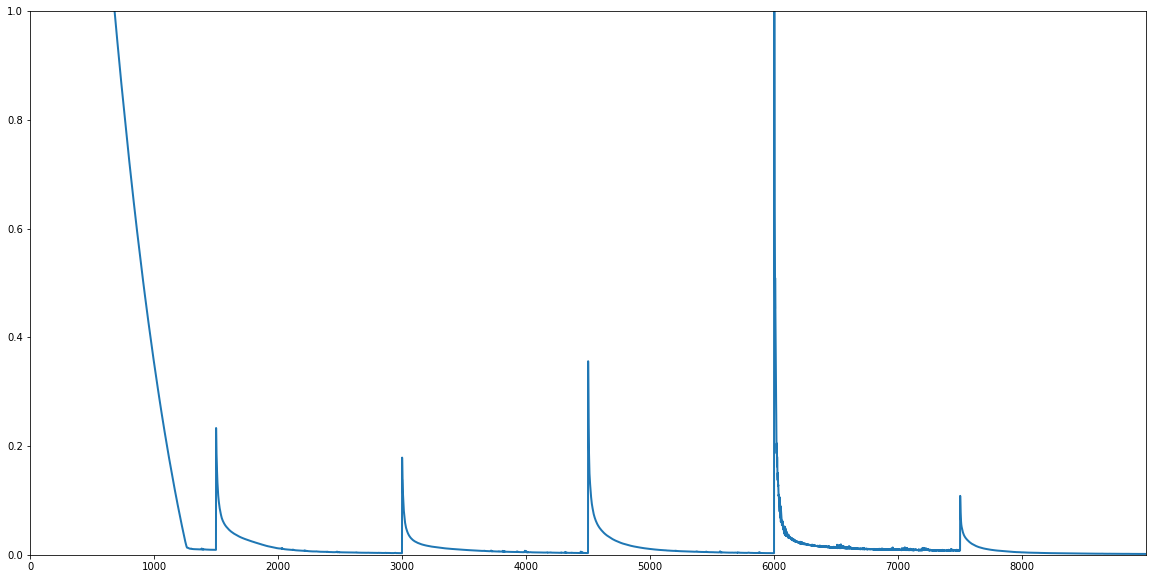

In [90]:
print(len_data_set)
ax=pd.Series(loss).plot(figsize=(20,10),lw=2)
ax.set_ylim(0,1)

0.5252525252525253
0.4444444444444444
0.5252525252525253


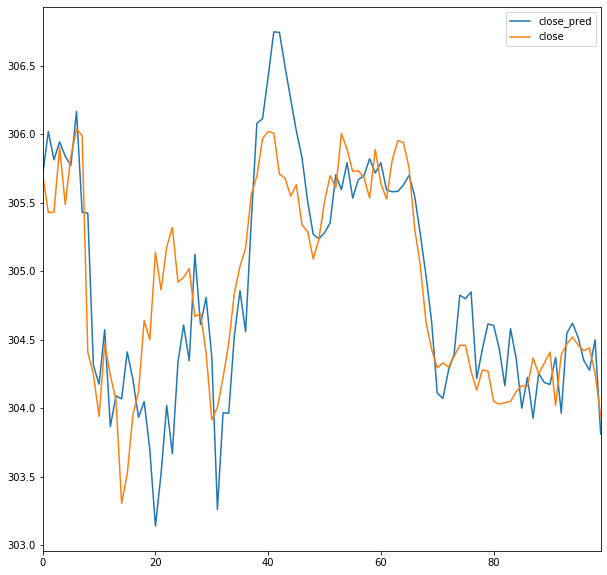

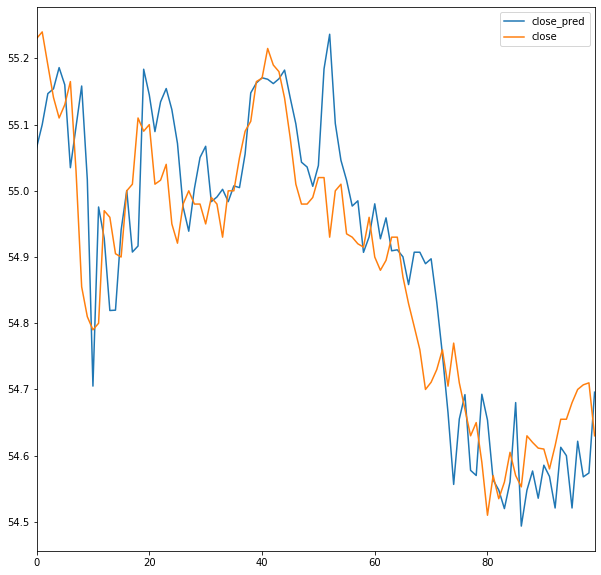

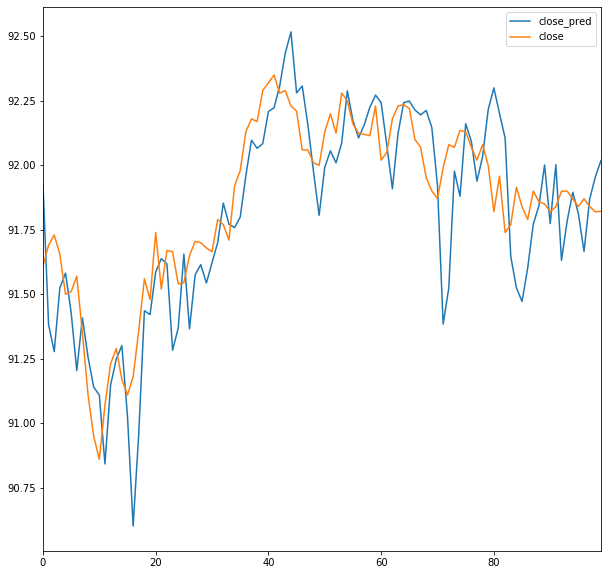

In [96]:
#El orden correcto evidentemente esta mal



In [16]:

[[scaler for scaler in dict_scaler['Scalers_Y'].values()] for dict_scaler in train_dataSet[0].values()]

[[MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1))],
 [MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1))],
 [MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1))]]

In [230]:
list_scalers_y=[]

scalers=[[scaler for scaler in dict_scaler['Scalers_Y'].values()] for dict_scaler in test_dataSet[0].values()]
         

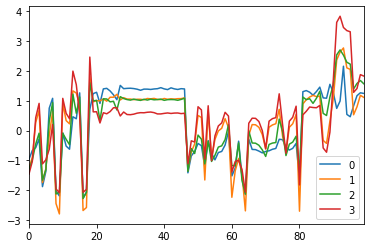

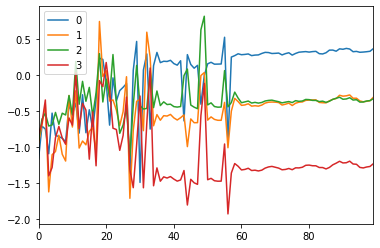

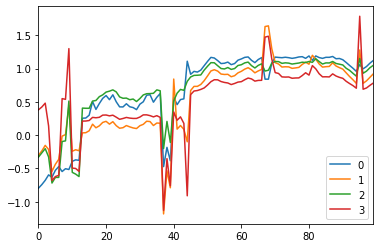

In [296]:




for i in predict_1:
    pd.DataFrame(i).plot()

In [274]:


for pred,scal in zip(predict_1,scalers):
    
    scaler0=scal[0]
    scaler1=scal[1]
    scaler2=scal[2]
    scaler3=scal[3]
    y0=scaler0.inverse_transform(pred[:,0].reshape(len(pred),1))
    y1=scaler1.inverse_transform(pred[:,1].reshape(len(pred),1))
    y2=scaler2.inverse_transform(pred[:,2].reshape(len(pred),1))
    y3=scaler3.inverse_transform(pred[:,3].reshape(len(pred),1))
    print(np.stack([y0,y1,y2,y3],axis=1).squeeze().shape)

(100, 4)
(100, 4)
(100, 4)


In [287]:
scalers

[[MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1))],
 [MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1))],
 [MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1)),
  MinMaxScaler(copy=True, feature_range=(-1, 1))]]

[array([[317.79077, 317.67426, 317.4195 , 317.4006 ],
        [318.07047, 318.32016, 317.71637, 318.10422],
        [318.18546, 319.02502, 318.18585, 319.05386],
        [318.4965 , 319.51456, 318.62244, 319.6572 ],
        [316.69498, 316.33243, 316.65024, 316.87125],
        [316.86224, 316.93152, 317.01105, 317.48666],
        [318.04065, 317.27383, 318.01093, 317.59564],
        [318.70377, 317.94534, 318.53372, 317.8679 ],
        [316.56573, 316.1195 , 316.5157 , 316.68265],
        [316.95135, 316.35623, 316.64514, 316.51172],
        [318.31702, 318.72656, 318.37183, 318.92776],
        [318.29376, 319.26303, 318.42664, 319.39258],
        [318.145  , 319.05353, 318.2192 , 319.1224 ],
        [319.14304, 320.0668 , 319.58585, 320.44037],
        [318.97357, 320.02252, 318.8859 , 320.12296],
        [319.2358 , 318.16824, 318.7236 , 317.7651 ],
        [316.49216, 316.01312, 316.4279 , 316.5589 ],
        [316.70578, 316.10953, 316.70477, 316.70862],
        [319.52396, 320.3539

{'AVGO': {'2019-11-12 14:16:00':                      AVGO_open  AVGO_high  AVGO_low  AVGO_close
  2019-11-12 14:16:00   315.0100     315.09  314.9600      315.09
  2019-11-12 14:17:00   315.0400     315.20  315.0400      315.14
  2019-11-12 14:18:00   315.1438     315.25  315.0000      315.25
  2019-11-12 14:19:00   315.2800     315.28  315.1500      315.24
  2019-11-12 14:20:00   315.2000     315.20  314.9901      315.10
  ...                        ...        ...       ...         ...
  2019-11-12 15:56:00   315.3500     315.74  315.3000      315.72
  2019-11-12 15:57:00   315.6500     315.71  315.5800      315.60
  2019-11-12 15:58:00   315.6100     315.65  315.4100      315.45
  2019-11-12 15:59:00   315.4600     315.64  315.3600      315.60
  2019-11-12 16:00:00   315.6100     315.93  315.5400      315.55
  
  [105 rows x 4 columns],
  '2019-11-13 09:41:00':                      AVGO_open  AVGO_high  AVGO_low  AVGO_close
  2019-11-13 09:41:00   314.3100    314.310   314.300     3

In [283]:
list_data

[{'AVGO':                      AVGO_open  AVGO_high  AVGO_low  AVGO_close
  2019-11-12 14:16:00   315.0100     315.09  314.9600      315.09
  2019-11-12 14:17:00   315.0400     315.20  315.0400      315.14
  2019-11-12 14:18:00   315.1438     315.25  315.0000      315.25
  2019-11-12 14:19:00   315.2800     315.28  315.1500      315.24
  2019-11-12 14:20:00   315.2000     315.20  314.9901      315.10
  ...                        ...        ...       ...         ...
  2019-11-12 15:56:00   315.3500     315.74  315.3000      315.72
  2019-11-12 15:57:00   315.6500     315.71  315.5800      315.60
  2019-11-12 15:58:00   315.6100     315.65  315.4100      315.45
  2019-11-12 15:59:00   315.4600     315.64  315.3600      315.60
  2019-11-12 16:00:00   315.6100     315.93  315.5400      315.55
  
  [105 rows x 4 columns],
  'MXIM':                      MXIM_open  MXIM_high  MXIM_low  MXIM_close
  2019-11-12 14:16:00      58.68     58.680     58.67       58.67
  2019-11-12 14:17:00      58.6

In [282]:
list_data

[{'AVGO':                      AVGO_open  AVGO_high  AVGO_low  AVGO_close
  2019-11-12 14:16:00   315.0100     315.09  314.9600      315.09
  2019-11-12 14:17:00   315.0400     315.20  315.0400      315.14
  2019-11-12 14:18:00   315.1438     315.25  315.0000      315.25
  2019-11-12 14:19:00   315.2800     315.28  315.1500      315.24
  2019-11-12 14:20:00   315.2000     315.20  314.9901      315.10
  ...                        ...        ...       ...         ...
  2019-11-12 15:56:00   315.3500     315.74  315.3000      315.72
  2019-11-12 15:57:00   315.6500     315.71  315.5800      315.60
  2019-11-12 15:58:00   315.6100     315.65  315.4100      315.45
  2019-11-12 15:59:00   315.4600     315.64  315.3600      315.60
  2019-11-12 16:00:00   315.6100     315.93  315.5400      315.55
  
  [105 rows x 4 columns],
  'MXIM':                      MXIM_open  MXIM_high  MXIM_low  MXIM_close
  2019-11-12 14:16:00      58.68     58.680     58.67       58.67
  2019-11-12 14:17:00      58.6

In [18]:
test_dataSet

[{'AVGO': {'X': array([[[-1.        , -1.        , -0.97903564, -1.        ,
            -1.        ],
           [-1.        , -1.        , -0.78173132, -0.89704308,
            -0.82233753],
           [-1.        , -1.        , -1.        , -1.        ,
            -1.        ],
           [-0.98554217, -1.        , -1.        , -0.87261146,
            -1.        ]],
   
          [[-0.679413  , -1.        , -1.        , -0.80842912,
            -0.6370821 ],
           [-0.59688629, -0.77761305, -1.        , -0.78173132,
            -0.89704308],
           [-0.67184549, -1.        , -0.97876858, -0.84344423,
            -0.60127852],
           [-0.56626506, -0.76824034, -0.97876858, -1.        ,
            -0.73376317]],
   
          [[-0.24109015, -0.679413  , -1.        , -0.82758621,
            -0.48027347],
           [-0.41154666, -0.41932296, -0.77761305, -1.        ,
            -0.78173132],
           [-0.22317597, -0.67184549, -0.97876858, -0.82387476,
            -

In [43]:
df_pred['open_pred']

TypeError: 'AxesSubplot' object is not subscriptable

In [44]:
df_pred

In [53]:
(df_pred['close_pred'].diff().dropna()*df_real['close'].diff().dropna()>0).mean()

0.7474747474747475

In [30]:
df

AVGO_open  AVGO_high  AVGO_low  AVGO_close  AVGO_volume  \
2019-11-11 09:31:00   311.2000    311.970  311.0000    311.5518      30193.0   
2019-11-11 09:32:00   311.7900    312.015  311.7100    311.8164       2167.0   
2019-11-11 09:33:00   311.8953    312.330  311.8953    312.1450       3849.0   
2019-11-11 09:34:00   312.6980    312.698  312.6980    312.6980       1653.0   
2019-11-11 09:35:00   312.3600    312.360  312.3600    312.3600       4223.0   
...                        ...        ...       ...         ...          ...   
2019-12-11 15:56:00   319.6400    319.685  319.5000    319.5100      19981.0   
2019-12-11 15:57:00   319.5200    319.810  319.5200    319.8100      14613.0   
2019-12-11 15:58:00   319.7900    319.980  319.7900    319.8450      25051.0   
2019-12-11 15:59:00   319.8400    319.980  319.8400    319.9000      19162.0   
2019-12-11 16:00:00   319.8850    320.000  319.7100    319.7100      37656.0   

                     MXIM_open  MXIM_high  MXIM_low  MXIM_close  MXIM_volume  \
2019-11-11 09:31:00    59.0619    59.1179   59.0078     59.0275      15210.0   
2019-11-11 09:32:00    59.0100    59.0700   59.0100     59.0700       2065.0   
2019-11-11 09:33:00    59.0550    59.0830   59.0550     59.0740       1690.0   
2019-11-11 09:34:00    59.0800    59.1100   59.0000     59.0400       6374.0   
2019-11-11 09:35:00    58.9500    58.9500   58.9500     58.9500      12077.0   
...                        ...        ...       ...         ...          ...   
2019-12-11 15:56:00    57.8800    57.8900   57.8450     57.8450      17415.0   
2019-12-11 15:57:00    57.8400    57.8600   57.8400     57.8550      14808.0   
2019-12-11 15:58:00    57.8600    57.8600   57.8450     57.8550      15967.0   
2019-12-11 15:59:00    57.8600    57.9300   57.8600     57.9250      22263.0   
2019-12-11 16:00:00    57.9300    57.9300   57.8600     57.8600      56611.0   

                     MCHP_open  MCHP_high  MCHP_low  MCHP_close  MCHP_volume  
2019-11-11 09:31:00    95.2830    95.5436   95.2033     95.4530      33429.0  
2019-11-11 09:32:00    95.3900    95.4700   95.2200     95.2600        845.0  
2019-11-11 09:33:00    95.3225    95.4974   95.2822     95.4075      17929.0  
2019-11-11 09:34:00    95.5220    95.5220   95.5220     95.5220      34097.0  
2019-11-11 09:35:00    95.1000    95.1000   95.1000     95.1000       8448.0  
...                        ...        ...       ...         ...          ...  
2019-12-11 15:56:00    99.3200    99.3300   99.2800     99.2900      10986.0  
2019-12-11 15:57:00    99.2800    99.3200   99.2800     99.3200      11953.0  
2019-12-11 15:58:00    99.3250    99.3900   99.3250     99.3600      14702.0  
2019-12-11 15:59:00    99.3800    99.4000   99.3700     99.3700      12165.0  
2019-12-11 16:00:00    99.3800    99.4100   99.3300     99.3500      35512.0  

[8394 rows x 15 columns]

[4, 4, 4, 4, 4, 4]

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [27]:
print(df)

                     AVGO_open  AVGO_high  AVGO_low  AVGO_close  AVGO_volume  \
2019-11-11 09:31:00   311.2000   311.9700  311.0000    311.5518      30193.0   
2019-11-11 09:32:00   311.7900   312.0150  311.7100    311.8164       2167.0   
2019-11-11 09:33:00   311.8953   312.3300  311.8953    312.1450       3849.0   
2019-11-11 09:34:00   312.6980   312.6980  312.6980    312.6980       1653.0   
2019-11-11 09:35:00   312.3600   312.3600  312.3600    312.3600       4223.0   
2019-11-11 09:36:00   312.0400   312.1600  312.0400    312.1600       3494.0   
2019-11-11 09:37:00   311.9688   311.9688  311.9688    311.9688       2236.0   
2019-11-11 09:38:00   311.8800   311.8800  311.6007    311.6007       4033.0   
2019-11-11 09:39:00   311.4420   311.4420  310.8400    310.8400        748.0   
2019-11-11 09:40:00   311.1500   311.5000  311.1500    311.5000       8502.0   
2019-11-11 09:41:00   311.3600   311.3600  311.3600    311.3600       5066.0   
2019-11-11 09:42:00   311.3600   311.360

In [36]:
df.groupby(df.index.day)
groups_by_columns=df.columns.str.partition('_').get_level_values(0)
len(df[df.notna().all(axis=1)].index.to_series().diff().gt(pd.Timedelta(minutes=1)).cumsum())
len(df)

8394

In [42]:
def Split_by_companiesANDdays():
    
    df_all=df[df.notna().all(axis=1)]
    groups_by_columns=df.columns.str.partition('_').get_level_values(0)
    groups_days=df_all.index.day

In [78]:
#division of dataframe in continuous time ranges and companies
def Split_by_companiesANDcontinuosTime(df,time_min=100,delays=5,limit_disc=5):
    
    df_all=df[df.notna().all(axis=1)]
    
    groups_by_columns=df.columns.str.partition('_').get_level_values(0)
    groups=df_all.index.to_series().diff().gt(pd.Timedelta(minutes=5)).cumsum()

    return { company:{ group.index[0].strftime(format='%Y-%m-%d %H:%M:%S'): 
                       group.loc[:,group.columns.str.contains(company)].iloc[:(len(group)//time_min)*time_min+delays] 
                      for i,group in df_all.groupby(groups) if ( len(group)>=(time_min+delays) ) }
            for company in groups_by_columns.unique() }

In [62]:
    df_all=df[df.notna().all(axis=1)]
    groups_by_columns=df.columns.str.partition('_').get_level_values(0)
    groups_days=df_all.index.day

In [77]:

size_min_group=350
time_large_disc=30
limit_mean_small_disc=0.05
time_small_disc=1

df_all=df[df.notna().all(axis=1)]
groups_by_columns=df.columns.str.partition('_').get_level_values(0)
groups_days=df_all.index.day

for i, group in df_all.groupby(groups_days):
    
    size_group=len(group) 
    
    #create a serie to check the index of that day
    time_diff=group.index.to_series().diff() 
    
    #search for large discontinuities
    Serie_disc_large=time_diff.gt( pd.Timedelta(minutes=time_large_disc) )
    
    if Serie_disc_large.any():
                
        sub_groups_valid= ( group.groupby(Serie_disc_large.cumsum())
                                 .transform('size')
                                 .gt(size_group) )
                
        if sub_groups_valid.any():
                    
            group=group.loc[sub_groups_valid]
                    
        else:
                    
            break
            
    elif size_group < size_min_group:
        
        break
        

    #check the limit of the mean small discontinuites
    valid_limit_small_disc=( time_diff.gt( pd.Timedelta(minutes=time_small_disc) )
                                      .mean()
                                      .lt(limit_mean_small_disc) )
    
    #check there are not repeat times
    no_repeat_time=group.index.to_series().diff().ne(pd.Timedelta(hours=0)).all() 
           

    if valid_limit_small_disc and no_repeat_time:
        
        
    

    
        
    
    

    

    

    

    

0.020942408376963352
0.020942408376963352
0.0291005291005291
0.07303370786516854
0.06593406593406594
0.07162534435261708
0.075
0.06336088154269973
0.02774108322324967
0.06318681318681318
0.05449591280653951
0.032
0.060109289617486336
0.015625
0.00516795865633075
0.02631578947368421
0.04838709677419355
0.03183023872679045
0.029023746701846966
0.04594594594594595
0.042105263157894736


In [53]:
len(df_all)

8001

In [135]:

#division of dataframe in continuous time ranges and companies
def Split_by_companiesANDcontinuosTime(df,time_min=350,delays=5,limit_disc=5,name_companies='AVGO,MXIM,MCHP'.split(',')):
    
    df_all=df[df.notna().all(axis=1)]
    
    
    groups=df_all.index.to_series().diff().gt(pd.Timedelta(minutes=limit_disc)).cumsum()

    return { company:{ group.index[0].strftime(format='%Y-%m-%d %H:%M:%S'): 
                       group.loc[:,group.columns.str.contains(company)].iloc[:(len(group)//time_min)*time_min+delays] 
                      for i,group in df_all.groupby(groups) if ( len(group)>=(time_min+delays) ) }
            for company in name_companies }



dict_data=Split_by_companiesANDcontinuosTime(df.loc[:,~df.columns.str.contains('volume')],time_min=350,delays=n,limit_disc=5)
data_dict=pd.DataFrame(dict_data).T.to_dict()
list_data=list(data_dict.values())

In [136]:
len([[len(i) for i in dictionary.values()] for dictionary in list_data])

20

In [137]:
#division of dataframe in continuous time ranges and companies
def Split_by_companiesANDcontinuosTime(df,time_min=350,delays=5,limit_disc=5,name_companies='AVGO,MXIM,MCHP'.split(',')):
    
    df_all=df[df.notna().all(axis=1)]
    
    
    groups=df_all.index.to_series().diff().gt(pd.Timedelta(minutes=limit_disc)).cumsum()

    return { group.index[0].strftime(format='%Y-%m-%d %H:%M:%S'):{ company: 
                       group.loc[:,group.columns.str.contains(company)].iloc[:(len(group)//time_min)*time_min+delays] 
                      for company in name_companies }
             for i,group in df_all.groupby(groups) if ( len(group)>=(time_min+delays) ) }

In [145]:
dict_data=Split_by_companiesANDcontinuosTime(df,time_min=350,delays=10,limit_disc=5)

In [148]:
len([[len(i) for i in dictionary.values()] for dictionary in list_data])

20

In [147]:
print(list_data)

[{'AVGO':                      AVGO_open  AVGO_high  AVGO_low  AVGO_close  AVGO_volume
2019-11-12 09:31:00   314.0100   314.4100  313.7800    313.9900          0.0
2019-11-12 09:32:00   313.9083   314.2701  313.6436    313.8481       4168.0
2019-11-12 09:33:00   313.8350   313.9900  313.8350    313.9900       3617.0
2019-11-12 09:34:00   313.9100   313.9100  313.9100    313.9100          0.0
2019-11-12 09:36:00   313.6800   313.6800  313.5990    313.5990       9917.0
2019-11-12 09:37:00   313.8900   313.8900  313.8900    313.8900        165.0
2019-11-12 09:39:00   314.0450   314.0450  313.6900    313.6900      11345.0
2019-11-12 09:40:00   313.9400   313.9400  313.9400    313.9400          0.0
2019-11-12 09:41:00   313.9600   314.0340  313.9200    313.9200      70040.0
2019-11-12 09:42:00   314.0400   314.5100  314.0400    314.4500      34971.0
2019-11-12 09:43:00   314.2957   314.4000  314.2750    314.2750       1571.0
2019-11-12 09:44:00   314.1500   314.2900  314.0000    314.0100   

In [ ]:
        adam = optimizers.adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        print(adam.epsilon)